In [60]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from datetime import timedelta

In [61]:
mid_night = datetime.datetime.strptime('23:59:59', '%H:%M:%S').time()
noon = datetime.datetime.strptime('12:00:00', '%H:%M:%S').time()
def str_to_time(x, start_time):
    if start_time.time() > noon: 
        if noon < datetime.datetime.strptime(x[:-4], '%H:%M:%S').time() < mid_night:
            return datetime.datetime.strptime(str(start_time.date()) + " " + x[:-4], '%Y-%m-%d %H:%M:%S')
        else:
            return datetime.datetime.strptime(str(start_time.date()) + " " + x[:-4], '%Y-%m-%d %H:%M:%S') + timedelta(days=1)
    else:
        return datetime.datetime.strptime(str(start_time.date()) + " " + x[:-4], '%Y-%m-%d %H:%M:%S')

In [62]:
def round_time(x):
    timestamp = datetime.datetime.strptime(x[0:10] + " " + x[11:-6], '%Y-%m-%d %H:%M:%S.%f')
    if timestamp.time().microsecond >= 500000:
        return datetime.datetime.strptime(x[0:10] + " " + x[11:-10], '%Y-%m-%d %H:%M:%S') + timedelta(seconds=1)
    else:
        return datetime.datetime.strptime(x[0:10] + " " + x[11:-10], '%Y-%m-%d %H:%M:%S')
    
    

In [197]:
rootdir = '../Sleep Data/'
sleep_profiles = []
xethru_recordings = []

for subdir, dirs, files in os.walk(rootdir):
    
#     if count != 0: break
    
    subdir_split = subdir.split('/')
    subdir_und = subdir_split[-1].split('_')
    
    current_xethru_recording = pd.DataFrame(columns=["time", "frame_count", "state", "rpm", "object_distance", 
                                        "signal_quality", "movement_slow", "movement_fast"])
    
    isFirstFile = True
    
    CSVCount = 0
            
    for file in files:        
        if (file == 'Sleep profile.txt' ) & ('PSG_analysis_manual' in subdir_split):
            start_time = ''
            with open(os.path.join(subdir, file)) as f:
                head = [next(f) for x in range(2)]
                start_time = datetime.datetime.strptime(head[1][12:-1], '%d.%m.%Y %H:%M:%S')
                
            sleep_profile = pd.read_csv(os.path.join(subdir, file), sep=";", skiprows=7, header=None)
            sleep_profile.columns = ["time", "stage"]
            sleep_profile['time'] = sleep_profile['time'].apply(lambda x: str_to_time(x, start_time))
            sleep_profiles.append(sleep_profile)
        
        file_split = file.split('_')
        
        if 'xethru' in file_split and 'sleep' in file_split and 'nattbord' in subdir_und:
            numCSVs = len(glob.glob1(subdir, "*.csv"))
            
            CSVCount = CSVCount + 1
            
            xethru_recording = pd.read_csv(os.path.join(subdir, file), sep=";", skiprows=1, header=None)

            xethru_recording.columns = ["time", "frame_count", "state", "rpm", "object_distance", 
                                        "signal_quality", "movement_slow", "movement_fast"]
            
            xethru_recording['time'] = xethru_recording['time'].apply(lambda x: round_time(x))
            
            start_timestamp = sleep_profiles[-1]['time'].iloc[0]
            end_timestamp = sleep_profiles[-1]['time'].iloc[-1]
            
            print(subdir)
            print('start timestamp: ', start_timestamp)
            print('end timestamp: ', end_timestamp)           
            print('Before: ', len(sleep_profiles[-1]))
            
            while isFirstFile and xethru_recording['time'].iloc[0] >= start_timestamp:                
                sleep_profiles[-1] = sleep_profiles[-1].iloc[1:]
                start_timestamp = sleep_profiles[-1]['time'].iloc[0]
            
            print('Mid: ', len(sleep_profiles[-1]))
            
            while (numCSVs == CSVCount) and xethru_recording['time'].iloc[-1] <= end_timestamp:                
                sleep_profiles[-1] = sleep_profiles[-1].iloc[:1]                
                end_timestamp = sleep_profiles[-1]['time'].iloc[-1]
           
            
            print('After: ', len(sleep_profiles[-1]))
            print('Last xethru: ', xethru_recording['time'].iloc[-1] )
            print('Last sleep profile: ', sleep_profiles[-1]['time'].iloc[-1])
            print()            
            
            current_xethru_recording = current_xethru_recording.append(xethru_recording)
                        
            isFirstFile = False
    
    if len(current_xethru_recording) > 0 and 'nattbord' in subdir_und:
#         current_xethru_recording = current_xethru_recording.drop_duplicates('time', keep='first')
        for x in range(1, current_xethru_recording.shape[0]):
            if (current_xethru_recording['time'].iloc[x]) != (current_xethru_recording['time'].iloc[x-1] + timedelta(seconds=1)):
                time_adjusted = current_xethru_recording['time'].iloc[x-1] + timedelta(seconds=1)
                current_xethru_recording['time'].iloc[x] = time_adjusted

#         for x in range(1, current_xethru_recording.shape[0]):
#             if (current_xethru_recording['time'].iloc[x]) != (current_xethru_recording['time'].iloc[x-1] + timedelta(seconds=1)):
#                 print(subdir)
#                 print('t1', current_xethru_recording['time'].iloc[x-1])
#                 print('t2', str(current_xethru_recording['time'].iloc[x]) + '\n')

        start_timestamp = sleep_profiles[-1]['time'].iloc[0]
        end_timestamp = sleep_profiles[-1]['time'].iloc[-1] + timedelta(seconds=29)
        current_xethru_recording = current_xethru_recording[current_xethru_recording['time'].map(lambda x: start_timestamp <= x <= end_timestamp)]        
        xethru_recordings.append(current_xethru_recording)

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start timestamp:  2017-11-22 23:45:00
end timestamp:  2017-11-23 06:35:00
Before:  821
Mid:  821
After:  821
Last xethru:  2017-11-23 00:14:39
Last sleep profile:  2017-11-23 06:35:00

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start timestamp:  2017-11-22 23:45:00
end timestamp:  2017-11-23 06:35:00
Before:  821
Mid:  821
After:  821
Last xethru:  2017-11-23 01:14:40
Last sleep profile:  2017-11-23 06:35:00

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start timestamp:  2017-11-22 23:45:00
end timestamp:  2017-11-23 06:35:00
Before:  821
Mid:  821
After:  821
Last xethru:  2017-11-23 02:14:41
Last sleep profile:  2017-11-23 06:35:00

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start timestamp:  2017-11-22 23:45:00

../Sleep Data/raw_data_1/104/xethru_recording_20171122_224022_x4m200_17FPS_P104_nattbord_100000010115
start timestamp:  2017-11-22 22:40:30
end timestamp:  2017-11-23 06:45:00
Before:  970
Mid:  970
After:  970
Last xethru:  2017-11-23 02:40:25
Last sleep profile:  2017-11-23 06:45:00

../Sleep Data/raw_data_1/104/xethru_recording_20171122_224022_x4m200_17FPS_P104_nattbord_100000010115
start timestamp:  2017-11-22 22:40:30
end timestamp:  2017-11-23 06:45:00
Before:  970
Mid:  970
After:  970
Last xethru:  2017-11-23 03:40:26
Last sleep profile:  2017-11-23 06:45:00

../Sleep Data/raw_data_1/104/xethru_recording_20171122_224022_x4m200_17FPS_P104_nattbord_100000010115
start timestamp:  2017-11-22 22:40:30
end timestamp:  2017-11-23 06:45:00
Before:  970
Mid:  970
After:  970
Last xethru:  2017-11-23 04:40:27
Last sleep profile:  2017-11-23 06:45:00

../Sleep Data/raw_data_1/104/xethru_recording_20171122_224022_x4m200_17FPS_P104_nattbord_100000010115
start timestamp:  2017-11-22 22:40:30

../Sleep Data/raw_data_1/107/xethru_recording_20171127_000646_x4m200_17FPS_P107_nattbord_100000010095
start timestamp:  2017-11-27 00:30:00
end timestamp:  2017-11-27 07:15:00
Before:  811
Mid:  811
After:  811
Last xethru:  2017-11-27 06:06:51
Last sleep profile:  2017-11-27 07:15:00

../Sleep Data/raw_data_1/107/xethru_recording_20171127_000646_x4m200_17FPS_P107_nattbord_100000010095
start timestamp:  2017-11-27 00:30:00
end timestamp:  2017-11-27 07:15:00
Before:  811
Mid:  811
After:  811
Last xethru:  2017-11-27 06:44:39
Last sleep profile:  2017-11-27 07:15:00

../Sleep Data/raw_data_1/108/xethru_recording_20171130_225059_x4m200_17FPS_P108_nattbord_100000010206
start timestamp:  2017-11-30 23:00:00
end timestamp:  2017-12-01 09:42:30
Before:  1286
Mid:  1286
After:  1286
Last xethru:  2017-11-30 23:50:59
Last sleep profile:  2017-12-01 09:42:30

../Sleep Data/raw_data_1/108/xethru_recording_20171130_225059_x4m200_17FPS_P108_nattbord_100000010206
start timestamp:  2017-11-30 23:00

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start timestamp:  2017-11-30 01:30:00
end timestamp:  2017-11-30 08:04:00
Before:  789
Mid:  789
After:  789
Last xethru:  2017-11-30 01:06:20
Last sleep profile:  2017-11-30 08:04:00

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start timestamp:  2017-11-30 01:30:00
end timestamp:  2017-11-30 08:04:00
Before:  789
Mid:  789
After:  789
Last xethru:  2017-11-30 02:06:21
Last sleep profile:  2017-11-30 08:04:00

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start timestamp:  2017-11-30 01:30:00
end timestamp:  2017-11-30 08:04:00
Before:  789
Mid:  789
After:  789
Last xethru:  2017-11-30 03:06:22
Last sleep profile:  2017-11-30 08:04:00

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start timestamp:  2017-11-30 01:30:00

../Sleep Data/raw_data_1/114/xethru_recording_20171201_234139_x4m200_17FPS_P114_nattbord_100000010115
start timestamp:  2017-12-02 00:16:30
end timestamp:  2017-12-02 07:55:00
Before:  918
Mid:  918
After:  918
Last xethru:  2017-12-02 06:41:45
Last sleep profile:  2017-12-02 07:55:00

../Sleep Data/raw_data_1/114/xethru_recording_20171201_234139_x4m200_17FPS_P114_nattbord_100000010115
start timestamp:  2017-12-02 00:16:30
end timestamp:  2017-12-02 07:55:00
Before:  918
Mid:  918
After:  918
Last xethru:  2017-12-02 07:41:46
Last sleep profile:  2017-12-02 07:55:00

../Sleep Data/raw_data_1/114/xethru_recording_20171201_234139_x4m200_17FPS_P114_nattbord_100000010115
start timestamp:  2017-12-02 00:16:30
end timestamp:  2017-12-02 07:55:00
Before:  918
Mid:  918
After:  918
Last xethru:  2017-12-02 07:53:15
Last sleep profile:  2017-12-02 07:55:00

../Sleep Data/raw_data_1/115/xethru_recording_20171210_225458_x4m200_17FPS_P115_nattbord_100000010206
start timestamp:  2017-12-10 23:06:00

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start timestamp:  2017-12-04 00:17:30
end timestamp:  2017-12-04 07:38:30
Before:  883
Mid:  883
After:  883
Last xethru:  2017-12-04 03:48:48
Last sleep profile:  2017-12-04 07:38:30

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start timestamp:  2017-12-04 00:17:30
end timestamp:  2017-12-04 07:38:30
Before:  883
Mid:  883
After:  883
Last xethru:  2017-12-04 04:48:49
Last sleep profile:  2017-12-04 07:38:30

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start timestamp:  2017-12-04 00:17:30
end timestamp:  2017-12-04 07:38:30
Before:  883
Mid:  883
After:  883
Last xethru:  2017-12-04 05:48:50
Last sleep profile:  2017-12-04 07:38:30

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start timestamp:  2017-12-04 00:17:30

../Sleep Data/raw_data_3/121/xethru_recording_20171207_233626_x4m200_17FPS_P121_nattbord_100000010083
start timestamp:  2017-12-07 23:52:30
end timestamp:  2017-12-08 06:14:30
Before:  765
Mid:  765
After:  765
Last xethru:  2017-12-08 06:10:23
Last sleep profile:  2017-12-08 06:14:30

../Sleep Data/raw_data_3/122/xethru_recording_20171213_224443_x4m200_17FPS_P122_nattbord_100000010206
start timestamp:  2017-12-13 22:30:00
end timestamp:  2017-12-14 08:08:30
Before:  1158
Mid:  1128
After:  1128
Last xethru:  2017-12-13 23:44:43
Last sleep profile:  2017-12-14 08:08:30

../Sleep Data/raw_data_3/122/xethru_recording_20171213_224443_x4m200_17FPS_P122_nattbord_100000010206
start timestamp:  2017-12-13 22:45:00
end timestamp:  2017-12-14 08:08:30
Before:  1128
Mid:  1128
After:  1128
Last xethru:  2017-12-14 00:44:44
Last sleep profile:  2017-12-14 08:08:30

../Sleep Data/raw_data_3/122/xethru_recording_20171213_224443_x4m200_17FPS_P122_nattbord_100000010206
start timestamp:  2017-12-13 22

../Sleep Data/raw_data_3/125/xethru_recording_20171129_224521_x4m200_17FPS_P125_nattbord_100000010095
start timestamp:  2017-11-29 23:10:00
end timestamp:  2017-11-30 08:19:30
Before:  1100
Mid:  1100
After:  1100
Last xethru:  2017-11-30 02:45:25
Last sleep profile:  2017-11-30 08:19:30

../Sleep Data/raw_data_3/125/xethru_recording_20171129_224521_x4m200_17FPS_P125_nattbord_100000010095
start timestamp:  2017-11-29 23:10:00
end timestamp:  2017-11-30 08:19:30
Before:  1100
Mid:  1100
After:  1100
Last xethru:  2017-11-30 03:45:26
Last sleep profile:  2017-11-30 08:19:30

../Sleep Data/raw_data_3/125/xethru_recording_20171129_224521_x4m200_17FPS_P125_nattbord_100000010095
start timestamp:  2017-11-29 23:10:00
end timestamp:  2017-11-30 08:19:30
Before:  1100
Mid:  1100
After:  1100
Last xethru:  2017-11-30 04:45:27
Last sleep profile:  2017-11-30 08:19:30

../Sleep Data/raw_data_3/125/xethru_recording_20171129_224521_x4m200_17FPS_P125_nattbord_100000010095
start timestamp:  2017-11-29

../Sleep Data/raw_data_4/128/xethru_recording_20171210_225506_x4m200_17FPS_P128_nattbord_100000010115
start timestamp:  2017-12-10 23:07:00
end timestamp:  2017-12-11 06:34:30
Before:  896
Mid:  896
After:  896
Last xethru:  2017-12-11 05:55:13
Last sleep profile:  2017-12-11 06:34:30

../Sleep Data/raw_data_4/128/xethru_recording_20171210_225506_x4m200_17FPS_P128_nattbord_100000010115
start timestamp:  2017-12-10 23:07:00
end timestamp:  2017-12-11 06:34:30
Before:  896
Mid:  896
After:  896
Last xethru:  2017-12-11 06:33:14
Last sleep profile:  2017-12-11 06:34:30

../Sleep Data/raw_data_4/129/xethru_recording_20171213_223420_x4m200_17FPS_P129_nattbord_100000010115
start timestamp:  2017-12-13 22:53:30
end timestamp:  2017-12-14 08:02:00
Before:  1098
Mid:  1098
After:  1098
Last xethru:  2017-12-13 23:34:21
Last sleep profile:  2017-12-14 08:02:00

../Sleep Data/raw_data_4/129/xethru_recording_20171213_223420_x4m200_17FPS_P129_nattbord_100000010115
start timestamp:  2017-12-13 22:53

../Sleep Data/raw_data_4/133/xethru_recording_20171218_231723_x4m200_17FPS_P133_nattbord_100000010095
start timestamp:  2017-12-19 00:01:00
end timestamp:  2017-12-19 07:35:00
Before:  909
Mid:  909
After:  909
Last xethru:  2017-12-19 04:17:27
Last sleep profile:  2017-12-19 07:35:00

../Sleep Data/raw_data_4/133/xethru_recording_20171218_231723_x4m200_17FPS_P133_nattbord_100000010095
start timestamp:  2017-12-19 00:01:00
end timestamp:  2017-12-19 07:35:00
Before:  909
Mid:  909
After:  909
Last xethru:  2017-12-19 05:17:28
Last sleep profile:  2017-12-19 07:35:00

../Sleep Data/raw_data_4/133/xethru_recording_20171218_231723_x4m200_17FPS_P133_nattbord_100000010095
start timestamp:  2017-12-19 00:01:00
end timestamp:  2017-12-19 07:35:00
Before:  909
Mid:  909
After:  909
Last xethru:  2017-12-19 06:17:29
Last sleep profile:  2017-12-19 07:35:00

../Sleep Data/raw_data_4/133/xethru_recording_20171218_231723_x4m200_17FPS_P133_nattbord_100000010095
start timestamp:  2017-12-19 00:01:00

../Sleep Data/raw_data_5/136/xethru_recording_20171218_235351_x4m200_17FPS_P136_nattbord_100000010206
start timestamp:  2017-12-19 00:27:30
end timestamp:  2017-12-19 07:41:00
Before:  868
Mid:  868
After:  868
Last xethru:  2017-12-19 02:53:53
Last sleep profile:  2017-12-19 07:41:00

../Sleep Data/raw_data_5/136/xethru_recording_20171218_235351_x4m200_17FPS_P136_nattbord_100000010206
start timestamp:  2017-12-19 00:27:30
end timestamp:  2017-12-19 07:41:00
Before:  868
Mid:  868
After:  868
Last xethru:  2017-12-19 03:53:54
Last sleep profile:  2017-12-19 07:41:00

../Sleep Data/raw_data_5/136/xethru_recording_20171218_235351_x4m200_17FPS_P136_nattbord_100000010206
start timestamp:  2017-12-19 00:27:30
end timestamp:  2017-12-19 07:41:00
Before:  868
Mid:  868
After:  868
Last xethru:  2017-12-19 04:53:55
Last sleep profile:  2017-12-19 07:41:00

../Sleep Data/raw_data_5/136/xethru_recording_20171218_235351_x4m200_17FPS_P136_nattbord_100000010206
start timestamp:  2017-12-19 00:27:30

KeyboardInterrupt: 

In [188]:
print(len(xethru_recordings[0]))

24630


In [162]:
all_xethru_recordings = pd.concat(xethru_recordings, ignore_index=True)
all_sleep_profiles = pd.concat(sleep_profiles, ignore_index=True)

In [182]:
821 + (956 - 8 + 1) + (992 - 8 + 1) + (979 - 8 + 1) + (1046 - 8 + 1) + (908 - 8 + 1) + (818 - 8 + 1) + (1293 - 8 + 1) + (1016 - 8 + 1) + (1056 - 8 + 1) + (796 - 8 + 1) + (746 - 8 + 1) + (941 - 8 + 1) + (925 - 8 + 1) + (911 - 8 + 1) + (845 - 8 + 1) + (1237 - 8 + 1) + (890 - 8 + 1) + (871 - 8 + 1) + (826 - 8 + 1) + (772 - 8 + 1) + (1165 - 8 + 1) + (863 - 8 + 1) + (1178 - 8 + 1) + (1107 - 8 + 1) + (856 - 8 + 1) + (1019 - 8 + 1) + (903 - 8 + 1) + (1105 - 8 + 1) + (486 - 8 + 1) + (1450 - 8 + 1) + (916 - 8 + 1) + (795 - 8 + 1) + (954 - 8 + 1) + (875 - 8 + 1) + (1276 - 8 + 1) + (1370 - 8 + 1) + (1412 - 8 + 1) + (1450 - 8 + 1) + (1348 - 8 + 1) + (997 - 8 + 1) + (1273 - 8 + 1) + (1286 - 8 + 1) + (982 - 8 + 1)

44410

In [6]:
data = []
allData = []

for i in range(0, len(sleep_profiles)):
    
    for j in range(0, len(sleep_profiles[i])):
        start_time = sleep_profiles[i]['time'].iloc[j]
        end_time = start_time + timedelta(seconds=29)
        
        for k in range(0, len(xethru_recordings[i])):
            if start_time <= xethru_recordings[i]['time'].iloc[k] <= end_time and len(data) <= 30:
                data.append(xethru_recordings[i]['rpm'].iloc[k])
                 
        allData.append(data)
        data = []
        
print('i: ', i)

i:  43


In [167]:
labels = np.array(all_sleep_profiles['stage'].to_numpy())

In [8]:
allLabels = [labels[allData.index(data)] for data in allData if 0.0 not in data]
allData = [data for data in allData if 0.0 not in data]

In [29]:
print('Data: ', len(allData))
print('Labels: ', len(allLabels))

Data:  14904
Labels:  14904


In [40]:
data = data.tolist()
allLabels_new = [labels[data.index(element)] for element in data if 0.0 not in element]
allData_new = [element for element in data if 0.0 not in element]

In [171]:
print('Data: ', len(data))
print('Labels: ', len(labels))

Data:  821
Labels:  821


In [180]:
all_xethru_recordings['time'].iloc[-1]

Timestamp('2017-11-23 06:35:29')

In [10]:
allData = np.array(allData)
allLabels = np.array(allLabels)

In [46]:
np.place(allLabels, allLabels==' Wake', [0])
np.place(allLabels, allLabels==' N1', [1])
np.place(allLabels, allLabels==' N2', [2])
np.place(allLabels, allLabels==' N3', [3])
np.place(allLabels, allLabels==' REM', [4])

/home/isuru/.conda/envs/maritime_surveillance/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


ValueError: place: mask and data must be the same size

In [10]:
np.place(labels, labels==' Wake', [0])
np.place(labels, labels==' N1', [1])
np.place(labels, labels==' N2', [2])
np.place(labels, labels==' N3', [3])
np.place(labels, labels==' REM', [4])

In [9]:
allLabels = allLabels.astype('int32')

In [39]:
np.savetxt('allLabels.csv', allLabels, delimiter=',', fmt='%s')

In [106]:
np.save('allData.npy', allData)

In [4]:
allData = np.load('allData.npy', allow_pickle=True)

In [5]:
allLabels = np.genfromtxt('allLabels.csv', delimiter=',').astype('int32')

In [169]:
xethru_numpy = np.array(all_xethru_recordings['rpm'])

In [170]:
data = np.array(np.split(xethru_numpy, len(xethru_numpy)/30))

In [ ]:
xethru_numpy_movement = np.array(all_xethru_recordings['movement_slow'])
xethru_numpy_movement_fast = np.array(all_xethru_recordings['movement_fast'])
data_rpm = np.array(np.split(xethru_numpy, len(xethru_numpy)/30))
data_movement = np.array(np.split(xethru_numpy_movement, len(xethru_numpy_movement)/30))
data_movement_fast = np.array(np.split(xethru_numpy_movement_fast, len(xethru_numpy_movement_fast)/30))
data = np.column_stack((data_rpm, data_movement))
data = np.column_stack((data, data_movement_fast))

In [334]:
print('data: ', len(data_new))
print('labels: ', len(labels_new))

data:  36145
labels:  36145


In [335]:
labels = np.array(labels_new)
data = np.array(data_new)

In [77]:
np.place(labels, labels==' Wake', [0])
np.place(labels, labels==' N1', [1])
np.place(labels, labels==' N2', [2])
np.place(labels, labels==' N3', [3])
np.place(labels, labels==' REM', [4])

In [97]:
data_z = []
labels_z = []
for i in range(len(data)):
    if sum(data[i]) != 0:
        data_z.append(data[i])
        labels_z.append(labels[i])

In [98]:
data = np.array(data_z)
labels = np.array(labels_z)

In [339]:
import pickle

pickle_in = open("allDataSameLength.pickle","rb")
example_dict = pickle.load(pickle_in)

In [151]:
dataWithoutMuchNull = []
for value in data:
    count = 0
    for i in value[0]:
        if i == 0:
            count = count+1
    if count < 10:
        dataWithoutMuchNull.append(value)     

In [152]:
data_o = []
labels_o = []
for value,label in dataWithoutMuchNull:
    if(label != 5 ):
        data_o.append(value)
        labels_o.append(label)

In [138]:
data_z = []
labels_z = []
for i in range(len(data_o)):
    if sum(data_o[i]) != 0:
        data_z.append(data_o[i])
        labels_z.append(labels_o[i])

In [153]:
data_z = np.array(data_o).astype("float32")
labels_z = np.array(labels_o)

In [120]:
type(data_z)

numpy.ndarray

In [22]:
# import random

# random.shuffle(example_dict)

In [340]:
np.array(example_dict)
data = []
labels = []
for value,label in example_dict:
    data.append(value)
    labels.append(label)

In [206]:
type(data[0][0])

decimal.Decimal

In [347]:
data_np = np.array(data).astype('float32')
labels_np = np.array(labels).astype('int32')

In [348]:
print('data: ', len(data_np))
print('labels: ', len(labels_np))

data:  36187
labels:  36187


In [351]:
remove = []
for i in range(len(data_np)):
    if labels_np[i] == 5:
        remove.append(i)
        
data_np_a = np.delete(data_np, remove, axis = 0)
labels_np_a = np.delete(labels_np, remove)

In [352]:
print('data: ', len(data_np_a))
print('labels: ', len(labels_np_a))

data:  36145
labels:  36145


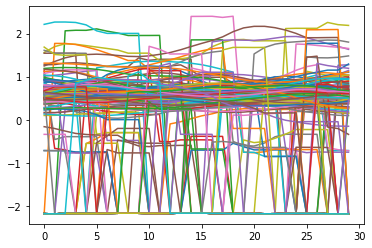

In [355]:
for i in range(200):
    plt.plot(data_train_p[i])

In [459]:
unique, counts = np.unique(labels_test, return_counts=True)
dict(zip(unique, counts))

{0: 1663, 1: 666, 2: 6547, 3: 3187, 4: 4082}

In [447]:
data_train = data_np_a[:20000]
labels_train = labels_np_a[:20000]

data_test = data_np_a[20000:]
labels_test = labels_np_a[20000:]

In [110]:
# class_weight = {0:0.75, 1:1, 2:0.1, 3:0.2, 4:0.3}

In [231]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras import Input

In [232]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [354]:
data_train_p = preprocessing.scale(data_np_a)

/home/isuru/.conda/envs/maritime_surveillance/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/isuru/.conda/envs/maritime_surveillance/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [356]:
train_data, test_data, train_labels, test_labels = train_test_split(data_train_p, labels_np_a, test_size=0.1, random_state=0)

In [357]:
len(test_data)

3615

In [403]:
# Embedding
max_features = 30000
maxlen = 30
embedding_size = 128

# Convolution
kernel_size = 8
filters = 128
pool_size = 10

# LSTM
lstm_output_size = 60

# Training
batch_size = 5
epochs = 8

In [404]:
data_train.shape

(20000, 30)

In [448]:
data_train = np.reshape(data_train, (data_train.shape[0], 1, data_train.shape[1]))
data_test = np.reshape(data_test, (data_test.shape[0], 1, data_test.shape[1]))

In [478]:
model = Sequential()
# model.add(Embedding(max_features, embedding_size, input_length=maxlen, batch_input_shape = (5, 30)))
# model.add(Dropout(0.25))
# model.add(Conv1D(filters,
#                  kernel_size,
#                  padding='valid',
#                  activation='relu',
#                  strides=2))
# model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(16, input_shape=(1, 30), batch_input_shape = (5, 1, 30), stateful = True, return_sequences = True))
model.add(LSTM(4, input_shape=(1, 30), stateful = True))
# model.add(LSTM(lstm_output_size, return_sequences = True))
# model.add(LSTM(lstm_output_size))
model.add(Dense(5, activation='relu'))
model.add(Activation('softmax'))

In [479]:
# model = Sequential()
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(2048, activation='relu'))
# model.add(Dense(2048, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [480]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [481]:
history = model.fit(data_train, labels_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(data_test, labels_test))

Train on 20000 samples, validate on 16145 samples
Epoch 1/8
20000/20000 [==============================] - 26s 1ms/sample - loss: 1.4411 - acc: 0.4110 - val_loss: 1.3766 - val_acc: 0.4214
Epoch 2/8
20000/20000 [==============================] - 23s 1ms/sample - loss: 1.4040 - acc: 0.4178 - val_loss: 1.3899 - val_acc: 0.4058
Epoch 3/8
20000/20000 [==============================] - 20s 982us/sample - loss: 1.4026 - acc: 0.4182 - val_loss: 1.3669 - val_acc: 0.4095
Epoch 4/8
20000/20000 [==============================] - 23s 1ms/sample - loss: 1.3979 - acc: 0.4209 - val_loss: 1.3756 - val_acc: 0.4126
Epoch 5/8
20000/20000 [==============================] - 22s 1ms/sample - loss: 1.3954 - acc: 0.4216 - val_loss: 1.3660 - val_acc: 0.4113
Epoch 6/8
20000/20000 [==============================] - 21s 1ms/sample - loss: 1.3941 - acc: 0.4215 - val_loss: 1.3550 - val_acc: 0.4211
Epoch 7/8
20000/20000 [==============================] - 25s 1ms/sample - loss: 1.3922 - acc: 0.4218 - val_loss: 1.3563 

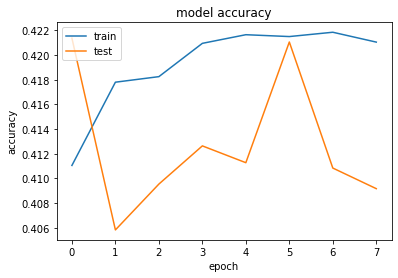

In [482]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = model.predict(data_test)

# test_labels = test_labels.astype('int32')

confusion_matrix = confusion_matrix(labels_test, y_pred.argmax(axis=1))

df_cm = pd.DataFrame(confusion_matrix, index = ['Wake', 'N1', 'N2', 'N3', 'REM'],
                  columns = ['Wake','N1', 'N2', 'N3', 'REM'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [247]:
pickle_in = open("allDataSameLengthWithoutArtefact.pickle","rb")
example_dict = pickle.load(pickle_in)

In [248]:
np.array(example_dict)
data_t = []
labels_t = []
for value,label in example_dict:
    data_t.append(value)
    labels_t.append(label)

In [249]:
data_t_np = np.array(data_t).astype('float32')
labels_t_np = np.array(labels_t).astype('int32')

In [250]:
print('data: ', len(data_t_np))
print('labels: ', len(labels_t_np))

data:  1948
labels:  1948


In [251]:
labels_t = np.array(labels_t_np)
data_t = np.array(data_t_np)

In [283]:
data_test_p = preprocessing.normalize(data_test)

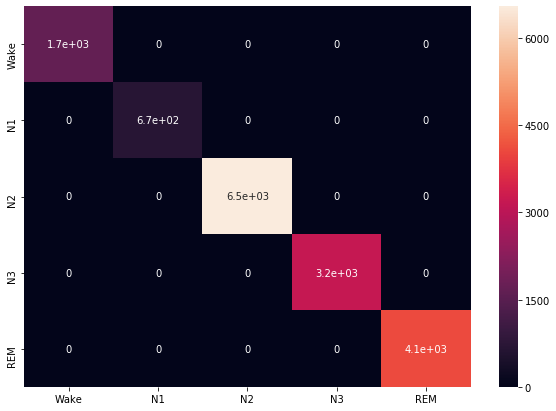

In [284]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = model.predict(data_test_p)

# test_labels = labels_t.astype('int32')

confusion_matrix = confusion_matrix(labels_test, y_pred.argmax(axis=1))

df_cm = pd.DataFrame(confusion_matrix, index = ['Wake', 'N1', 'N2', 'N3', 'REM'],
                  columns = ['Wake','N1', 'N2', 'N3', 'REM'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [109]:
confusion_matrix

array([[ 29, 114,  53,  69,  21],
       [ 15,  98,  24,  44,  25],
       [178, 919, 432, 548, 166],
       [ 78, 456, 171, 311,  64],
       [ 64, 256,  95,  88, 154]])

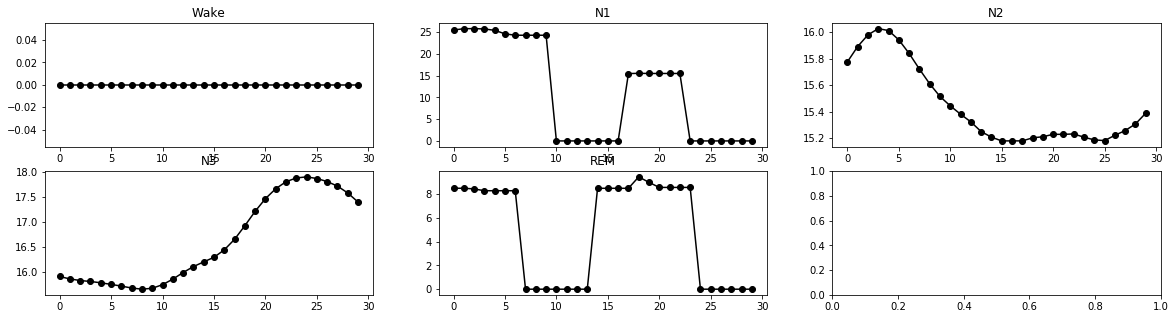

In [293]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5))

labels = labels_test
allData = data_test

n = 20

counts = [0,0,0,0,0]

for i in range(0,len(data_test)):
    if(labels_test[i] == 0):
        counts[0] += 1
        if counts[0] == n:
            axes[0, 0].plot(data_test[i], '-o' + 'k')
            axes[0, 0].set_title("Wake")
        
    if(labels_test[i] == 1):
        counts[1] += 1
        if counts[1] == n:
            axes[0, 1].plot(data_test[i], '-o' + 'k')
            axes[0, 1].set_title("N1")
        
    if(labels_test[i] == 2):
        counts[2] += 1
        if counts[2] == n:
            axes[0, 2].plot(data_test[i], '-o' + 'k')
            axes[0, 2].set_title("N2")
        
    if(labels_test[i] == 3):
        counts[3] += 1
        if counts[3] == n:
            axes[1, 0].plot(data_test[i], '-o' + 'k')
            axes[1, 0].set_title("N3")
        
    if(labels_test[i] == 4):
        counts[4] += 1
        if counts[4] == n:
            axes[1, 1].plot(data_test[i], '-o' + 'k')
            axes[1, 1].set_title("REM")

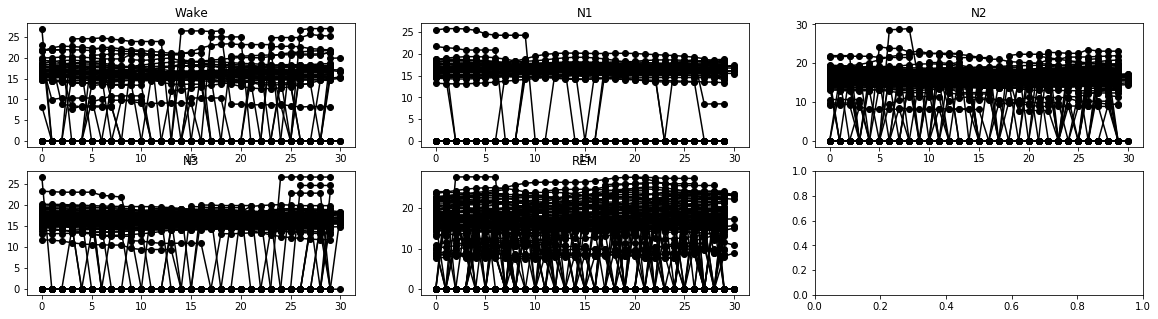

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5))

for i in range(0,820):
    if(labels[i] == ' Wake'):
        axes[0, 0].plot(allData[i], '-o' + 'k')
        axes[0, 0].set_title("Wake")
        
    if(labels[i] == ' N1'):
        axes[0, 1].plot(allData[i], '-o' + 'k')
        axes[0, 1].set_title("N1")
        
    if(labels[i] == ' N2'):
        axes[0, 2].plot(allData[i], '-o' + 'k')
        axes[0, 2].set_title("N2")
        
    if(labels[i] == ' N3'):
        axes[1, 0].plot(allData[i], '-o' + 'k')
        axes[1, 0].set_title("N3")
        
    if(labels[i] == ' REM'):
        axes[1, 1].plot(allData[i], '-o' + 'k')
        axes[1, 1].set_title("REM")

In [16]:
allLabels = np.array(allLabels)
np.place(allLabels, allLabels==' Wake', [0])
np.place(allLabels, allLabels==' N1', [1])
np.place(allLabels, allLabels==' N2', [2])
np.place(allLabels, allLabels==' N3', [3])
np.place(allLabels, allLabels==' REM', [4])

/home/isuru/.conda/envs/maritime_surveillance/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


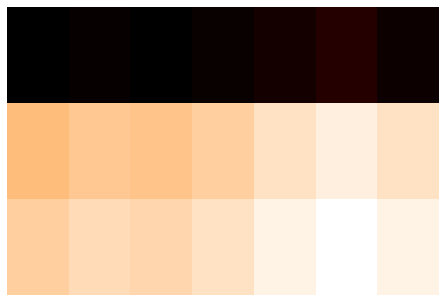

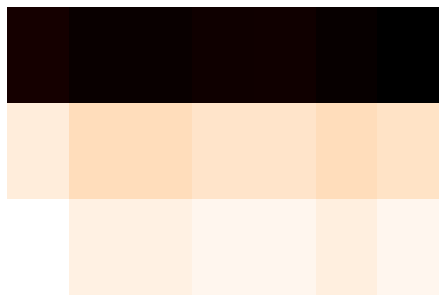

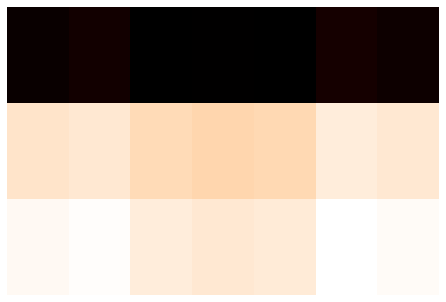

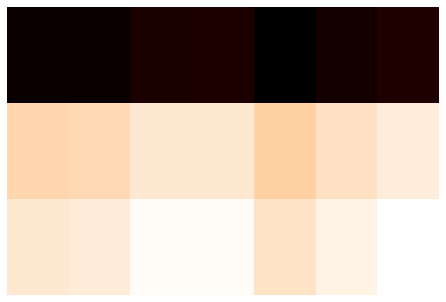

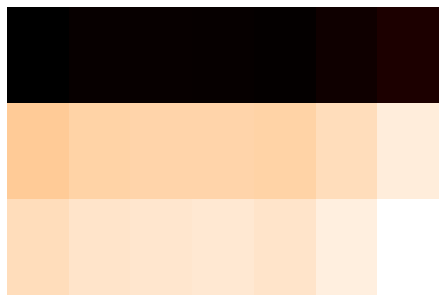

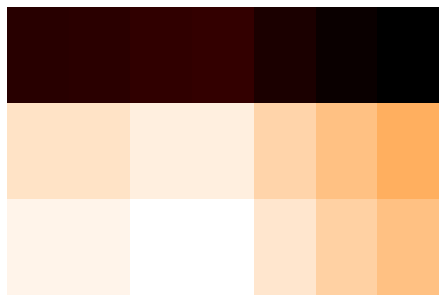

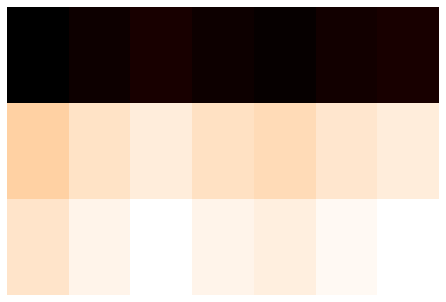

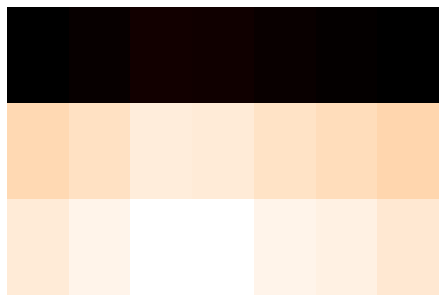

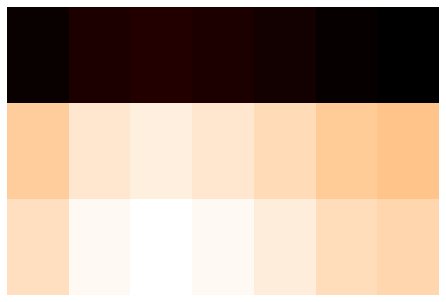

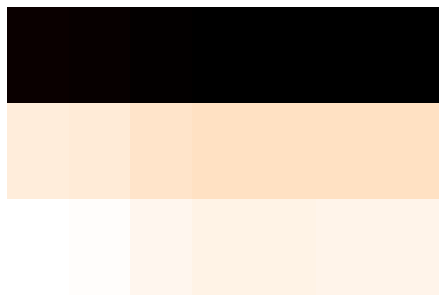

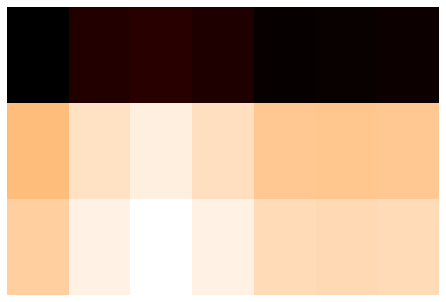

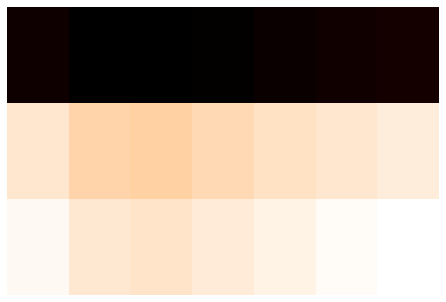

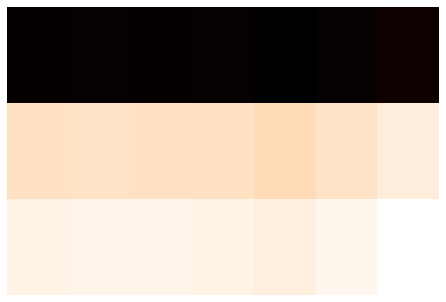

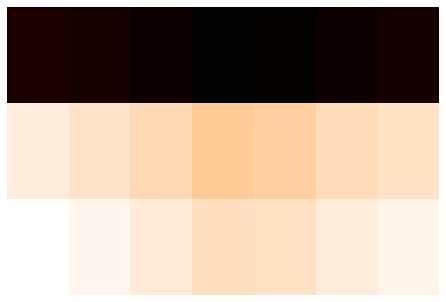

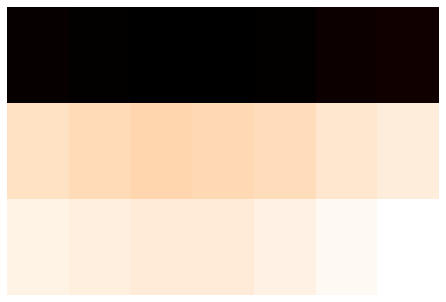

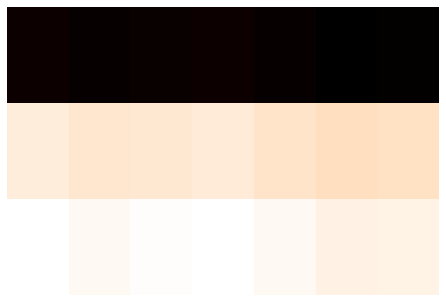

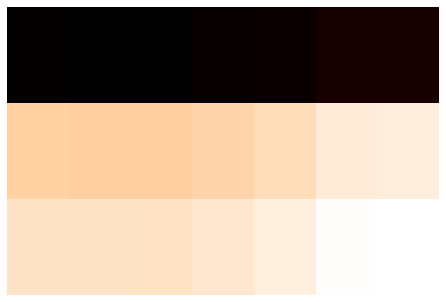

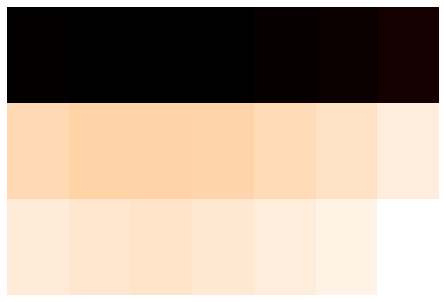

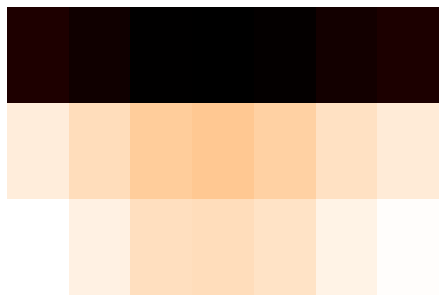

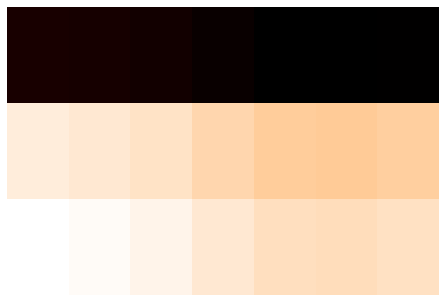

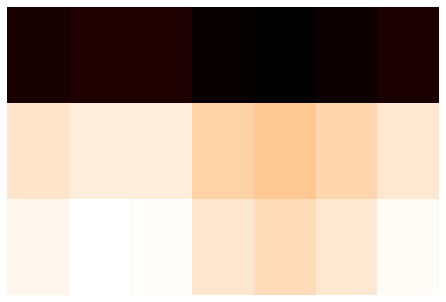

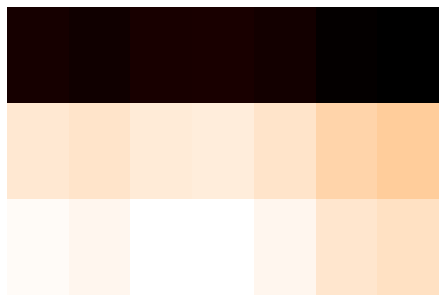

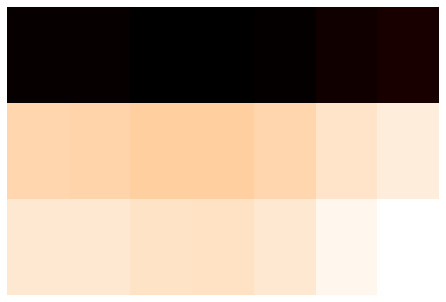

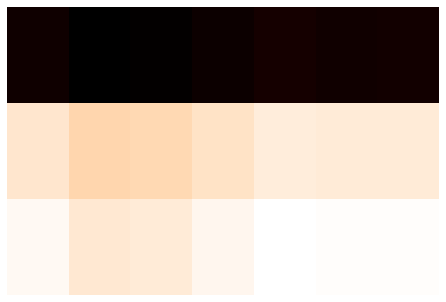

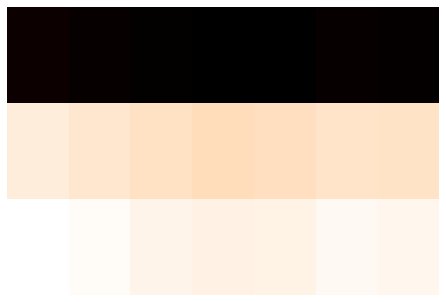

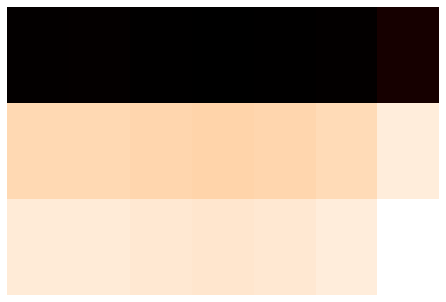

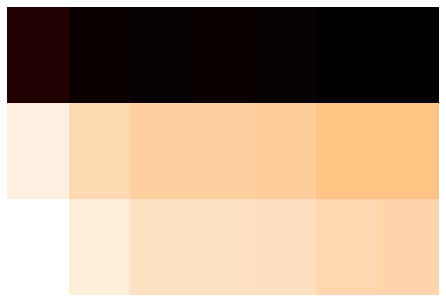

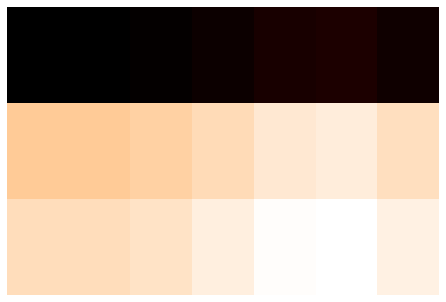

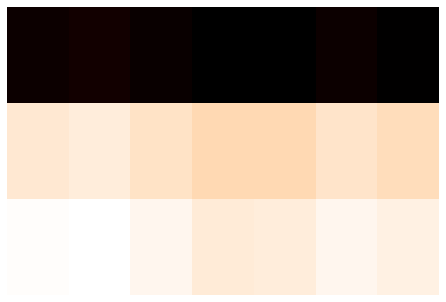

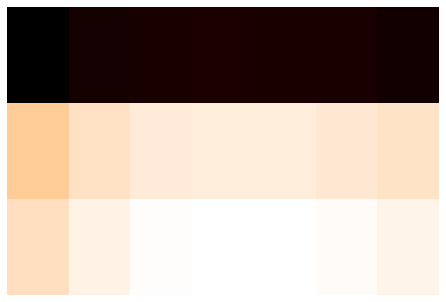

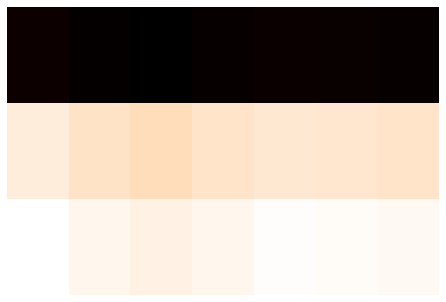

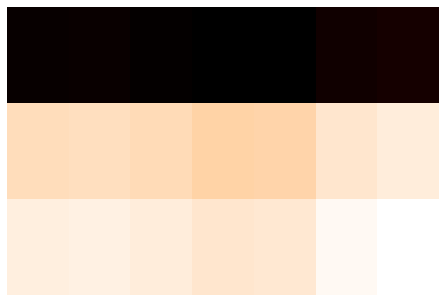

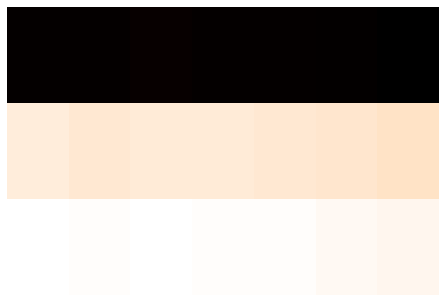

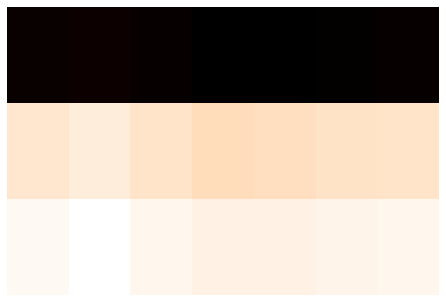

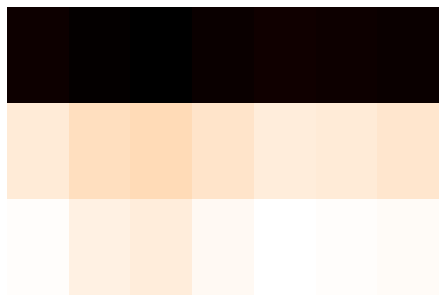

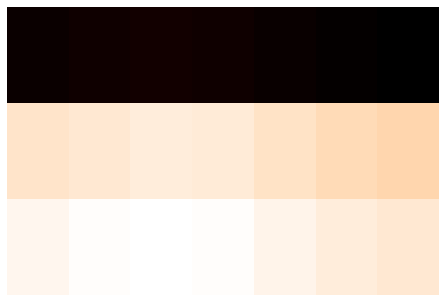

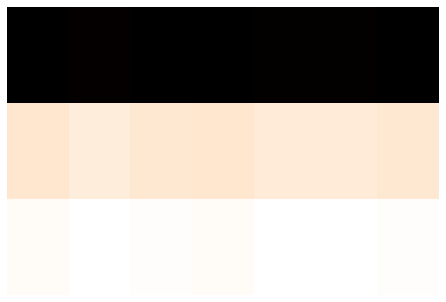

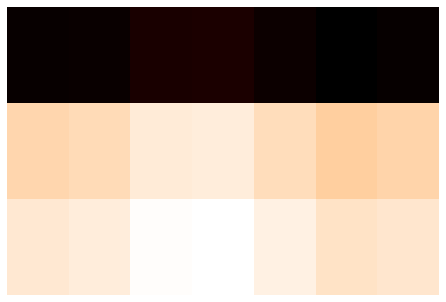

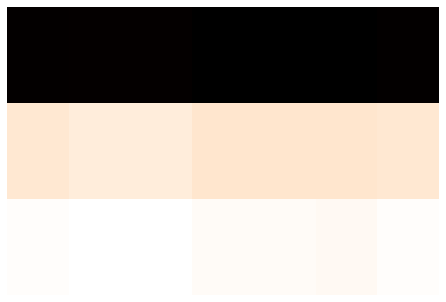

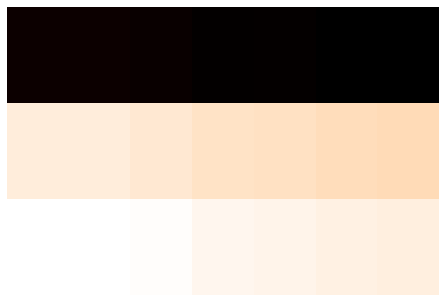

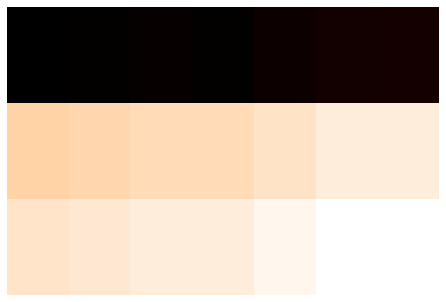

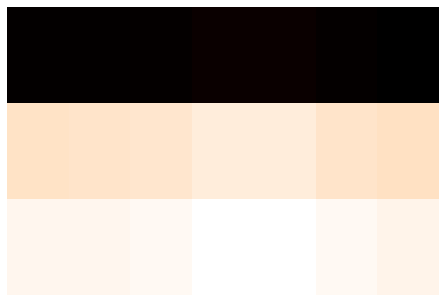

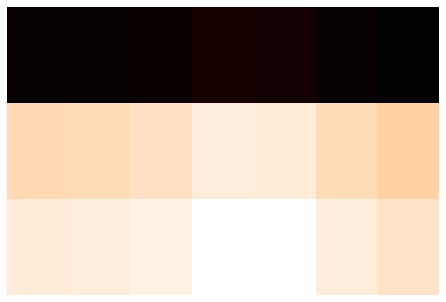

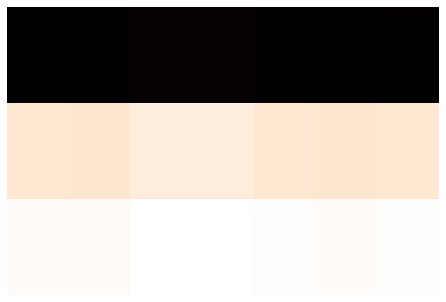

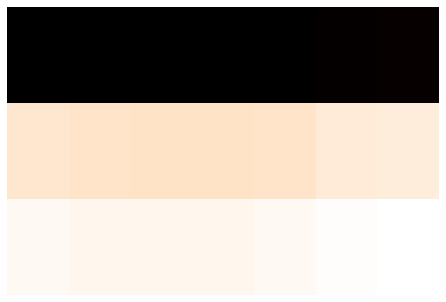

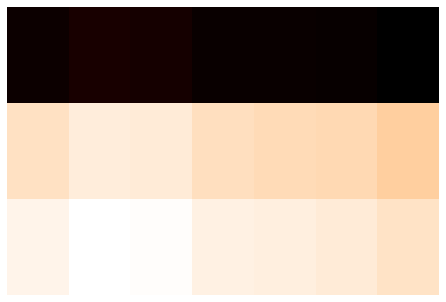

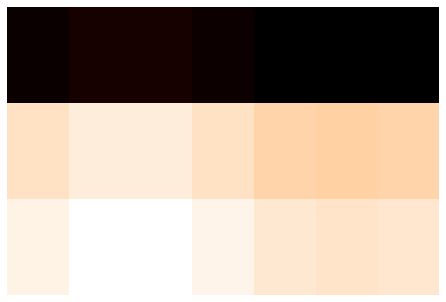

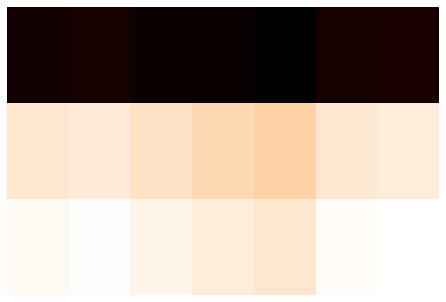

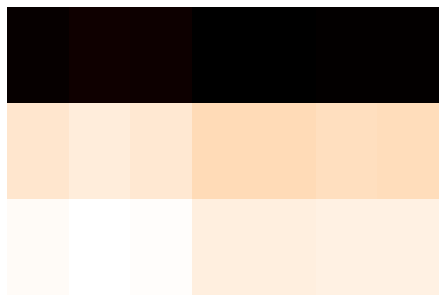

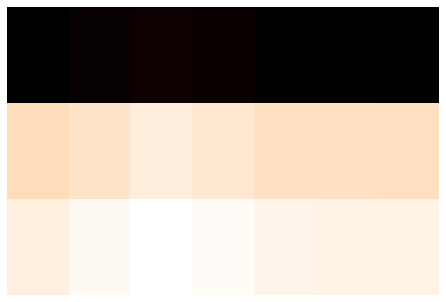

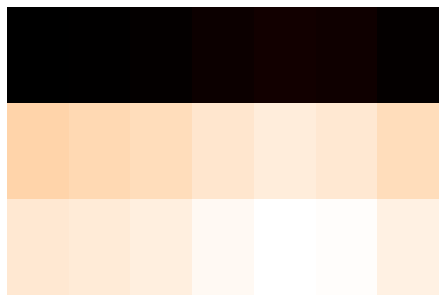

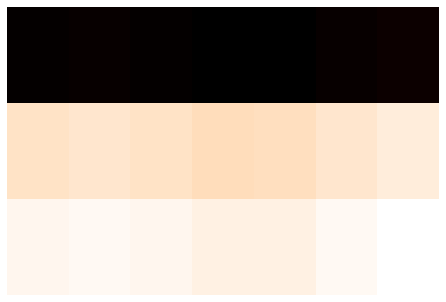

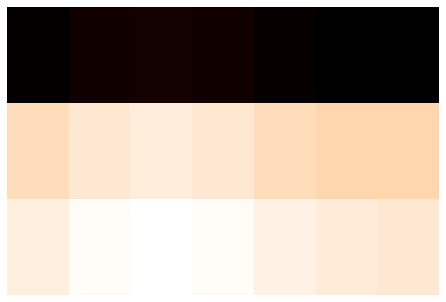

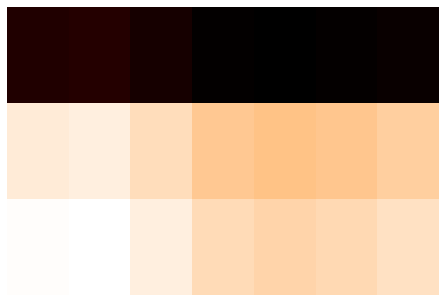

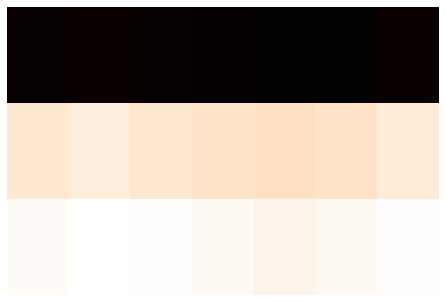

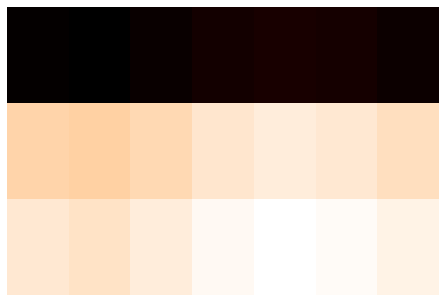

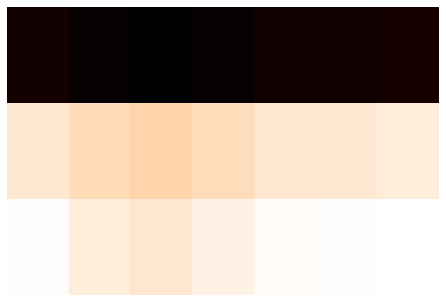

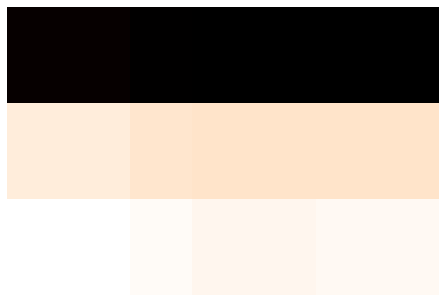

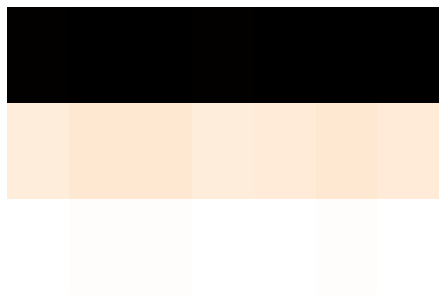

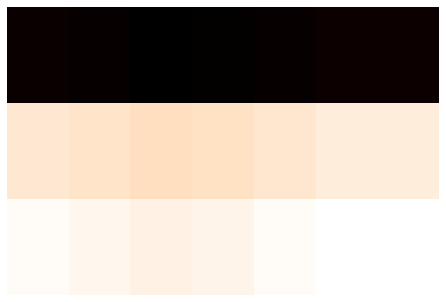

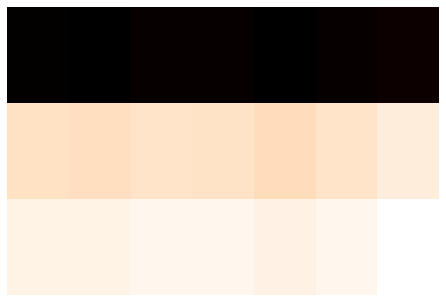

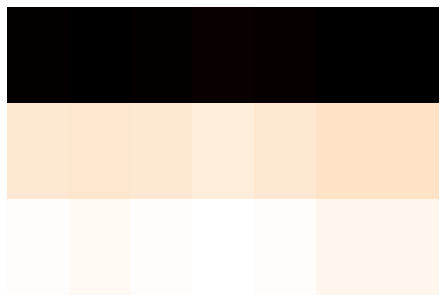

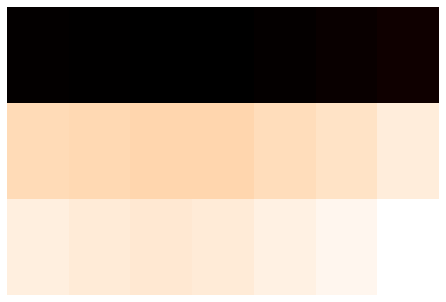

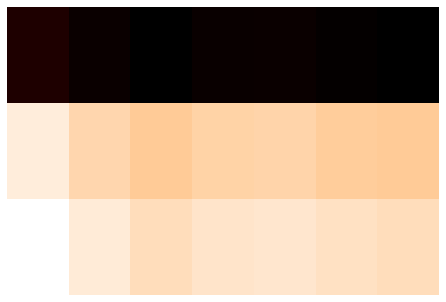

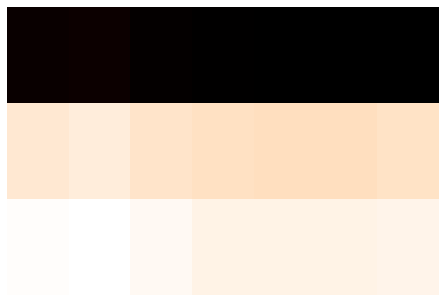

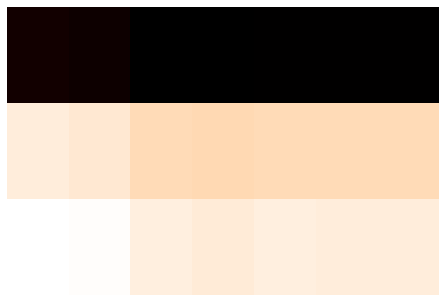

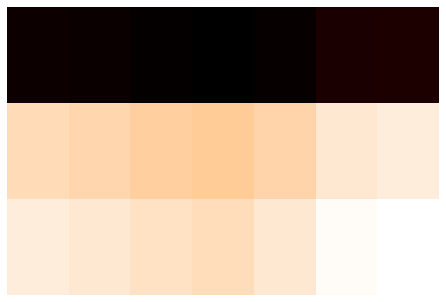

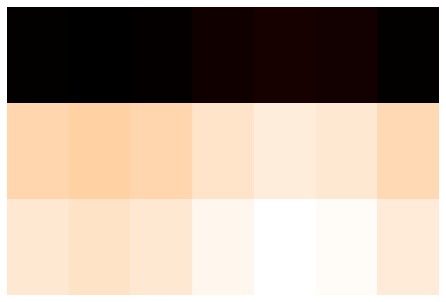

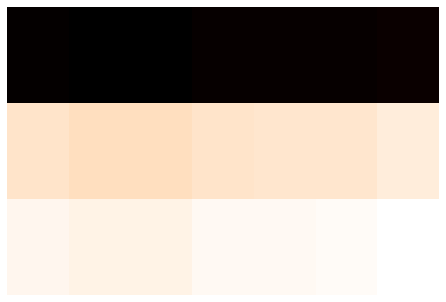

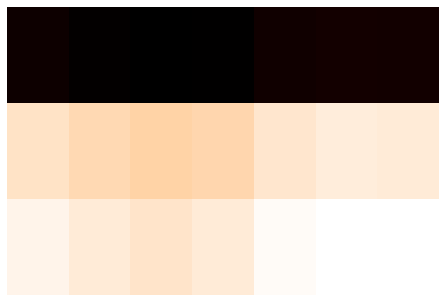

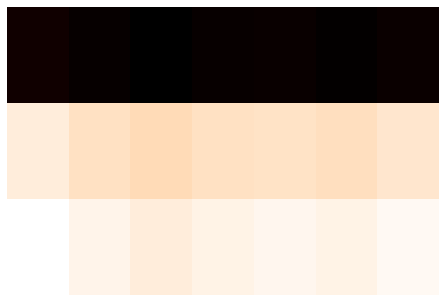

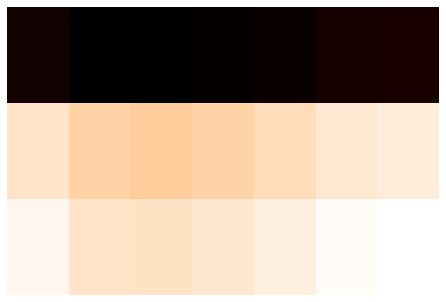

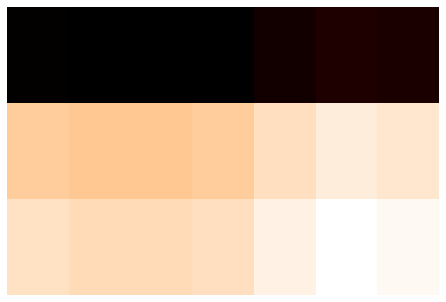

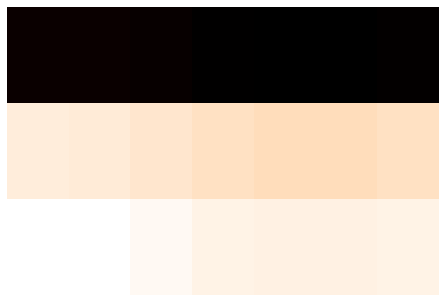

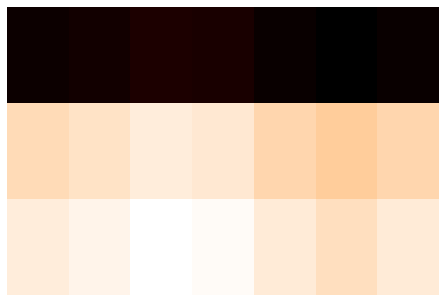

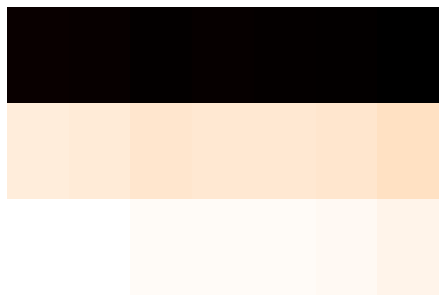

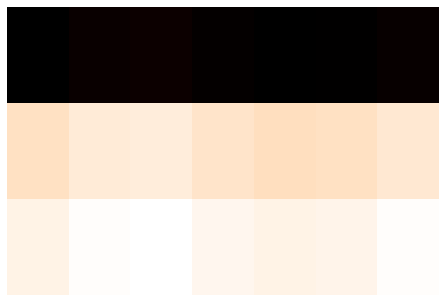

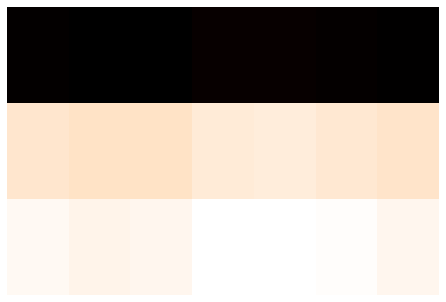

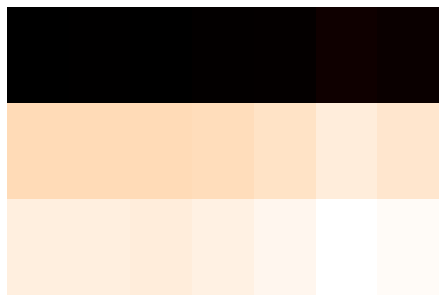

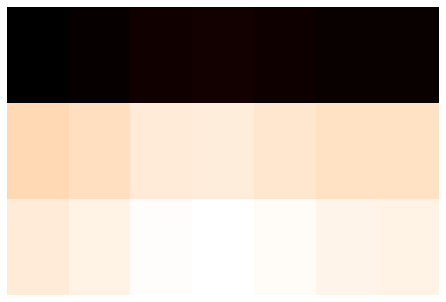

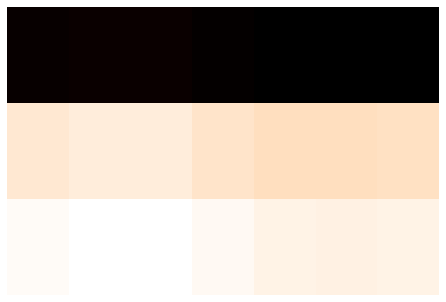

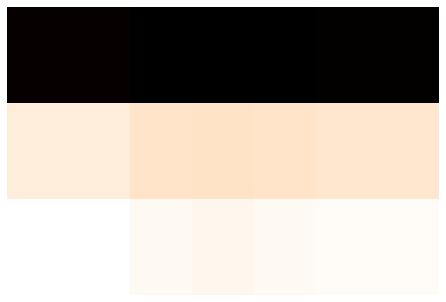

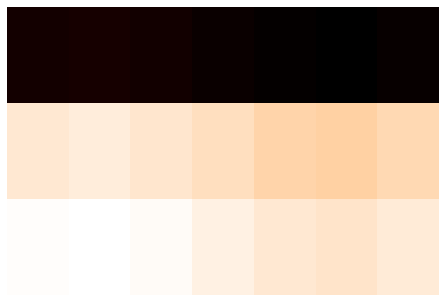

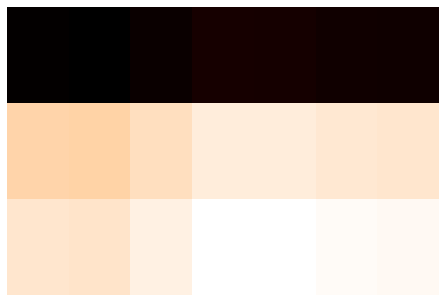

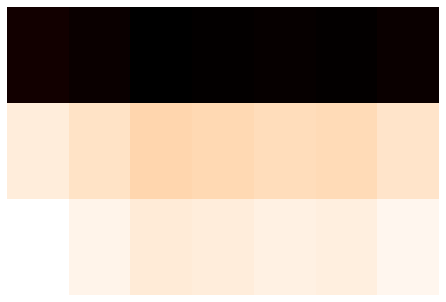

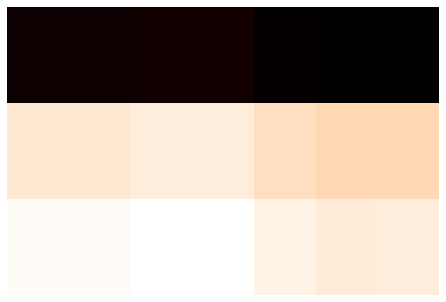

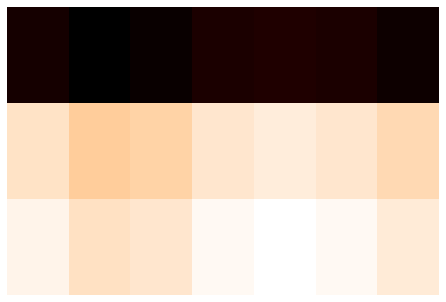

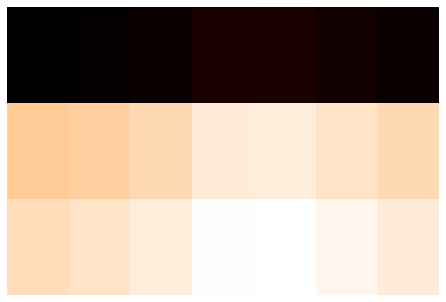

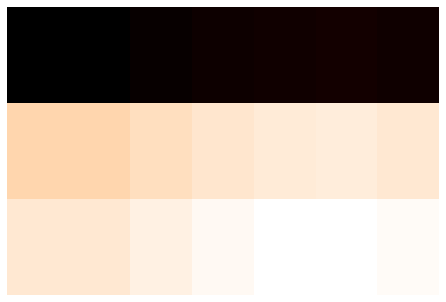

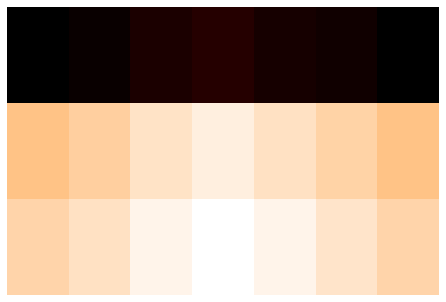

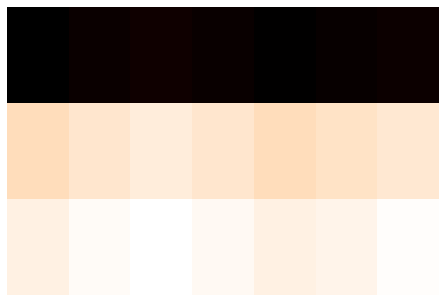

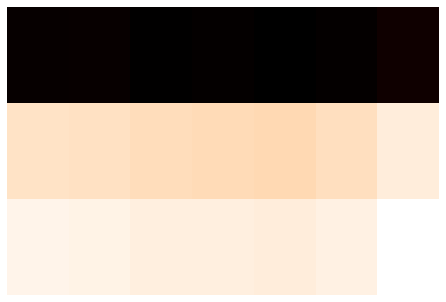

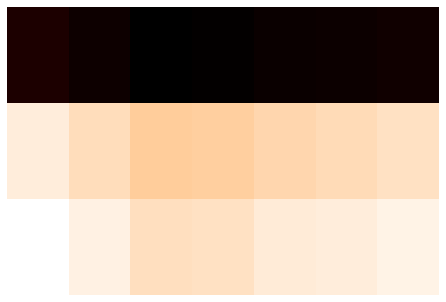

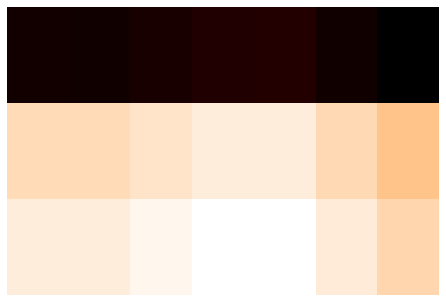

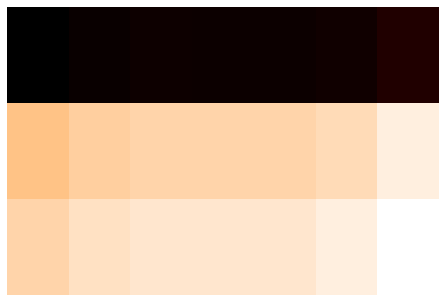

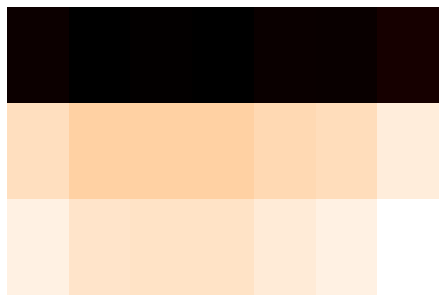

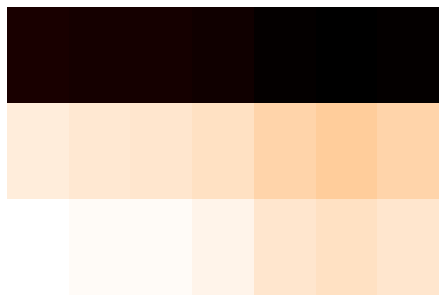

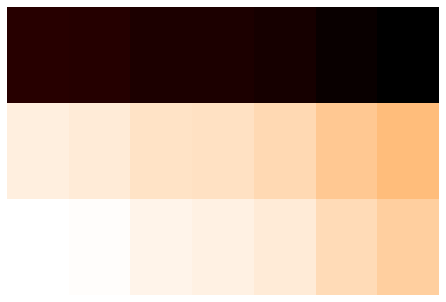

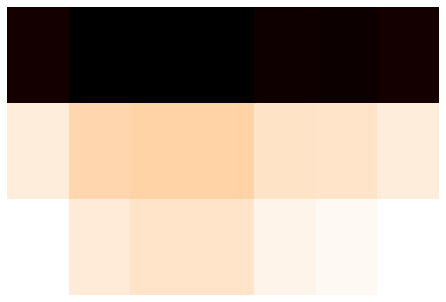

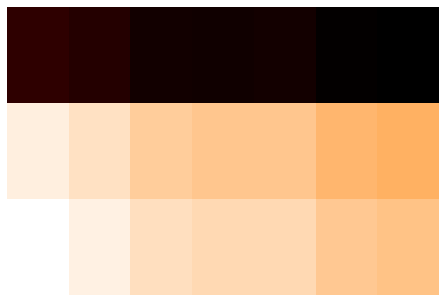

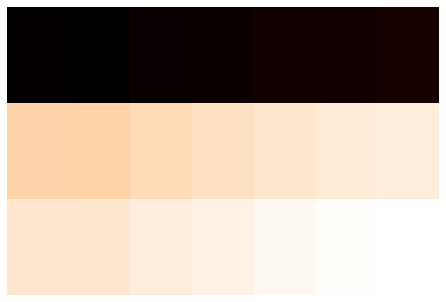

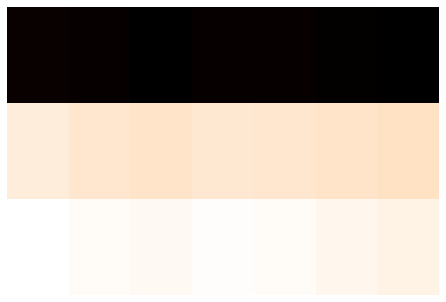

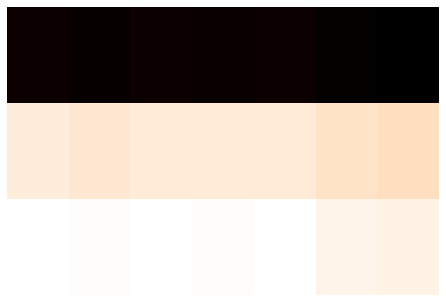

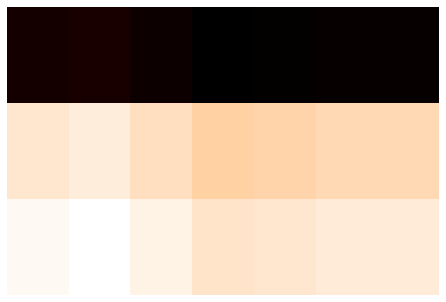

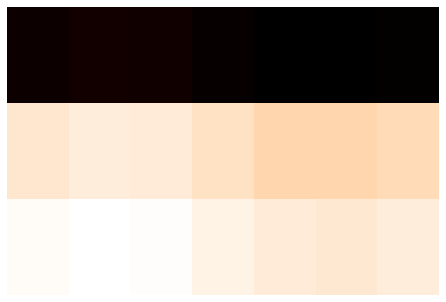

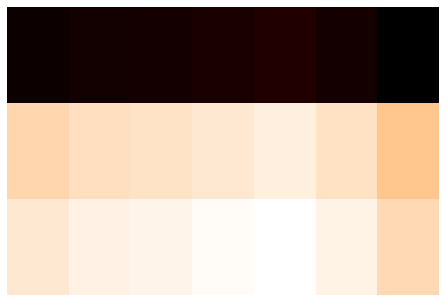

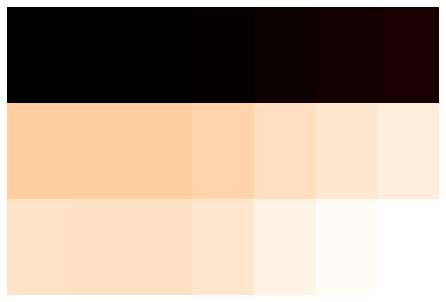

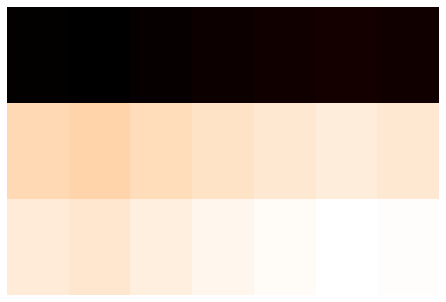

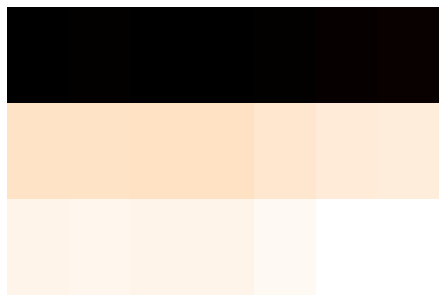

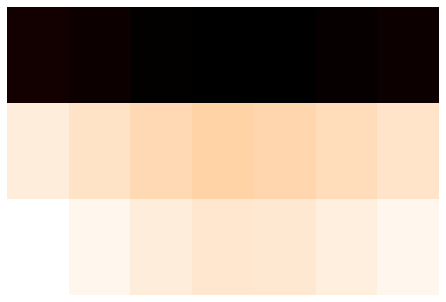

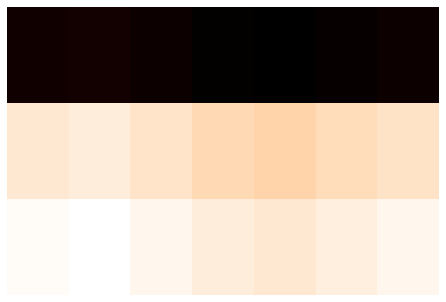

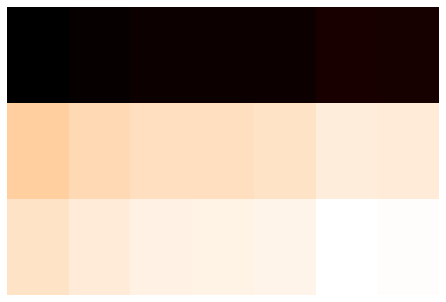

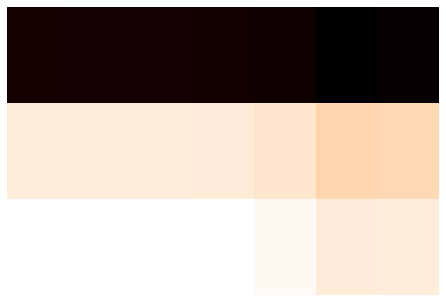

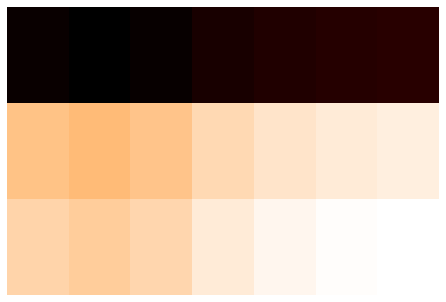

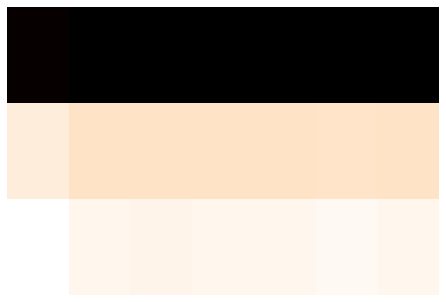

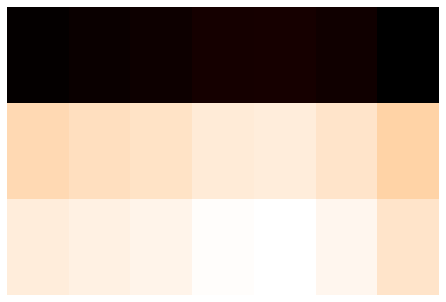

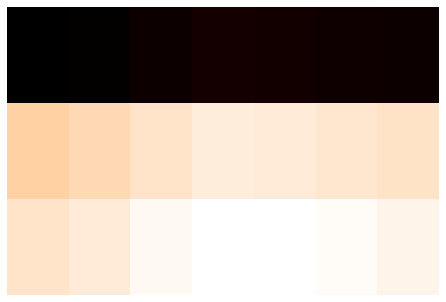

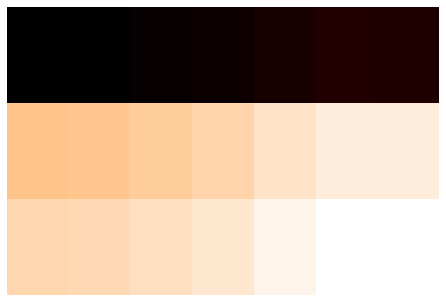

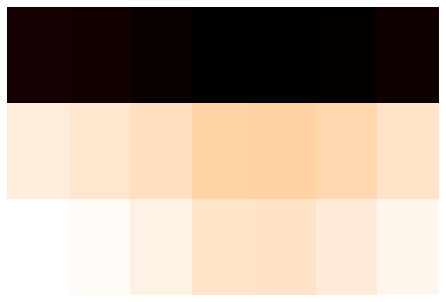

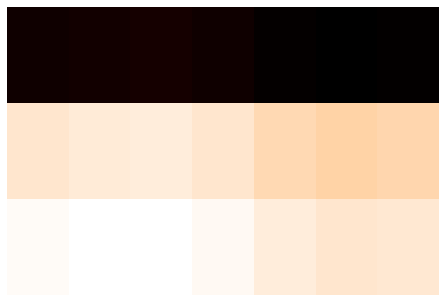

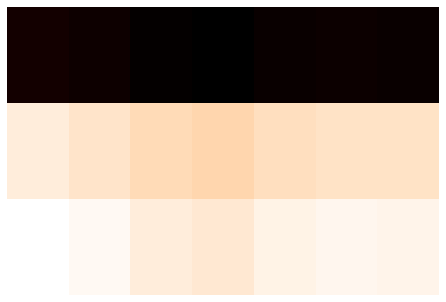

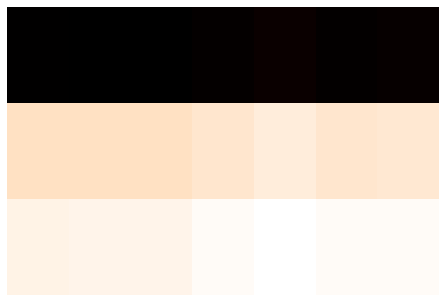

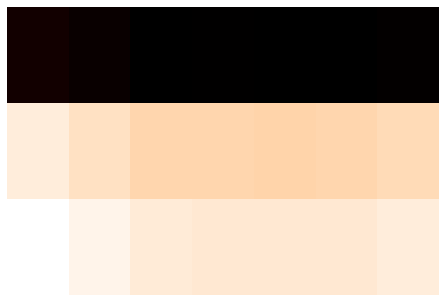

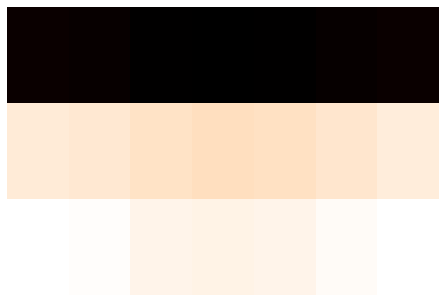

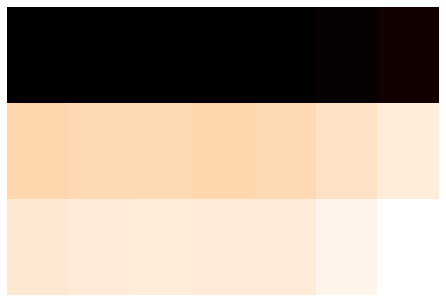

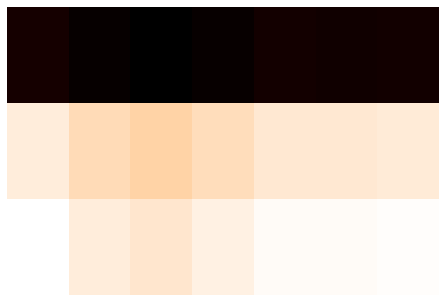

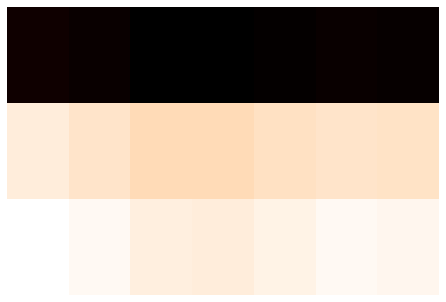

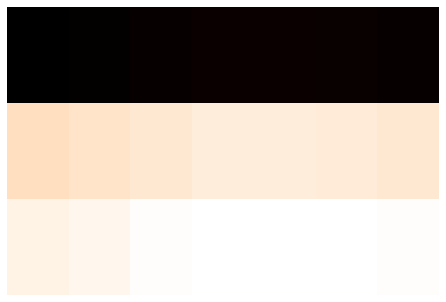

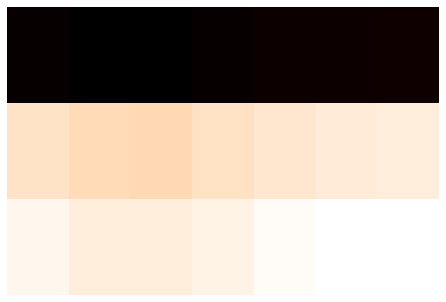

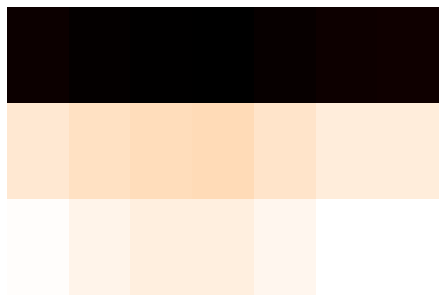

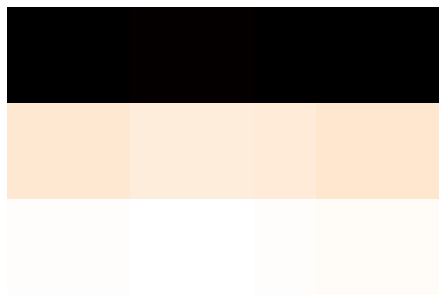

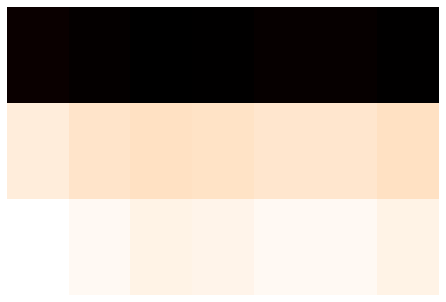

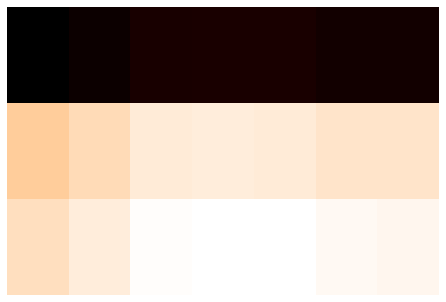

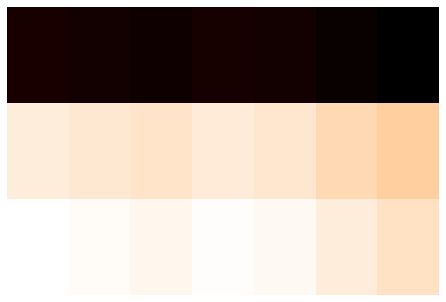

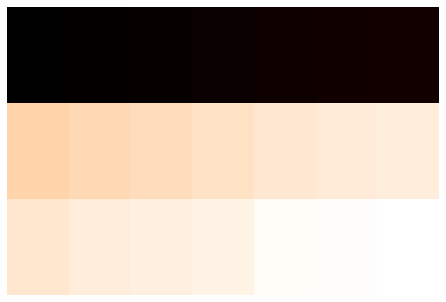

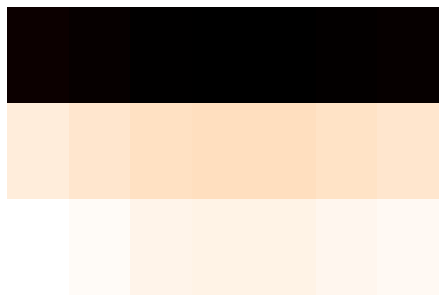

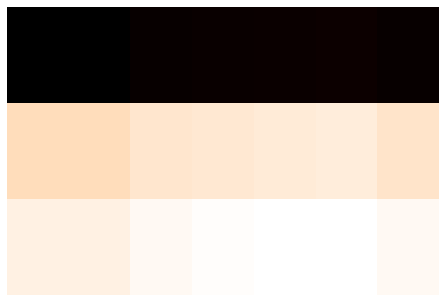

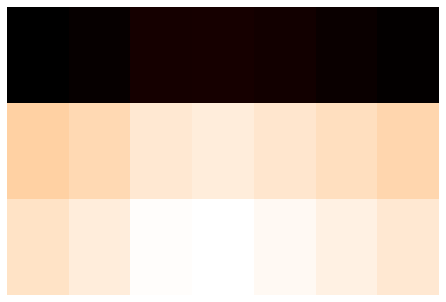

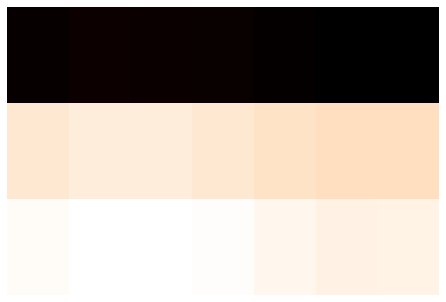

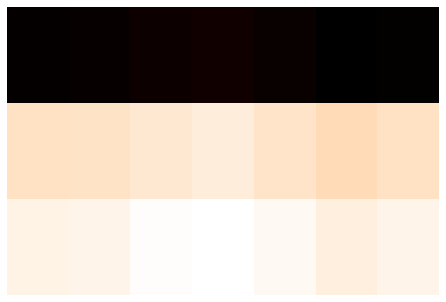

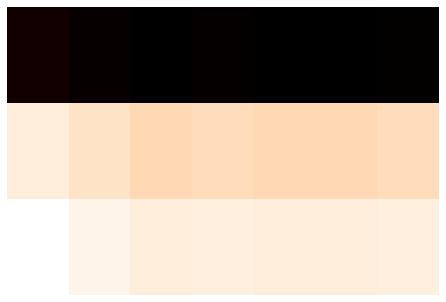

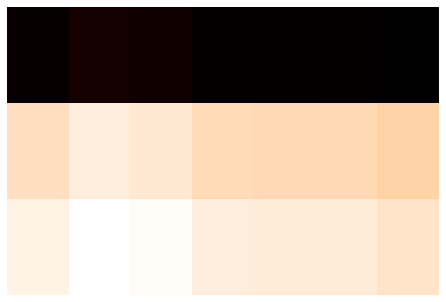

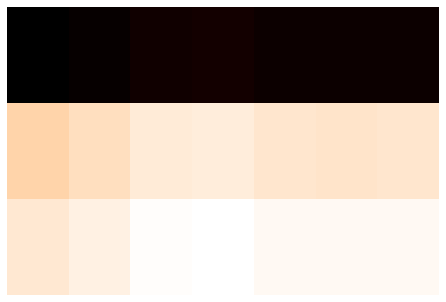

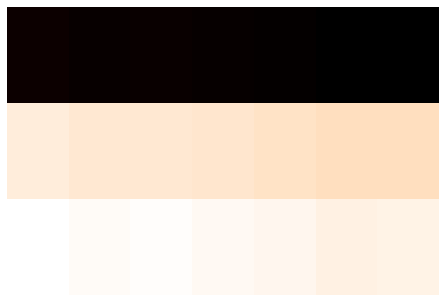

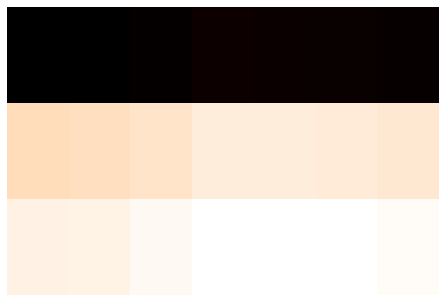

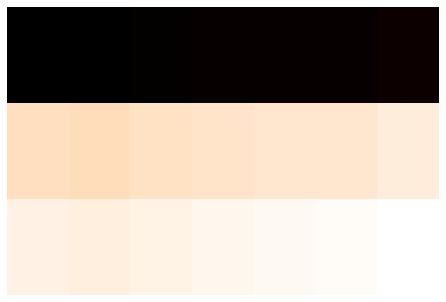

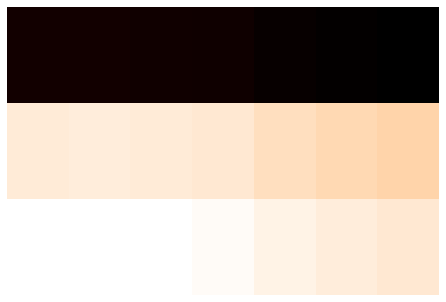

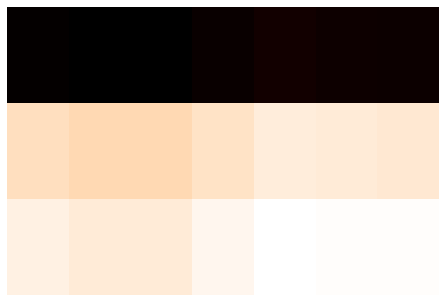

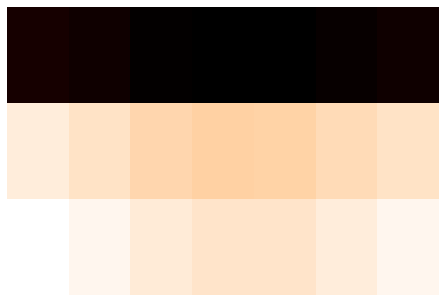

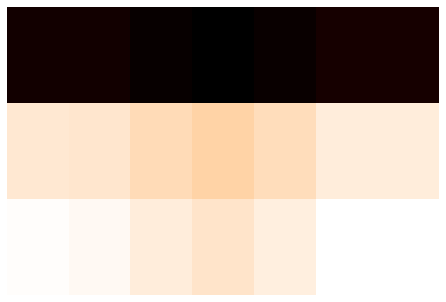

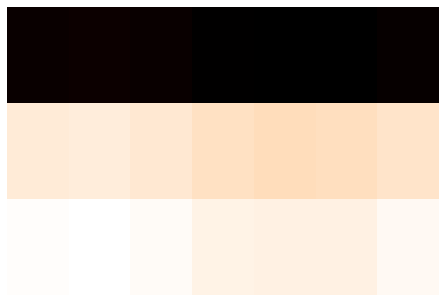

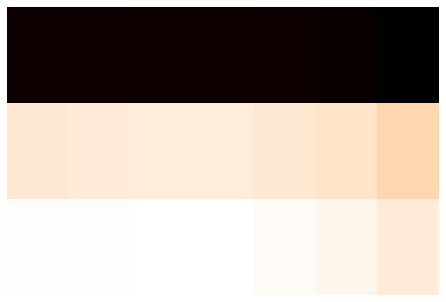

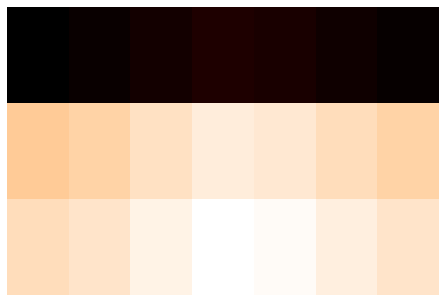

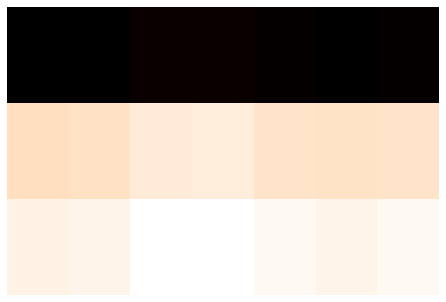

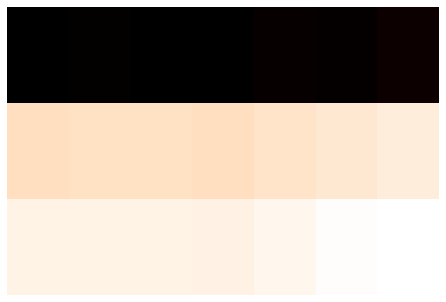

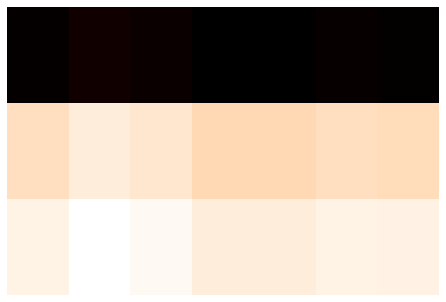

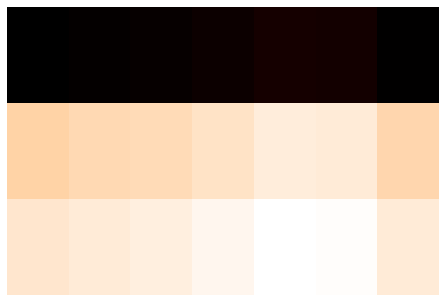

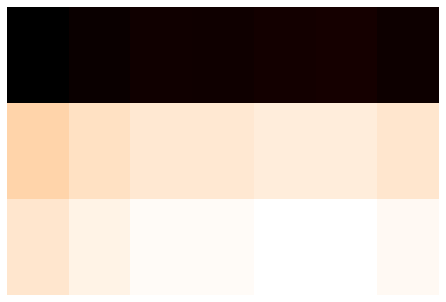

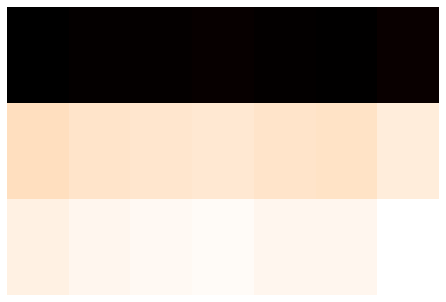

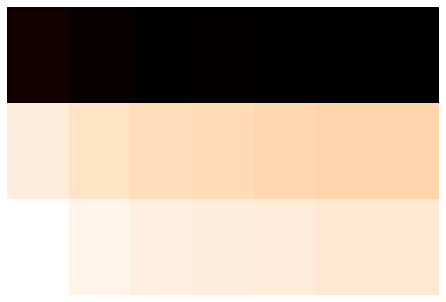

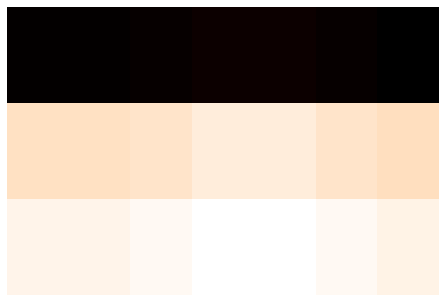

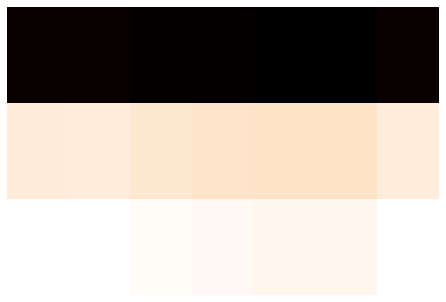

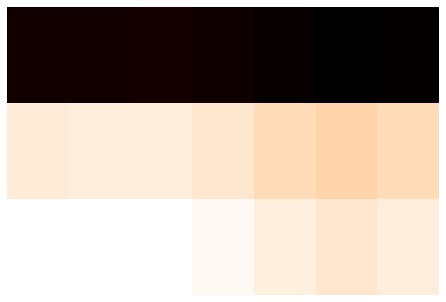

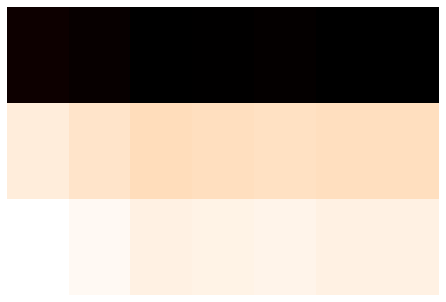

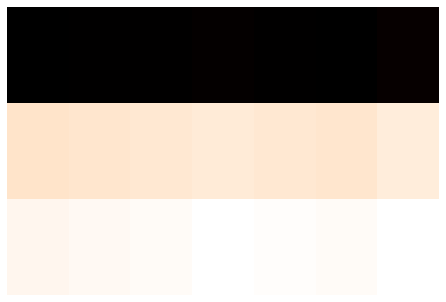

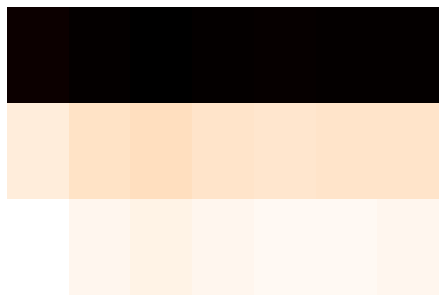

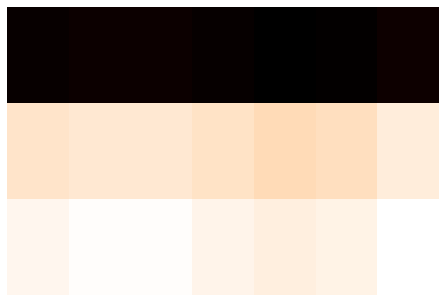

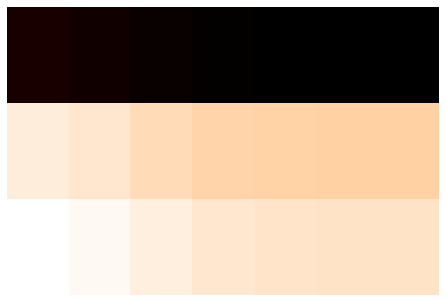

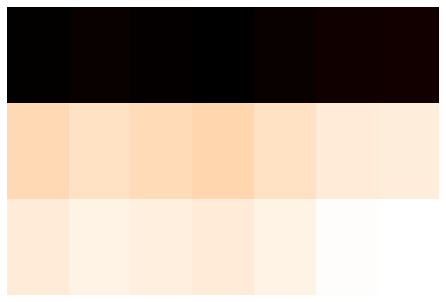

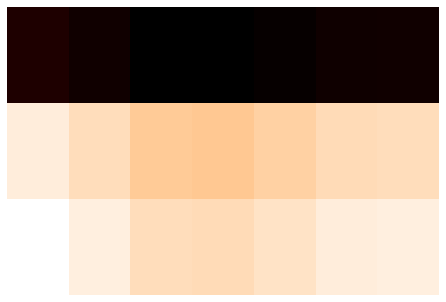

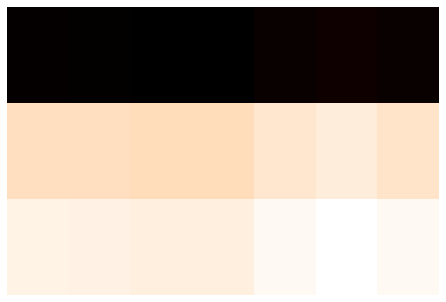

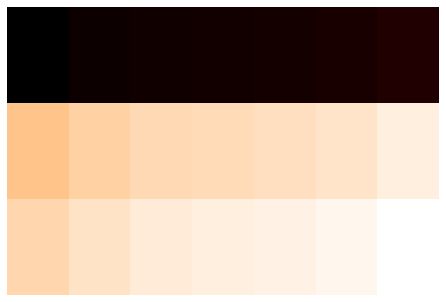

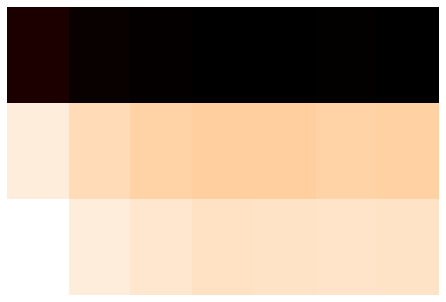

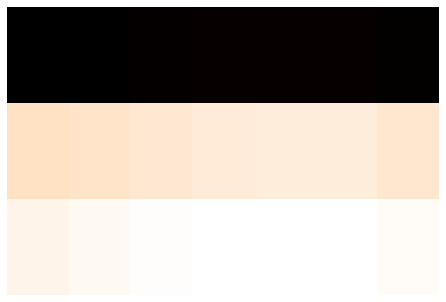

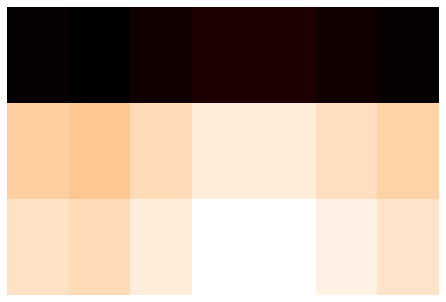

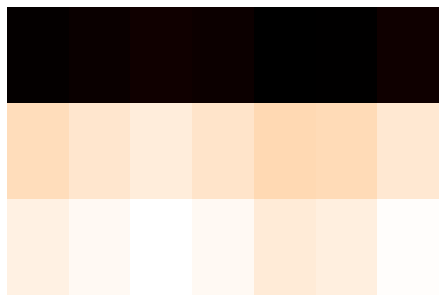

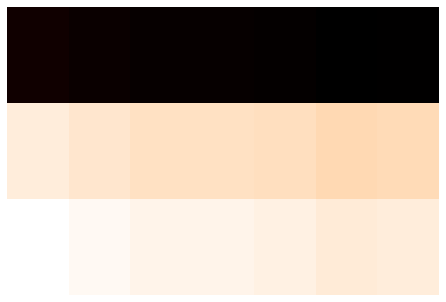

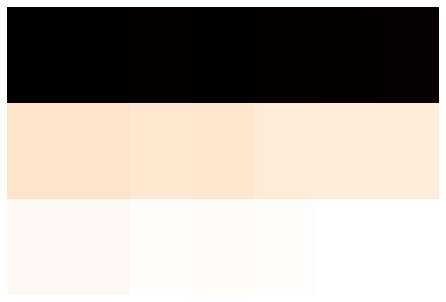

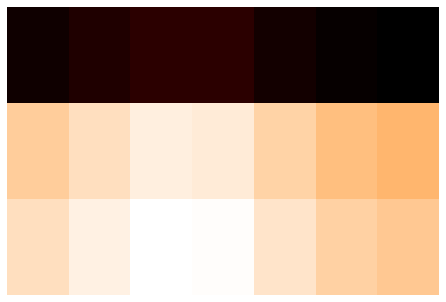

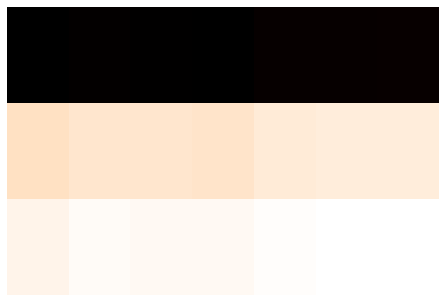

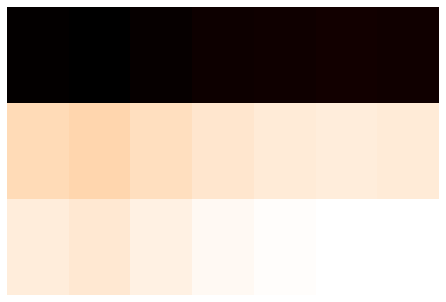

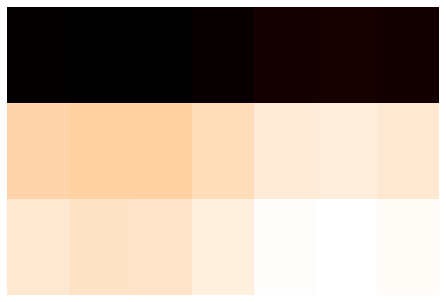

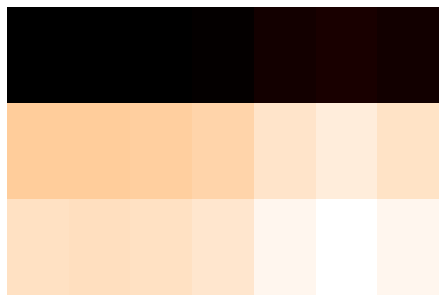

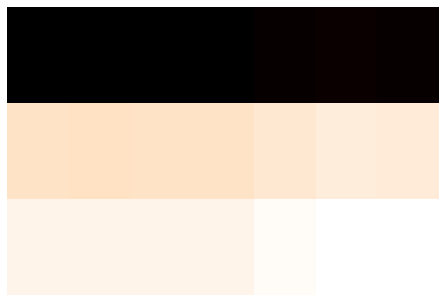

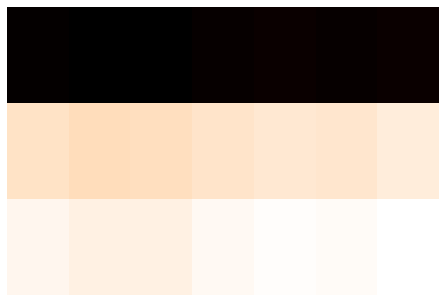

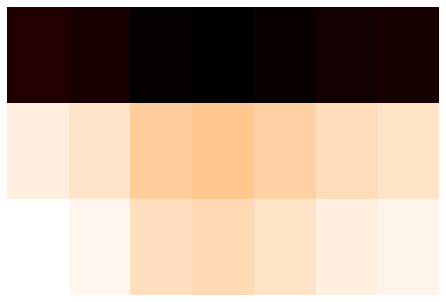

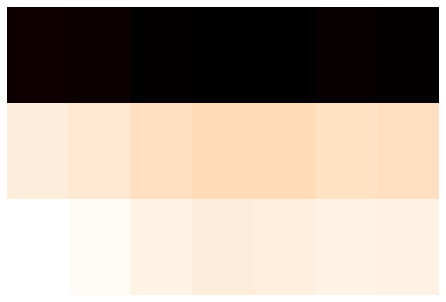

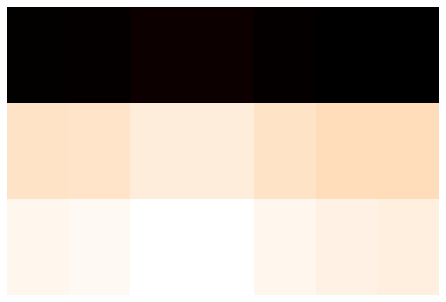

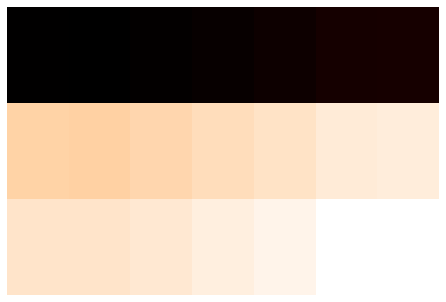

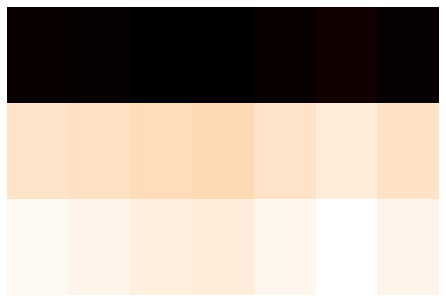

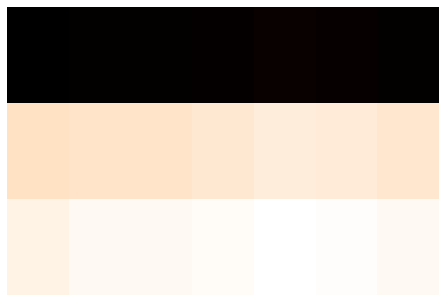

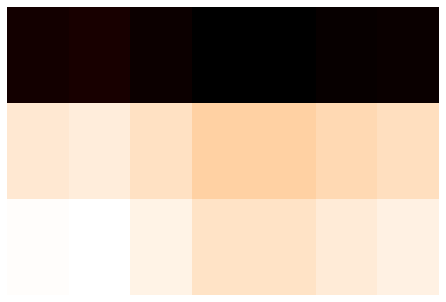

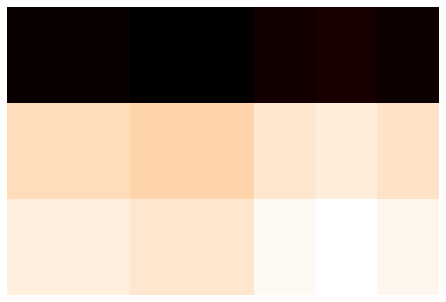

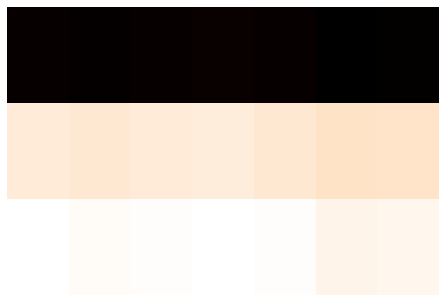

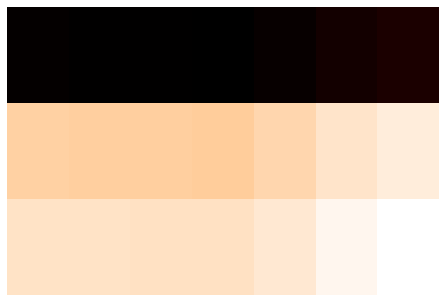

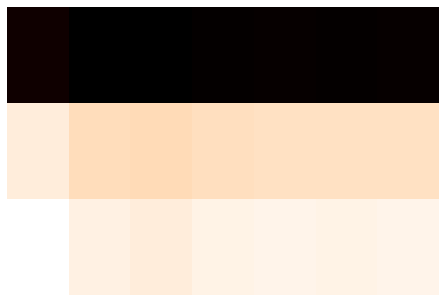

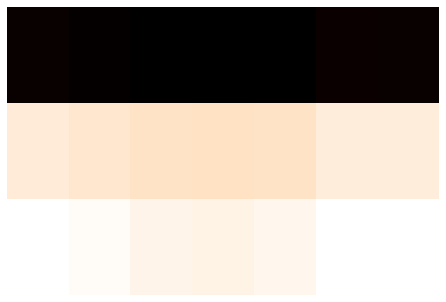

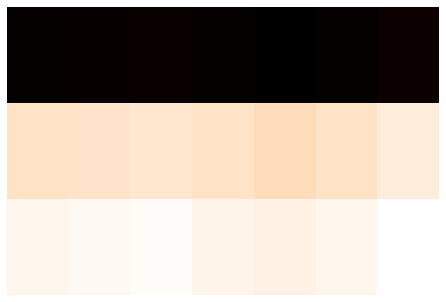

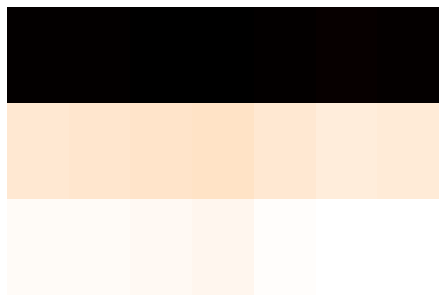

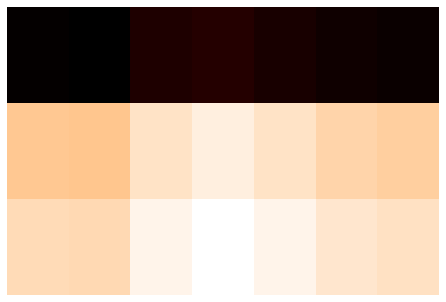

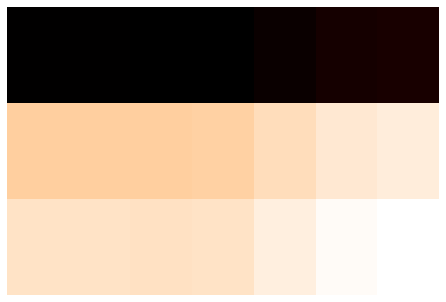

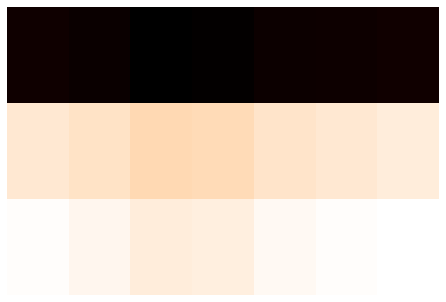

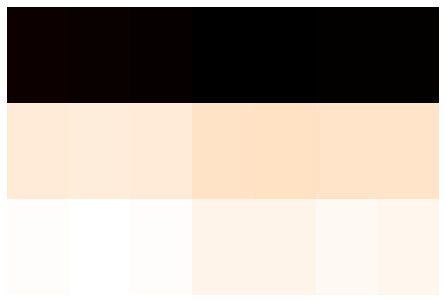

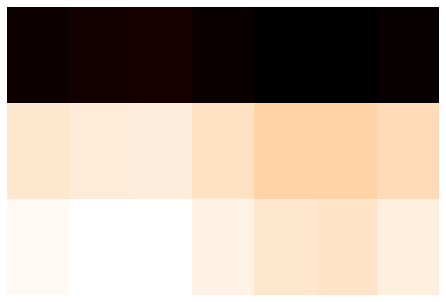

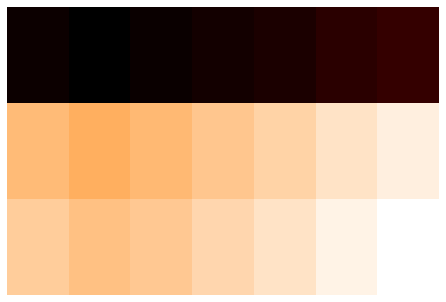

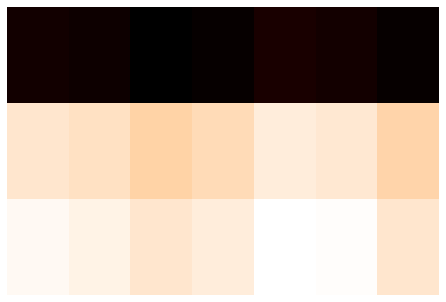

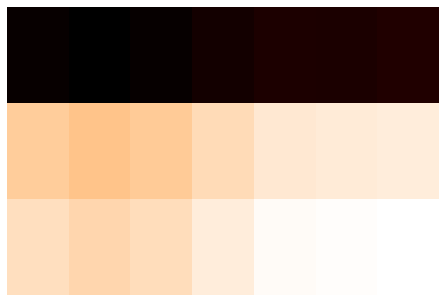

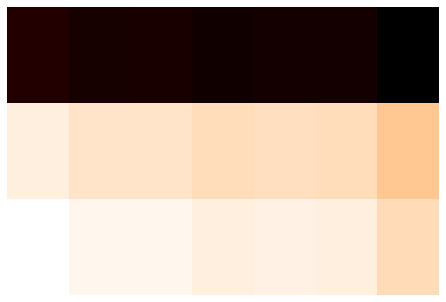

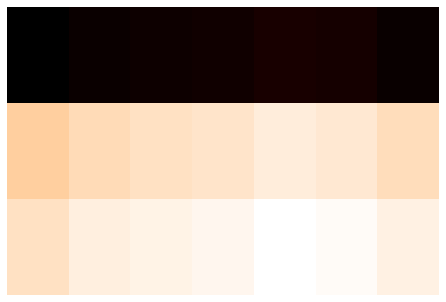

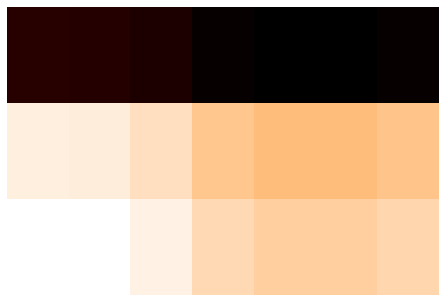

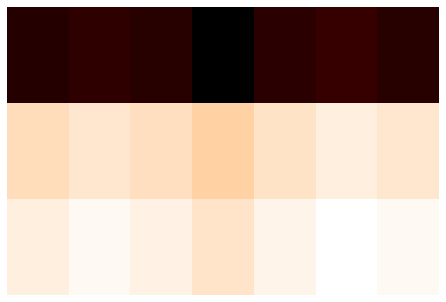

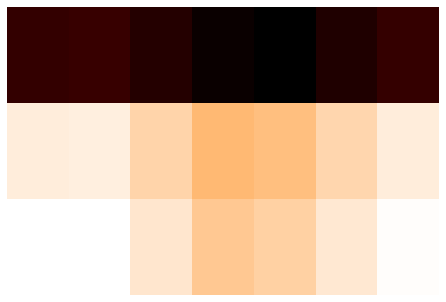

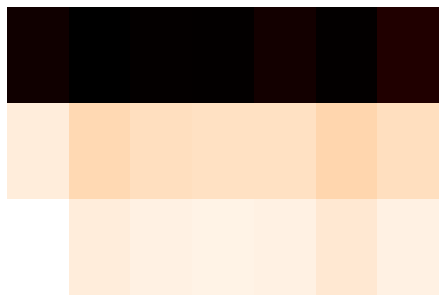

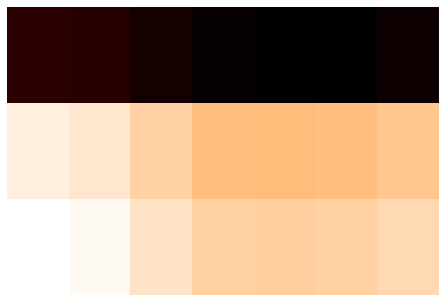

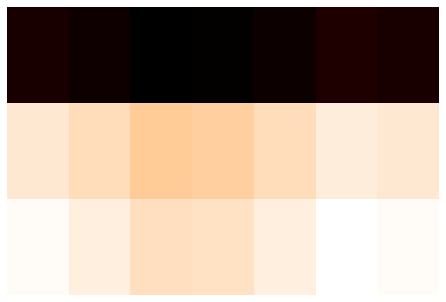

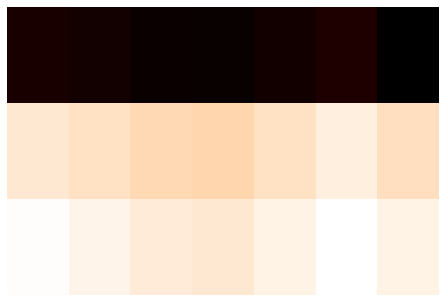

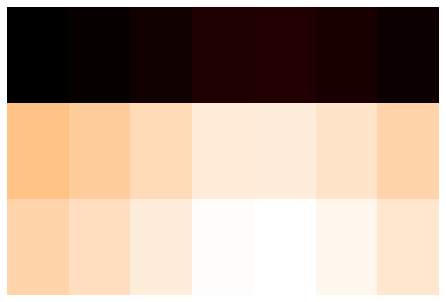

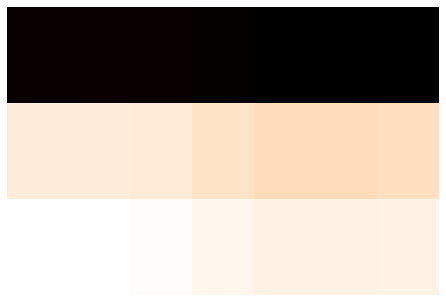

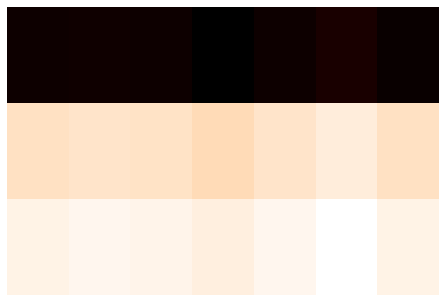

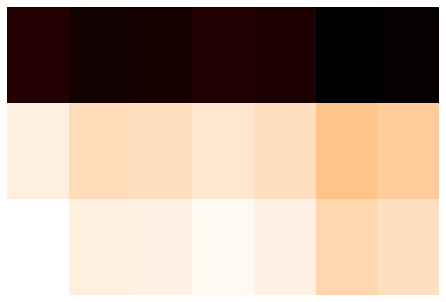

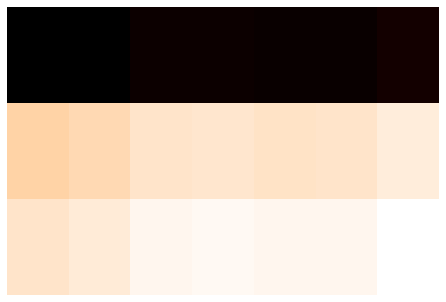

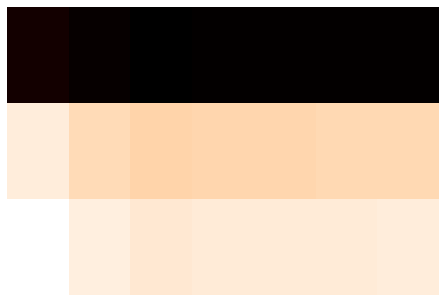

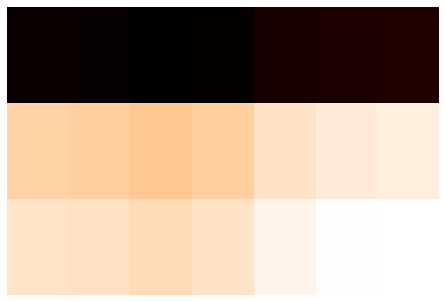

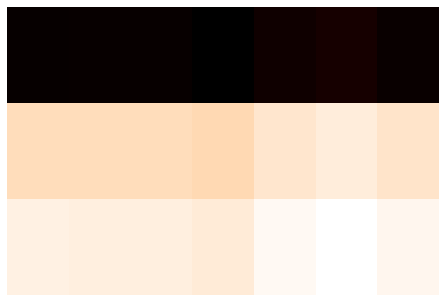

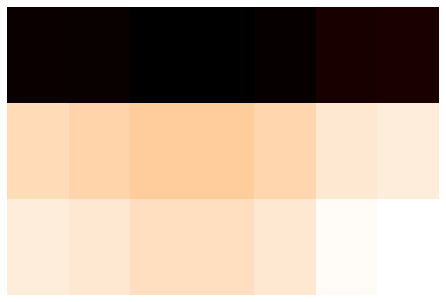

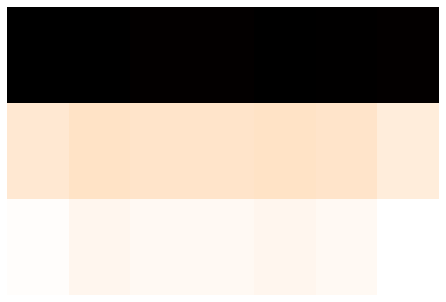

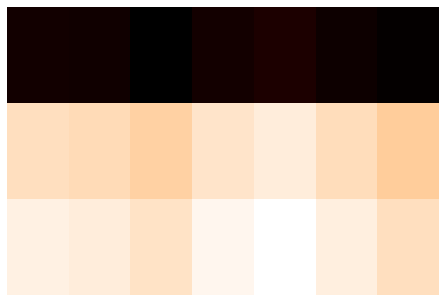

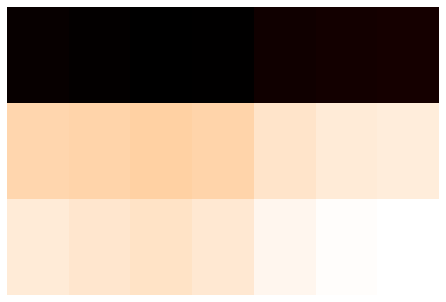

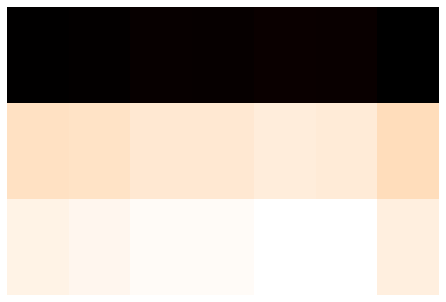

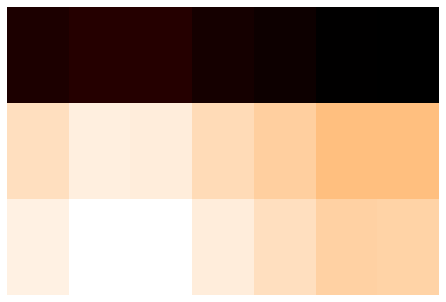

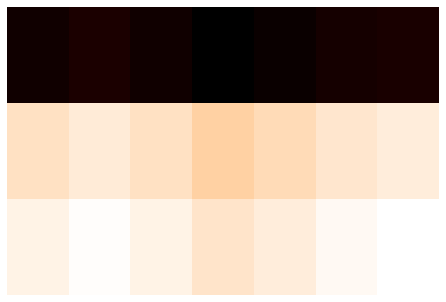

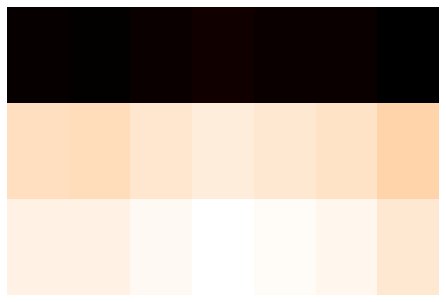

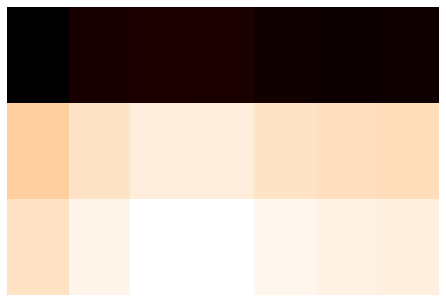

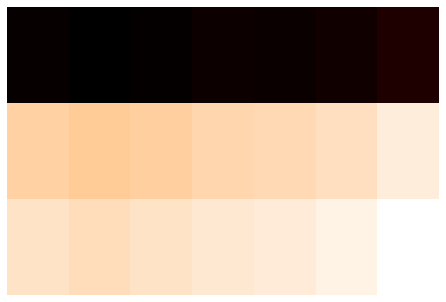

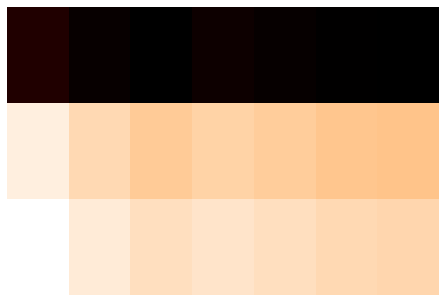

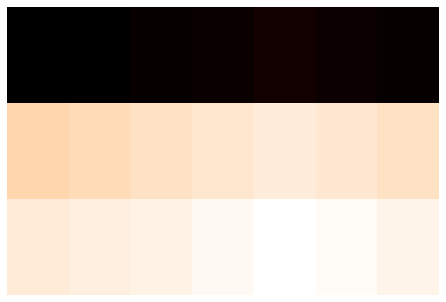

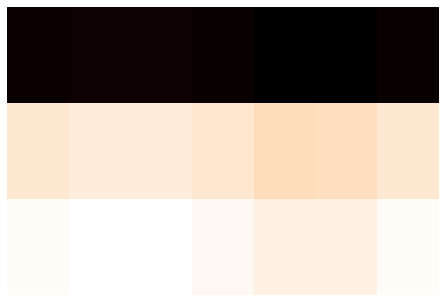

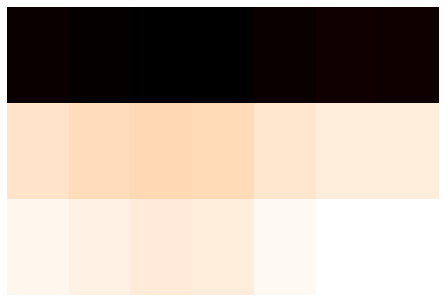

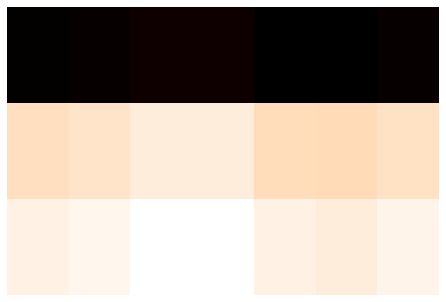

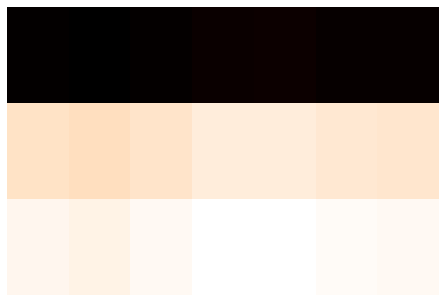

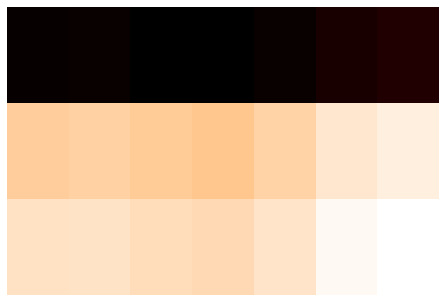

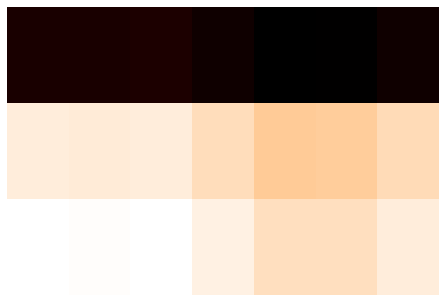

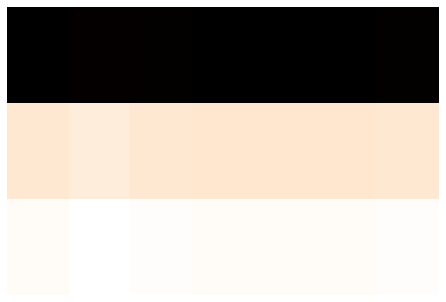

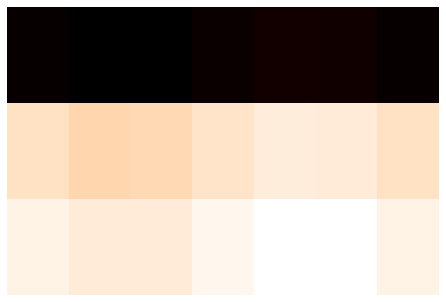

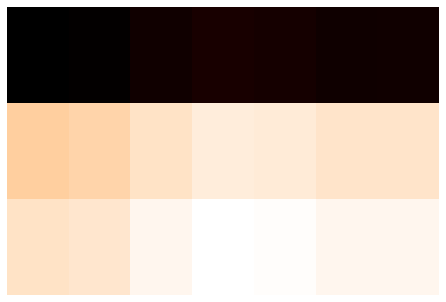

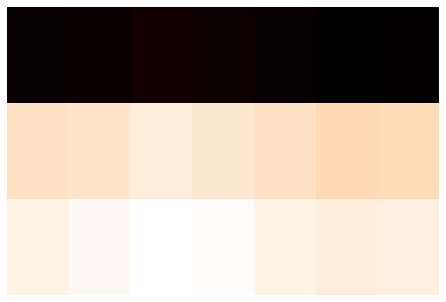

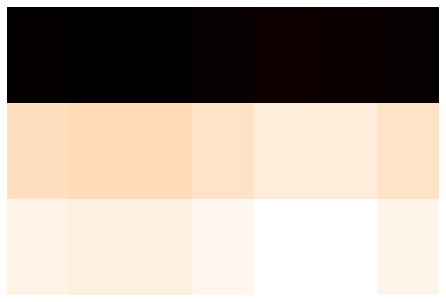

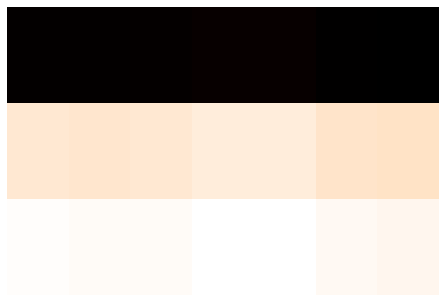

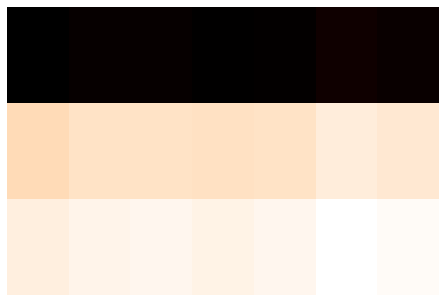

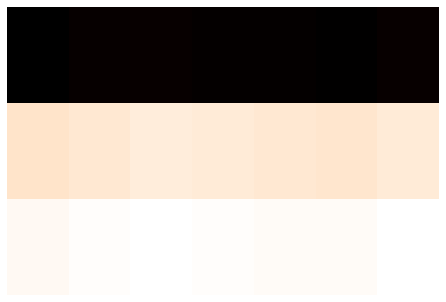

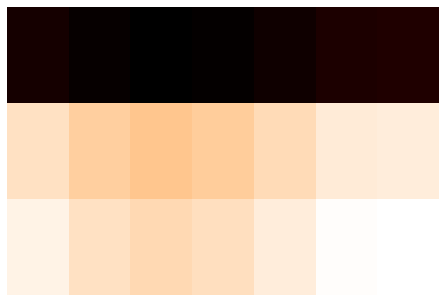

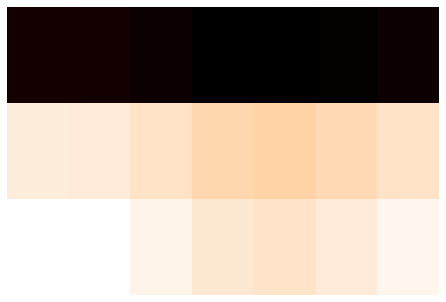

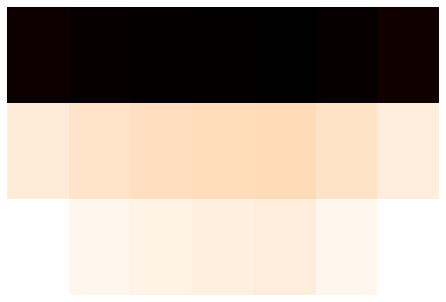

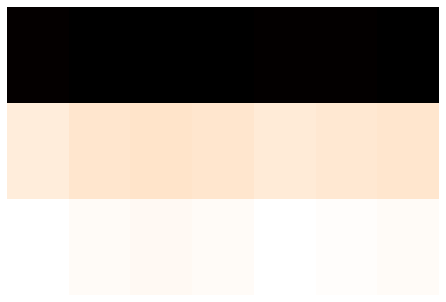

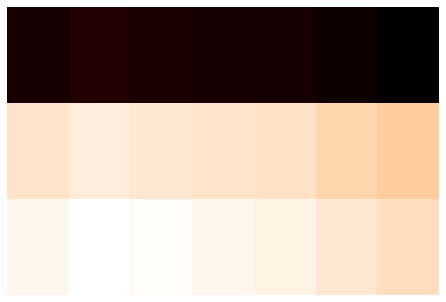

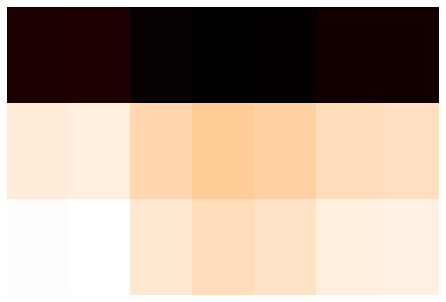

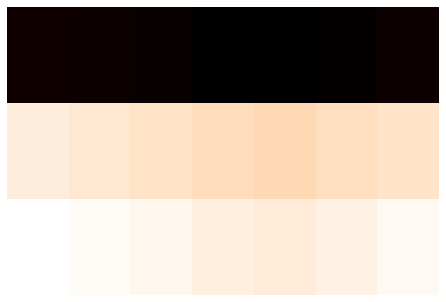

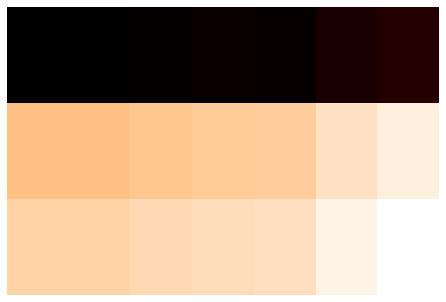

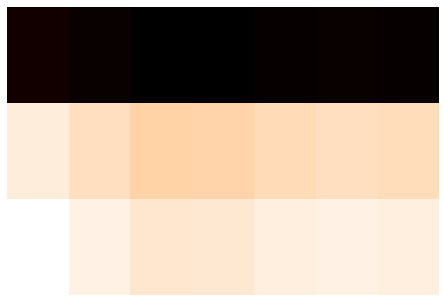

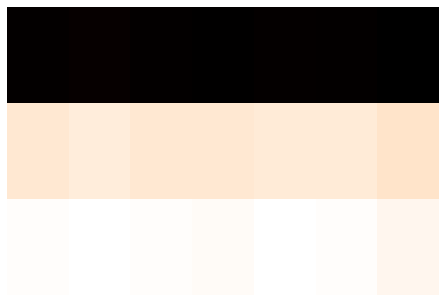

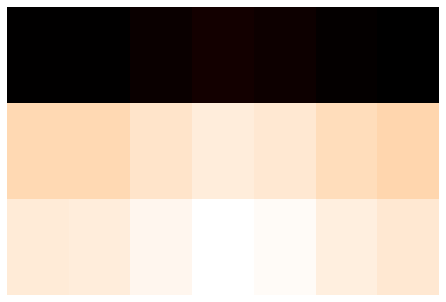

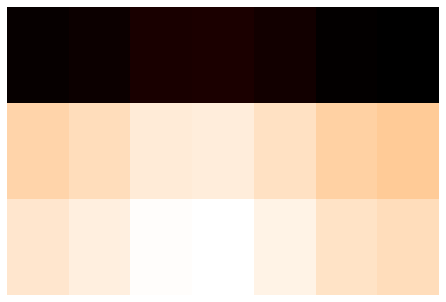

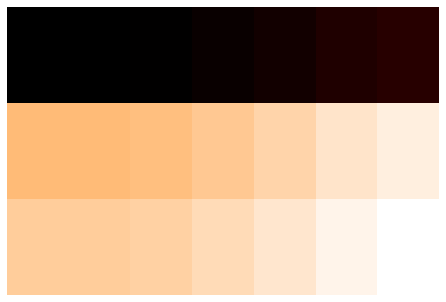

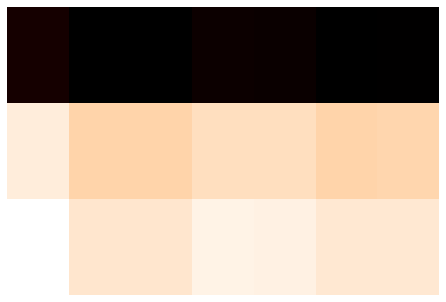

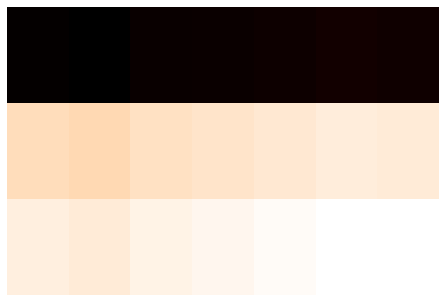

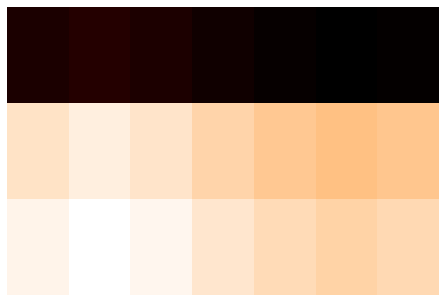

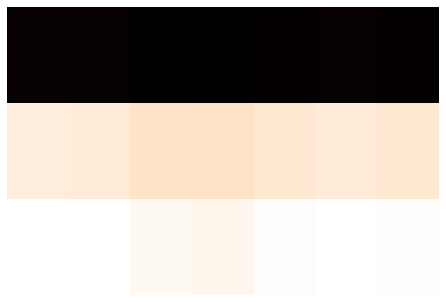

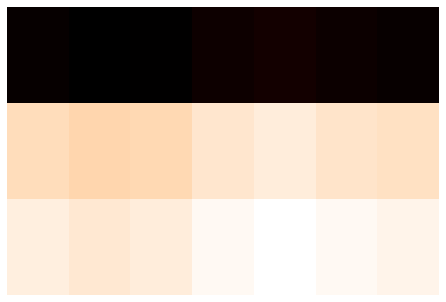

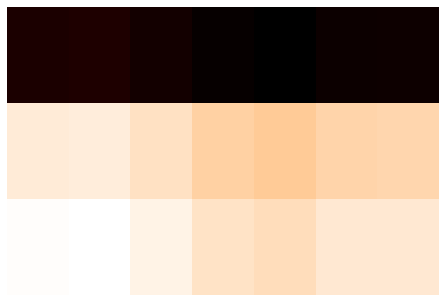

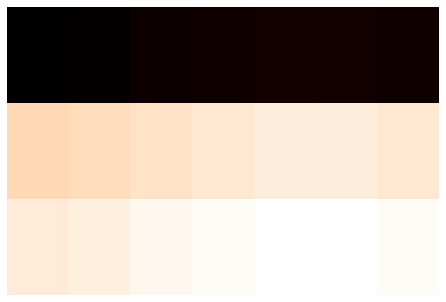

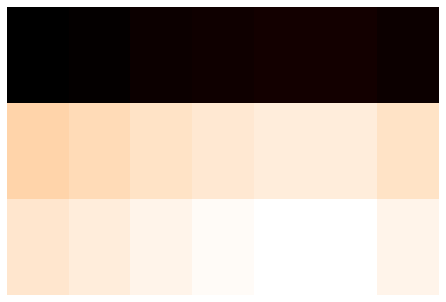

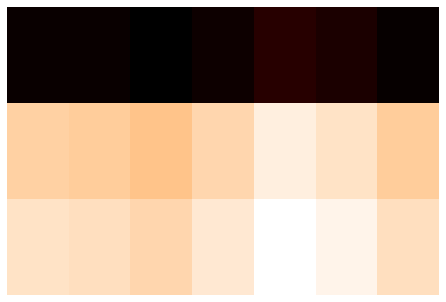

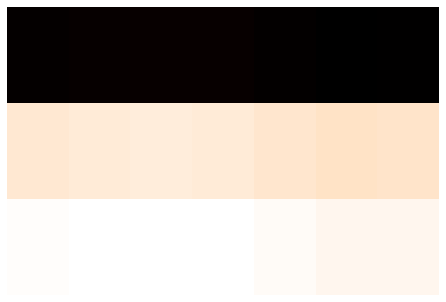

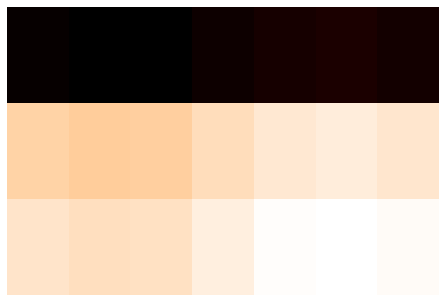

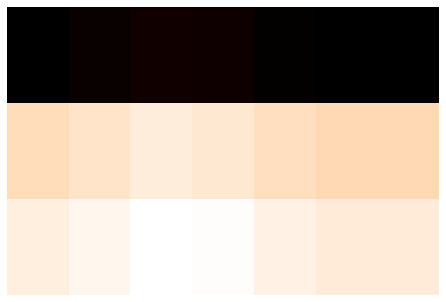

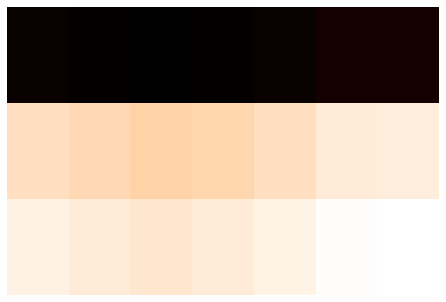

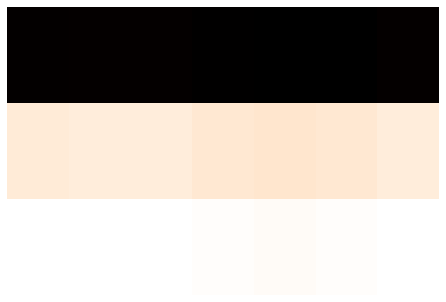

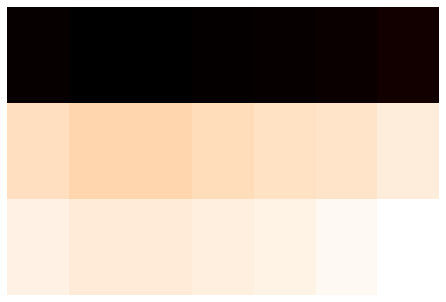

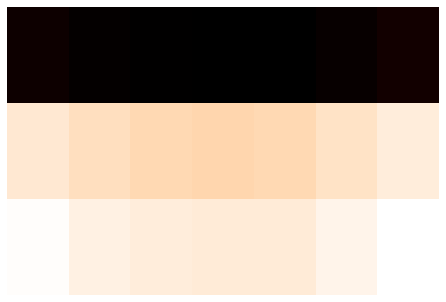

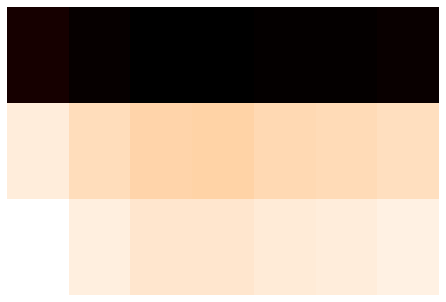

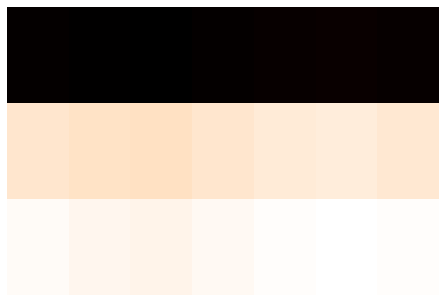

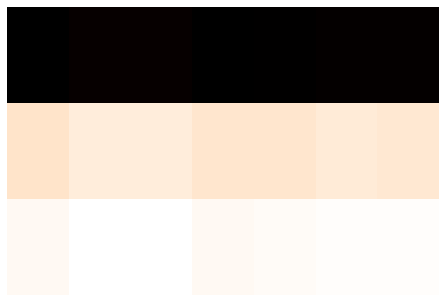

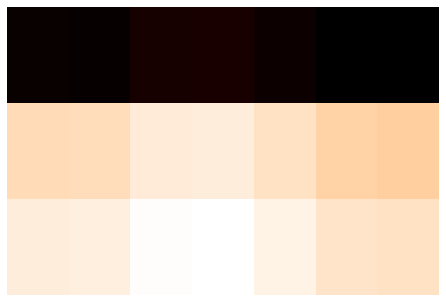

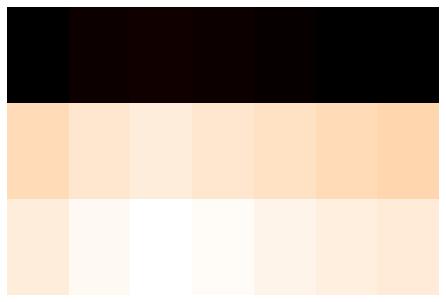

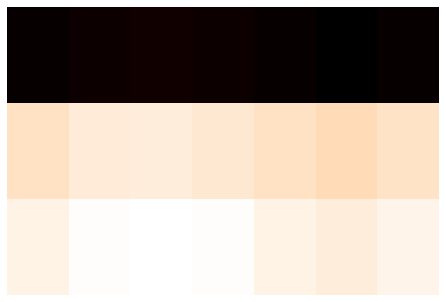

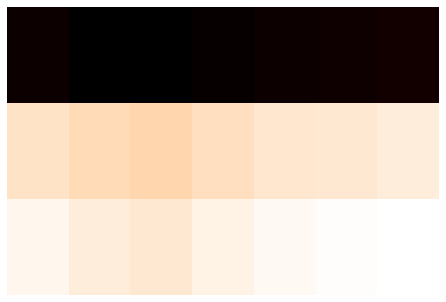

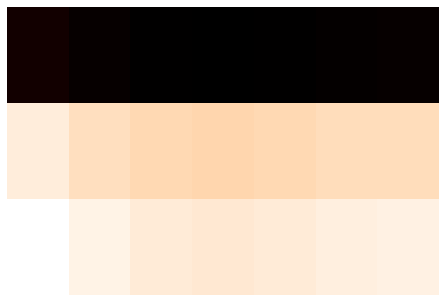

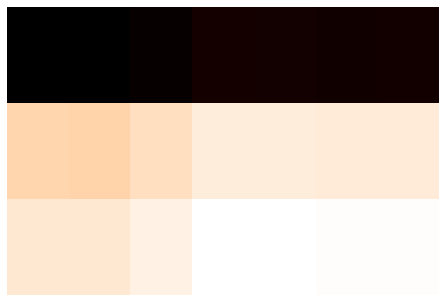

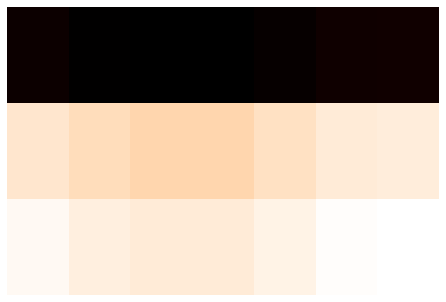

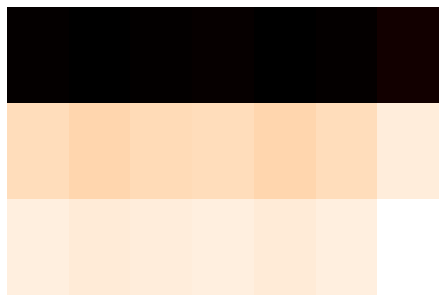

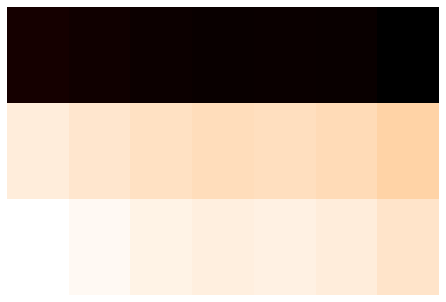

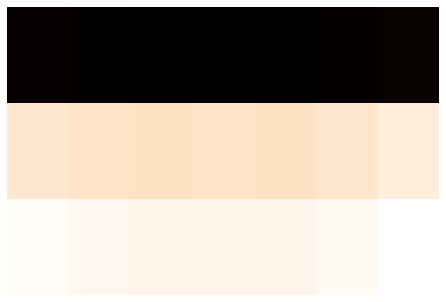

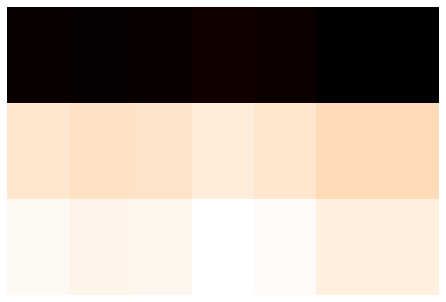

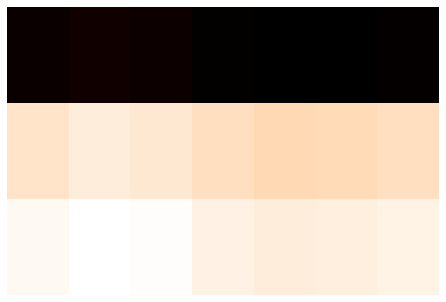

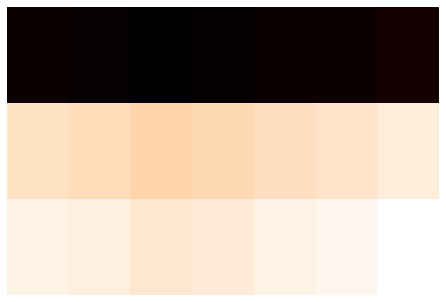

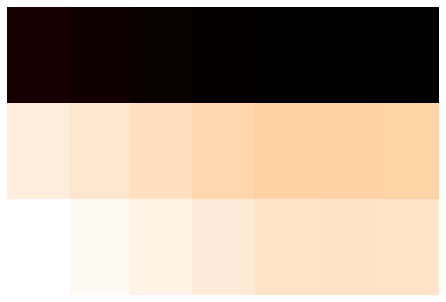

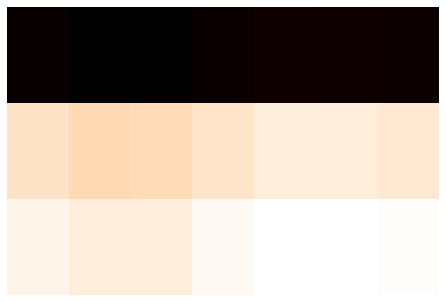

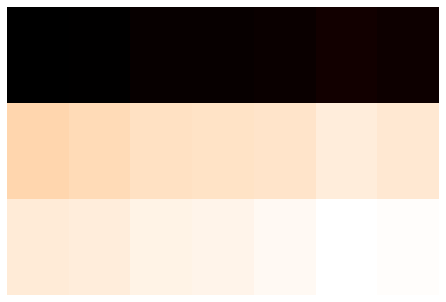

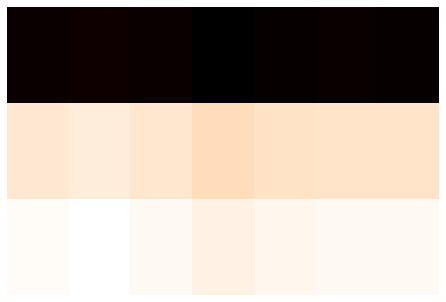

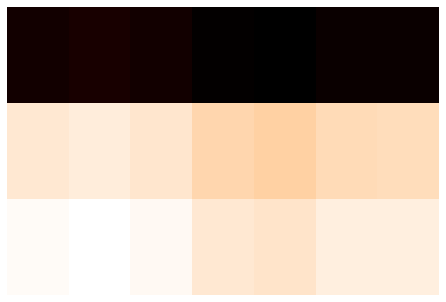

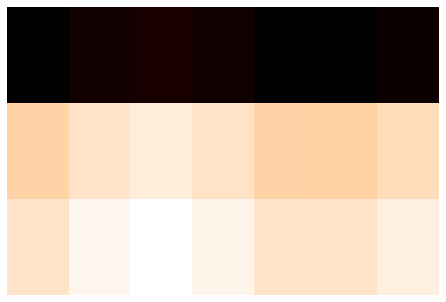

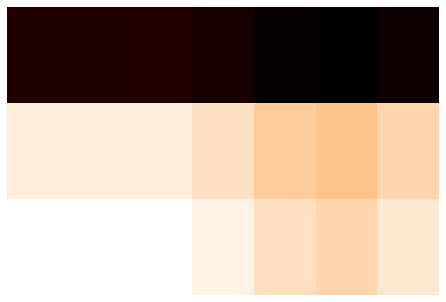

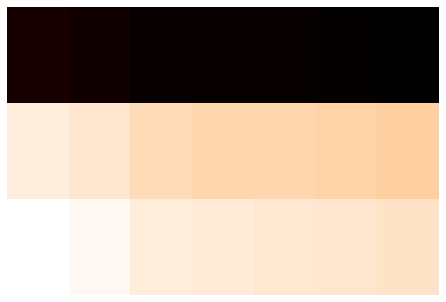

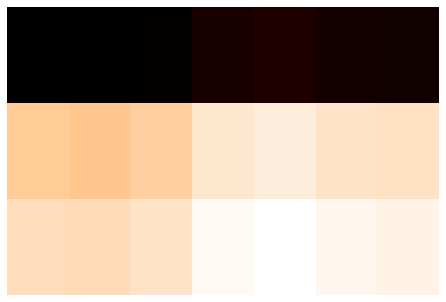

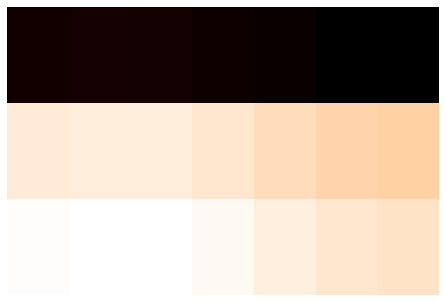

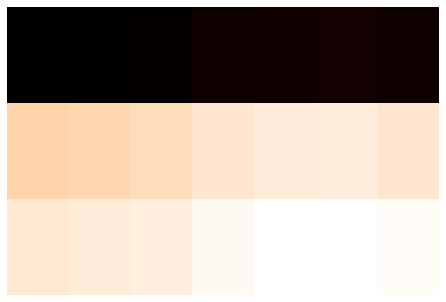

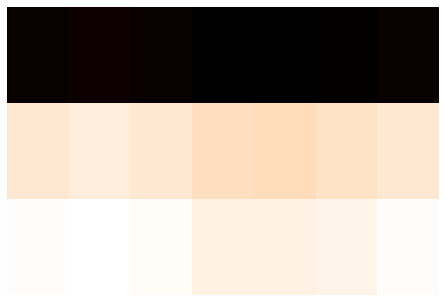

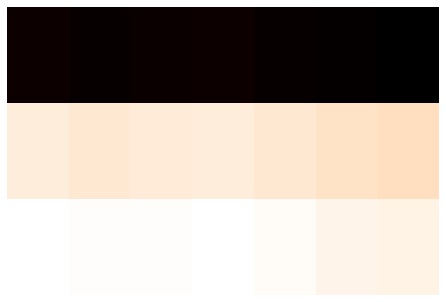

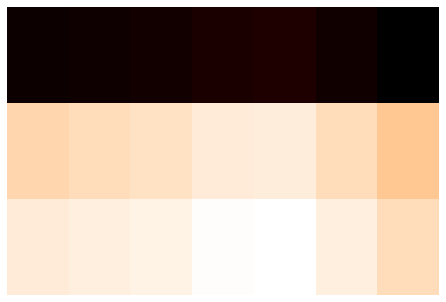

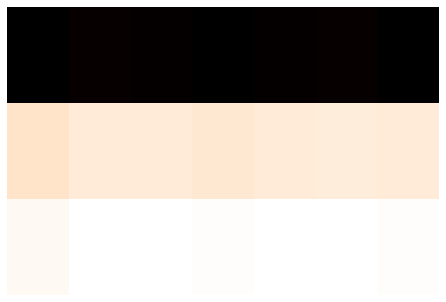

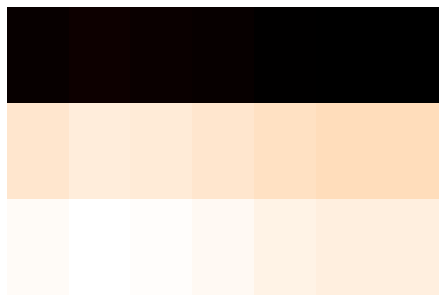

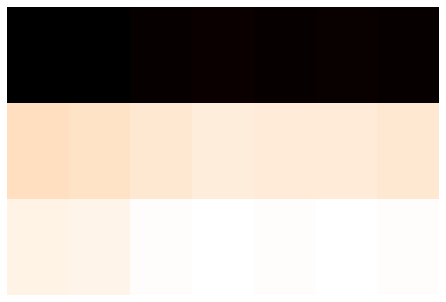

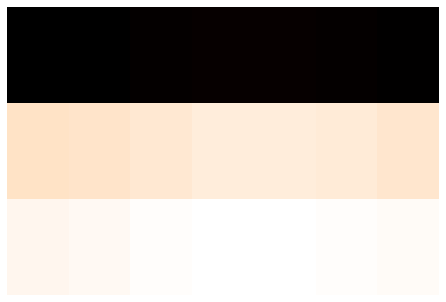

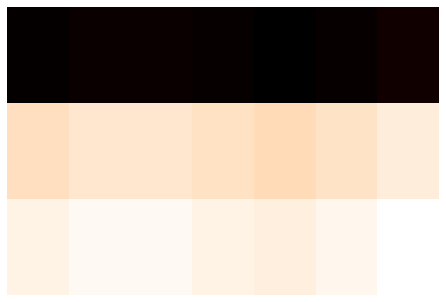

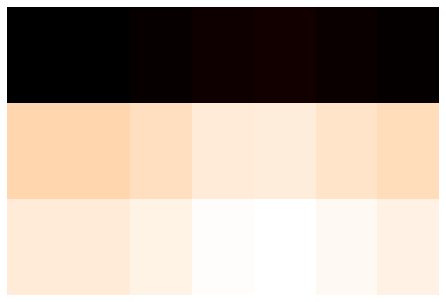

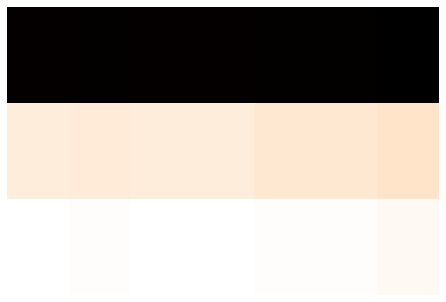

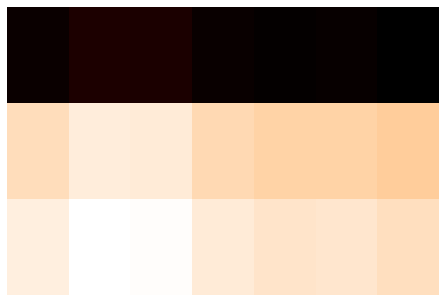

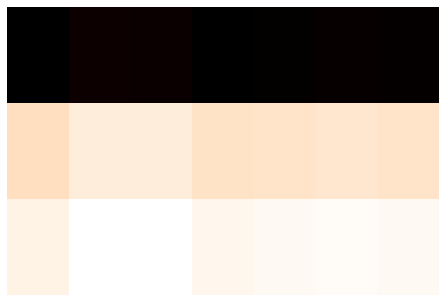

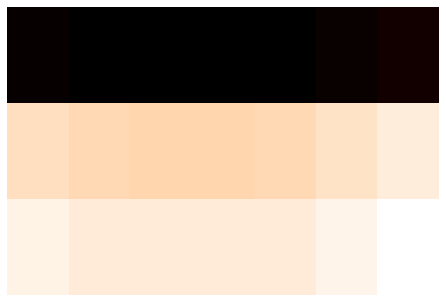

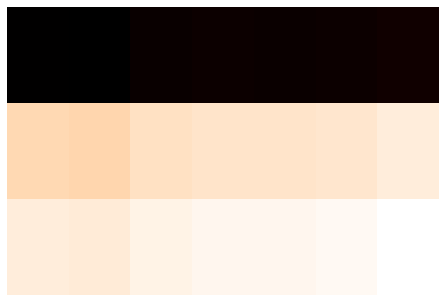

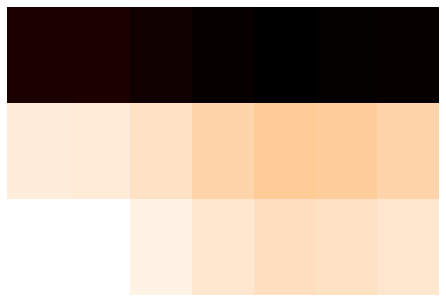

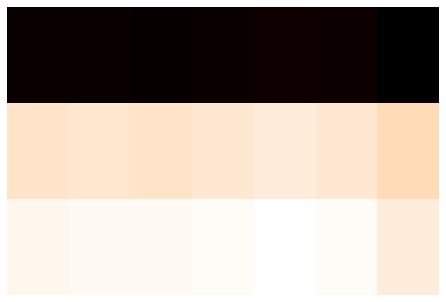

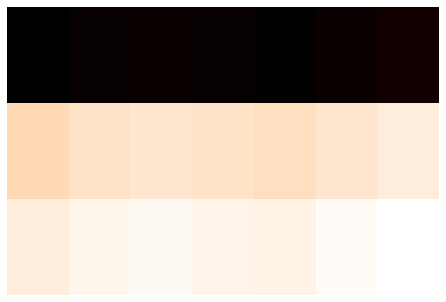

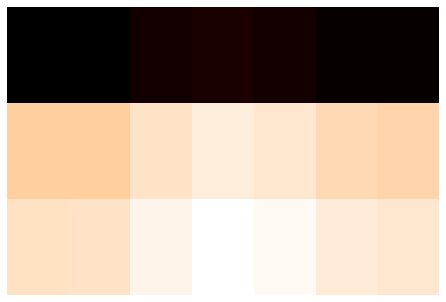

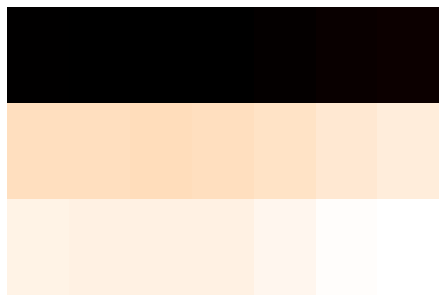

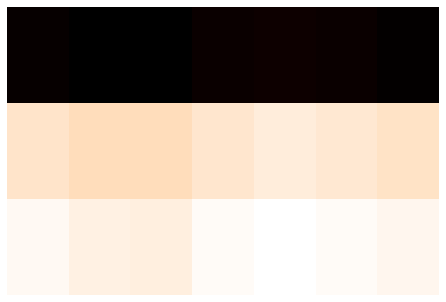

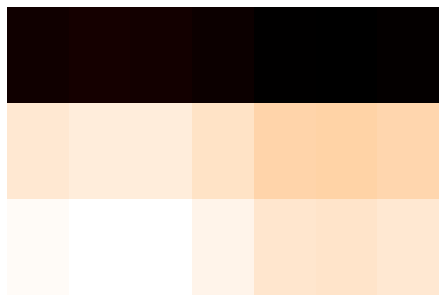

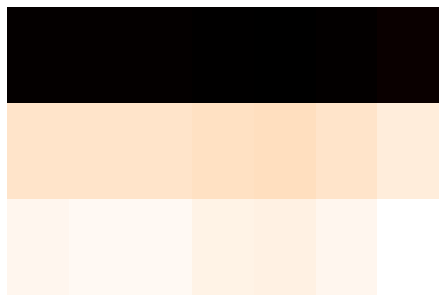

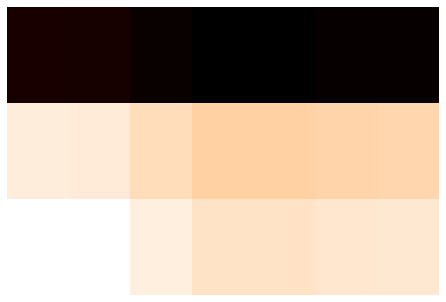

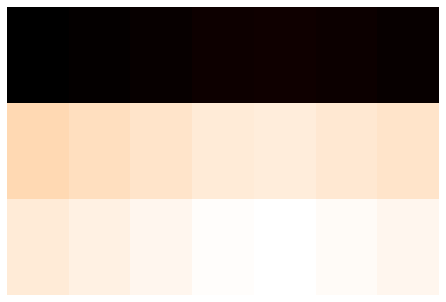

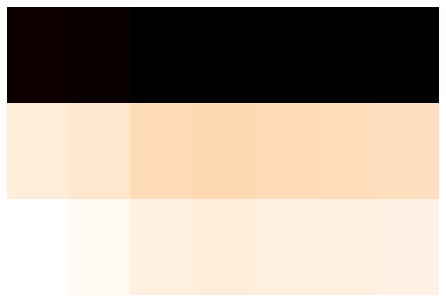

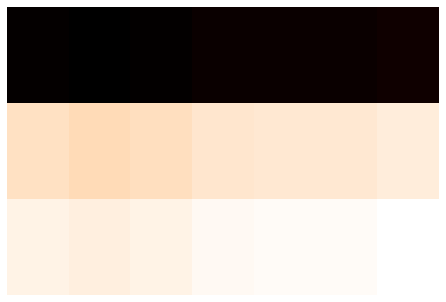

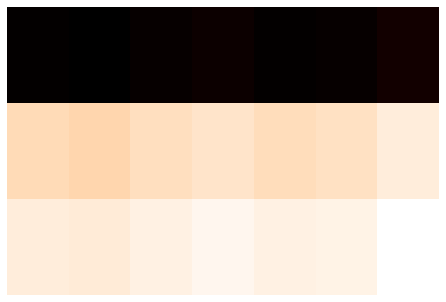

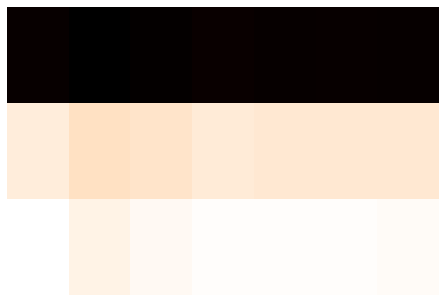

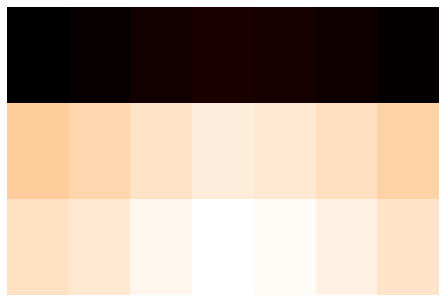

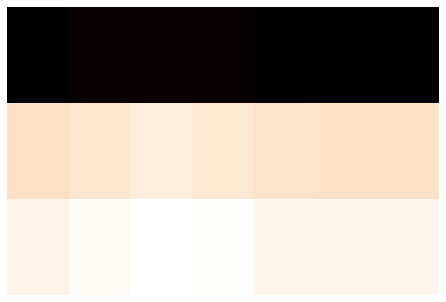

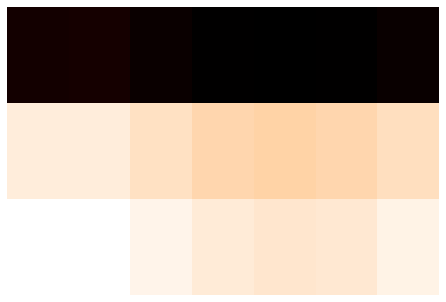

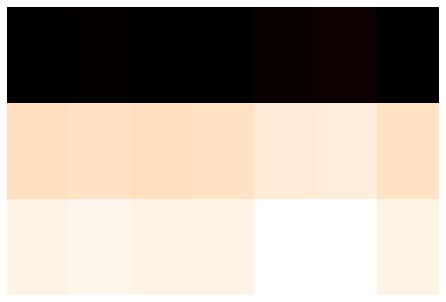

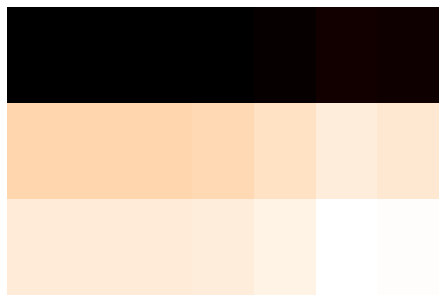

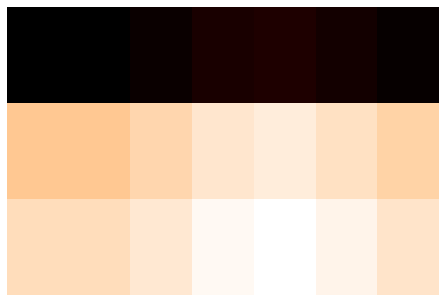

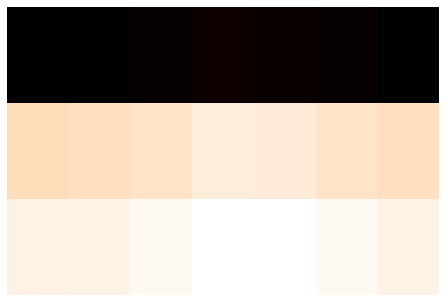

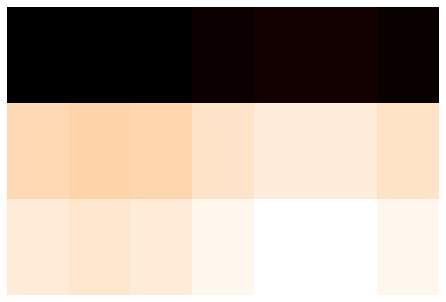

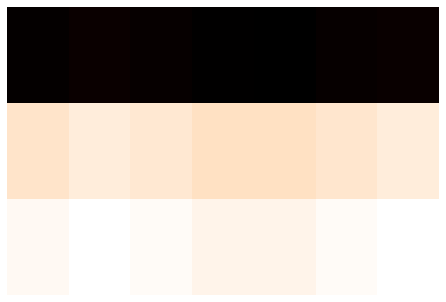

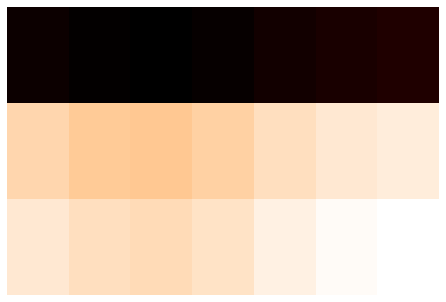

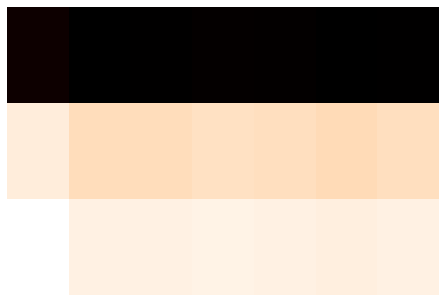

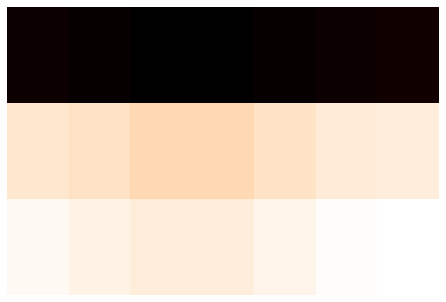

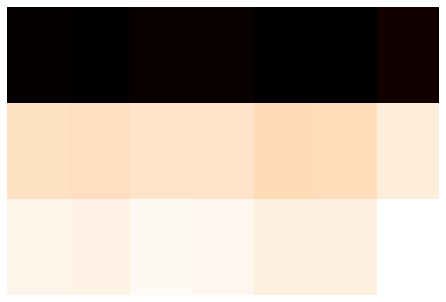

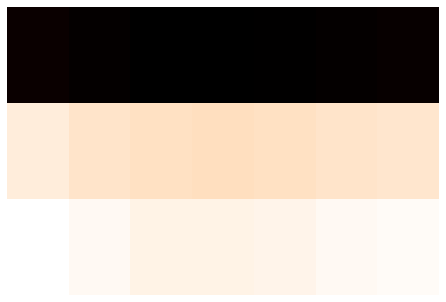

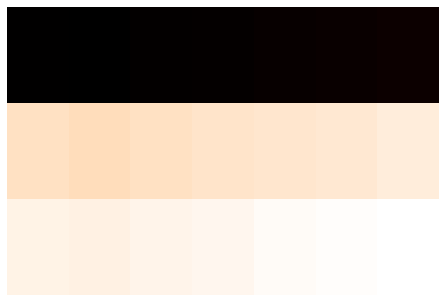

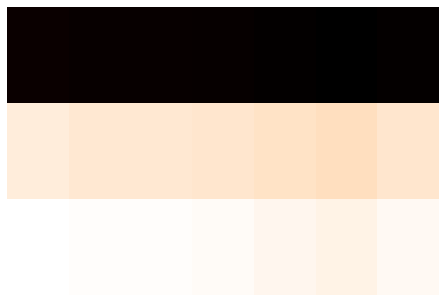

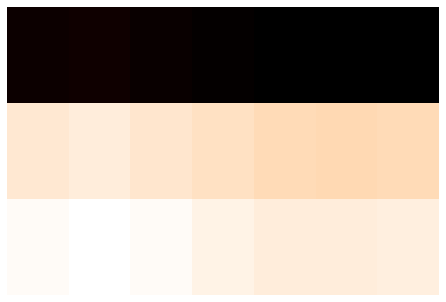

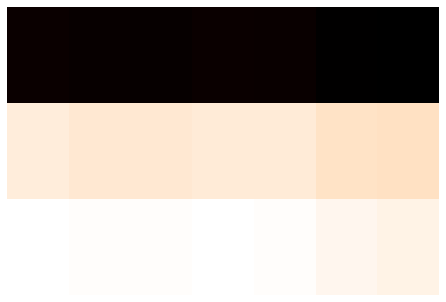

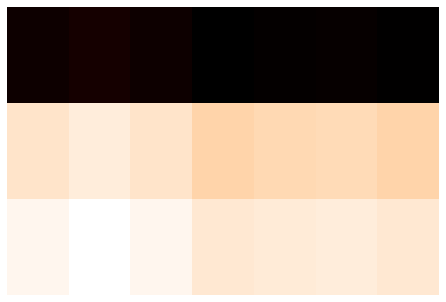

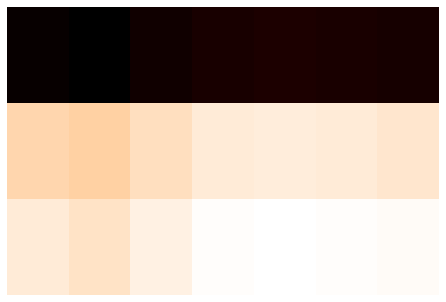

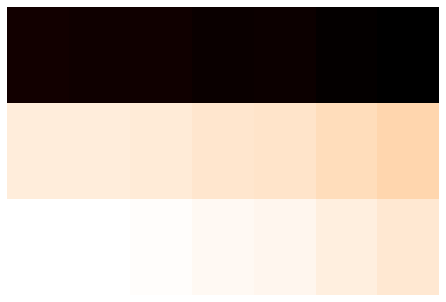

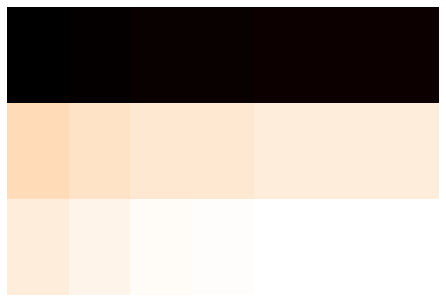

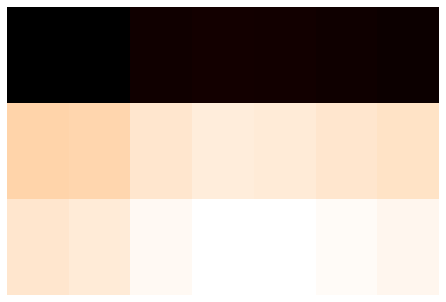

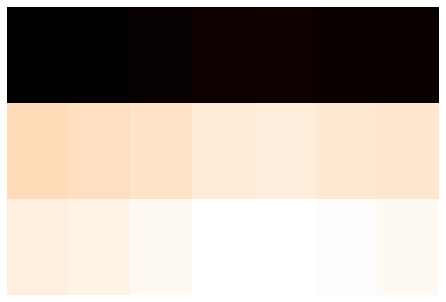

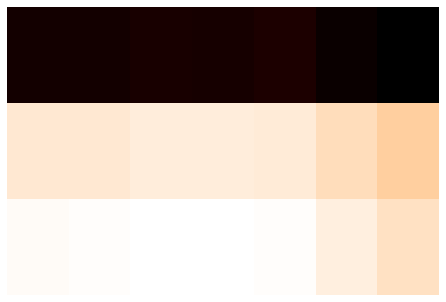

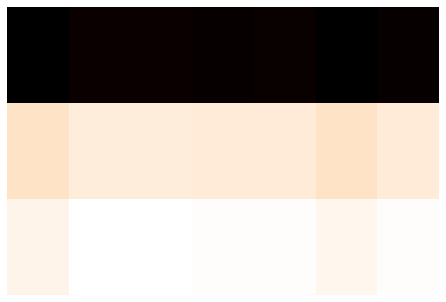

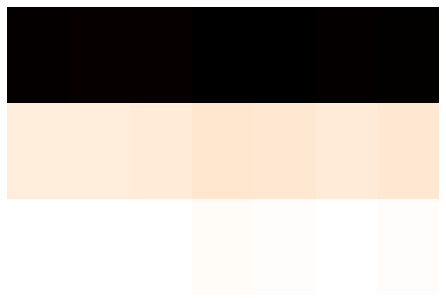

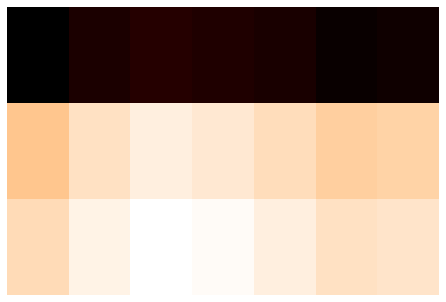

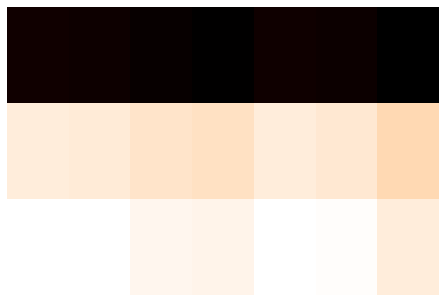

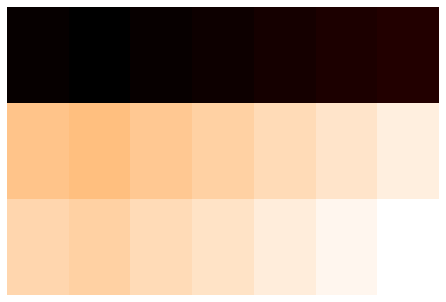

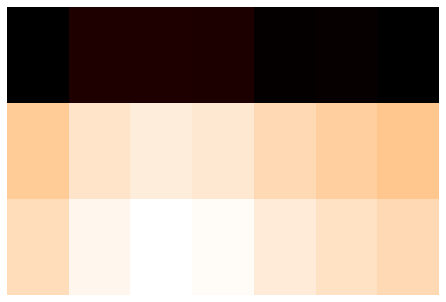

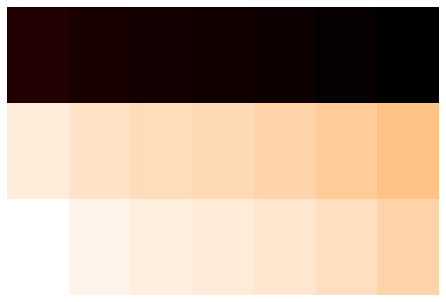

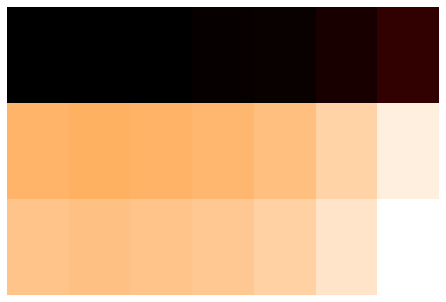

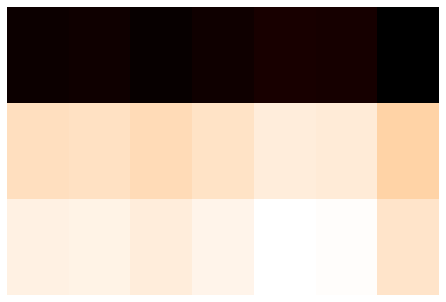

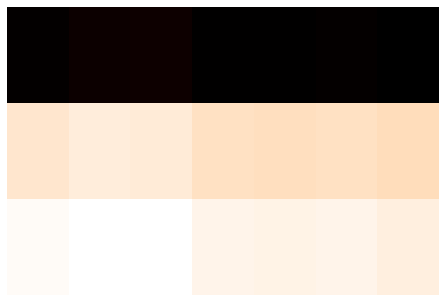

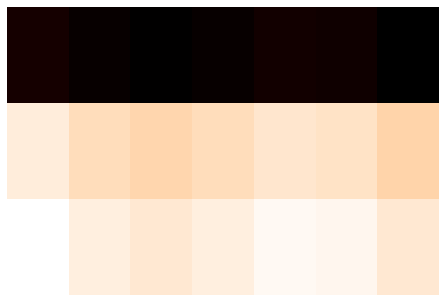

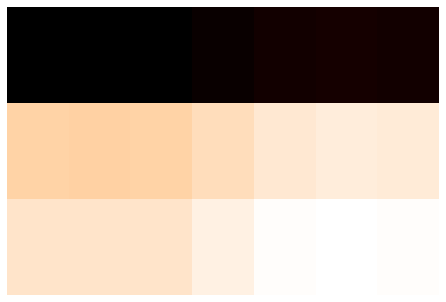

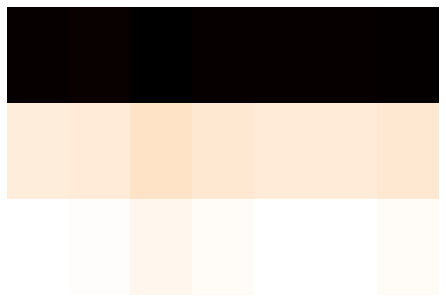

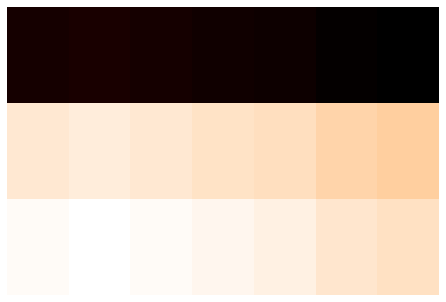

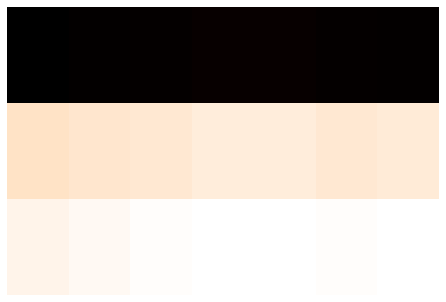

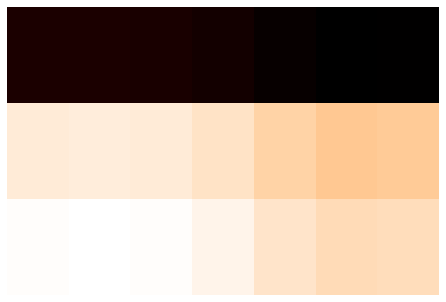

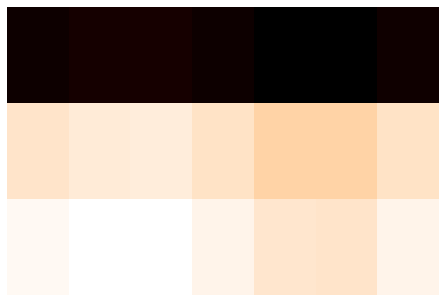

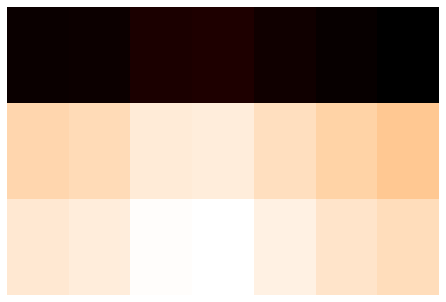

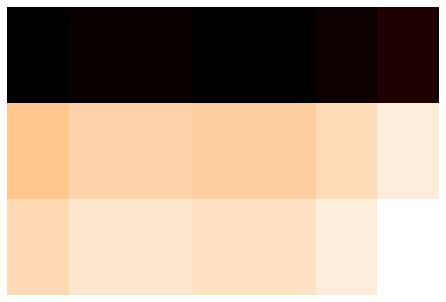

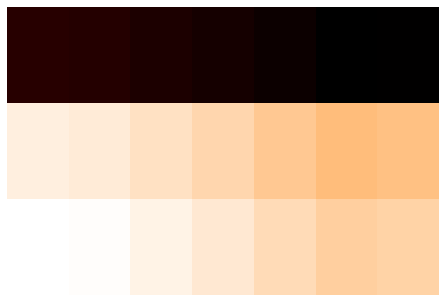

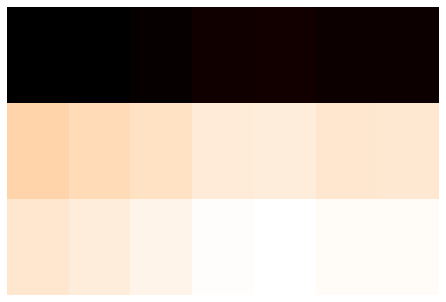

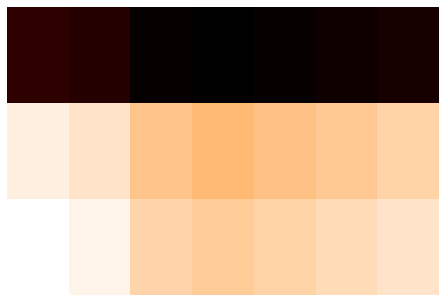

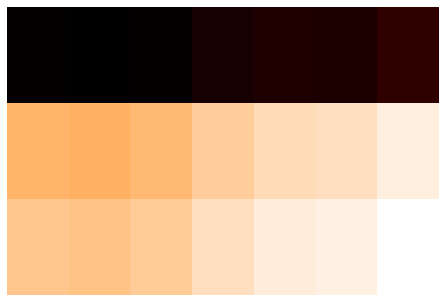

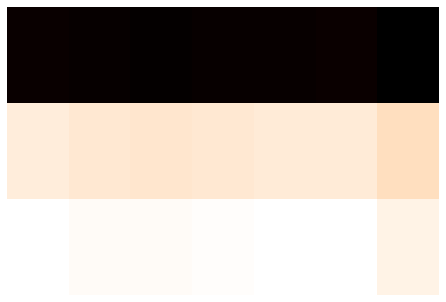

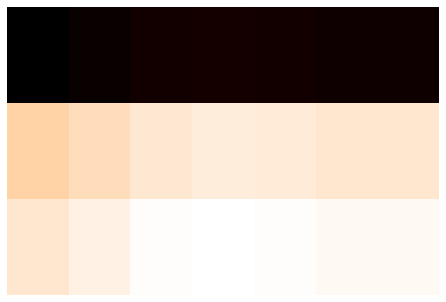

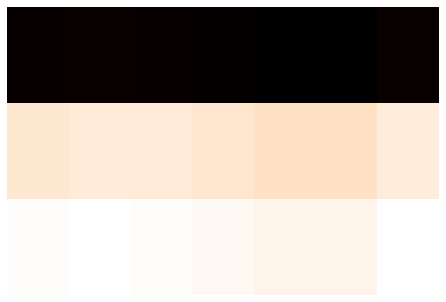

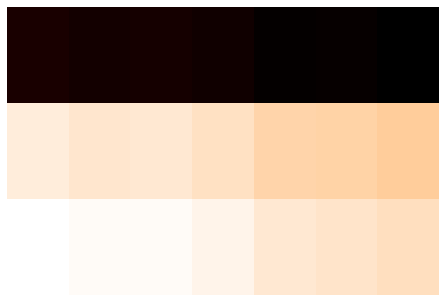

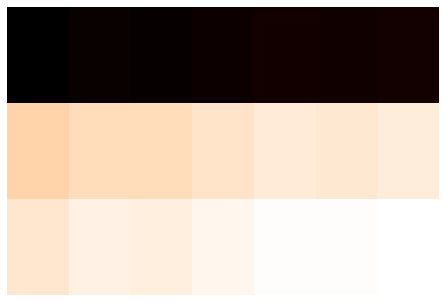

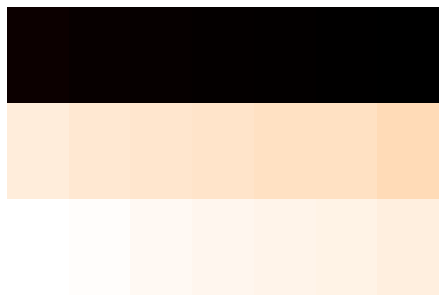

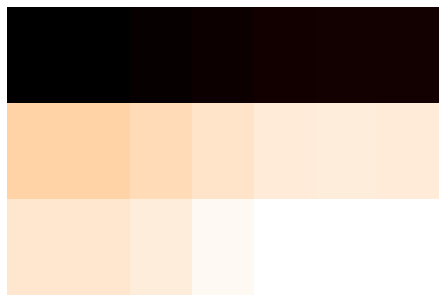

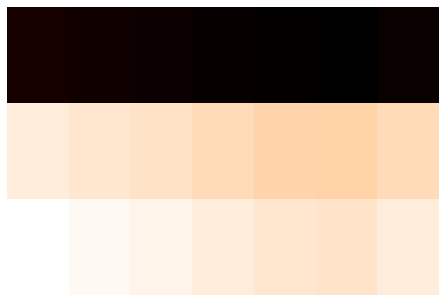

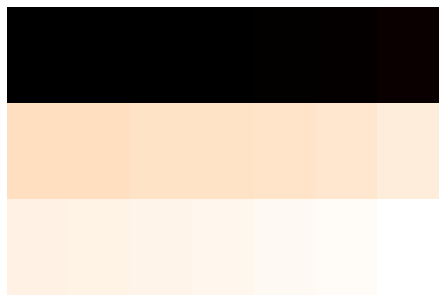

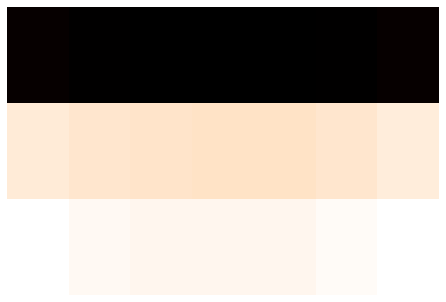

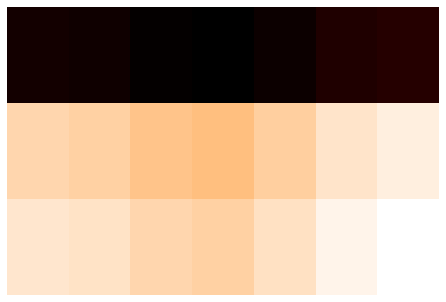

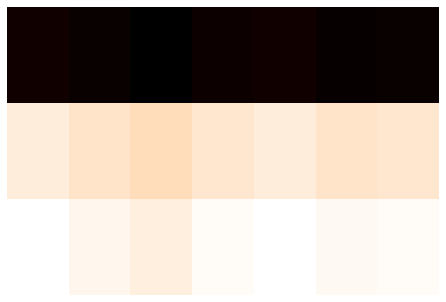

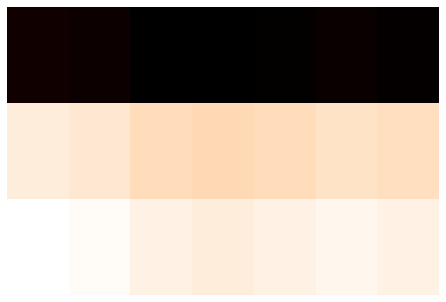

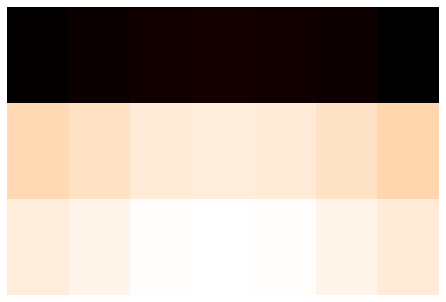

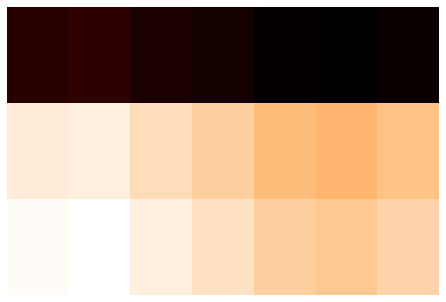

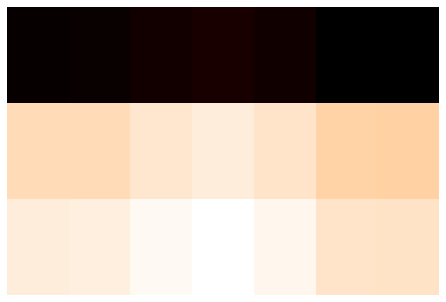

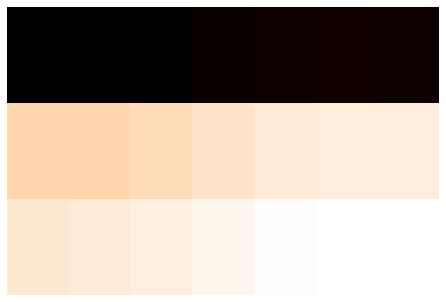

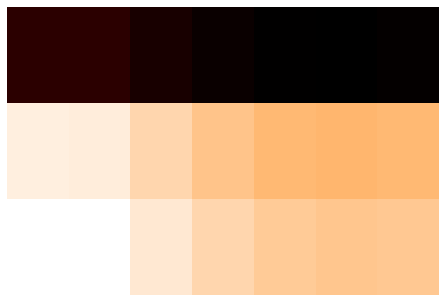

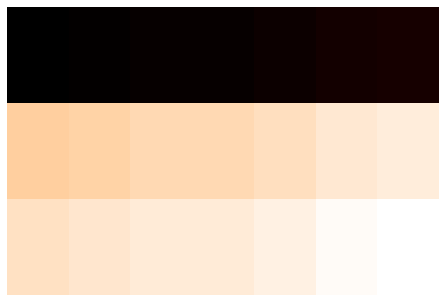

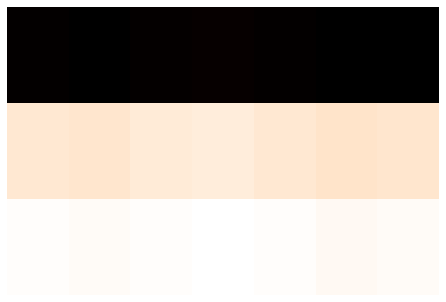

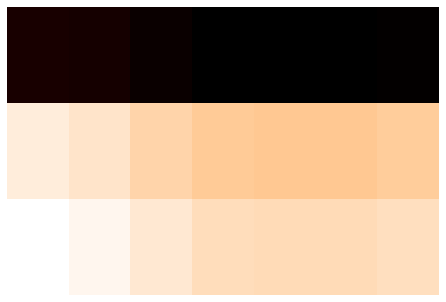

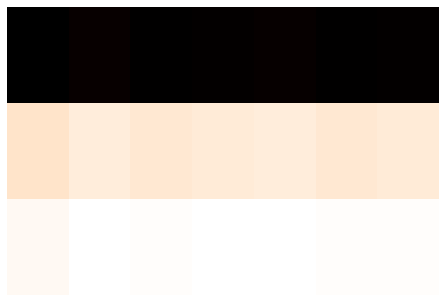

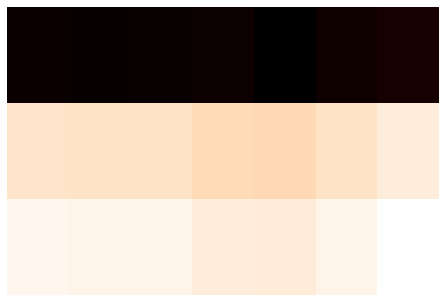

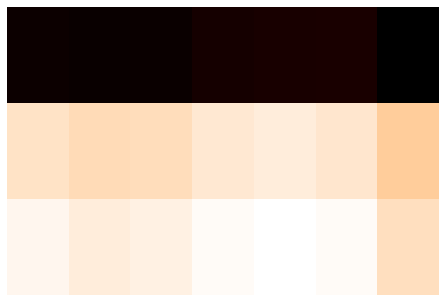

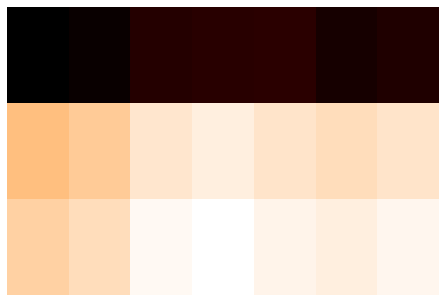

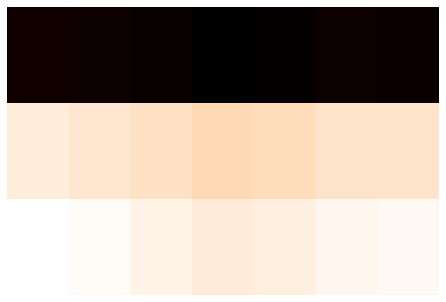

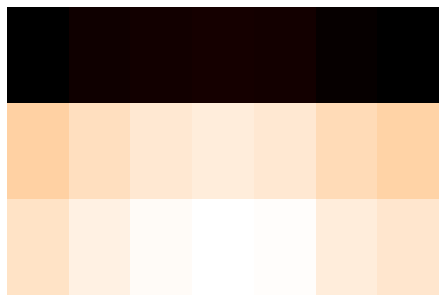

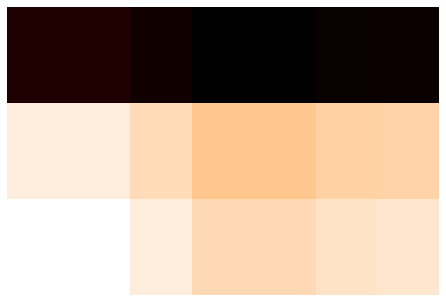

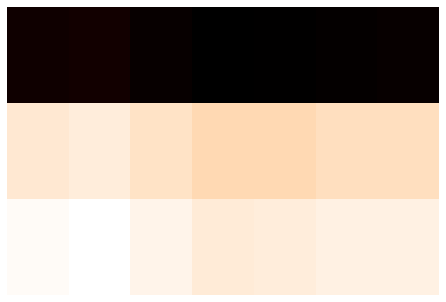

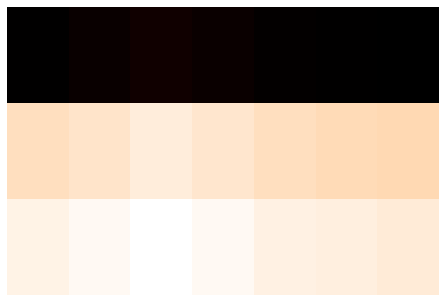

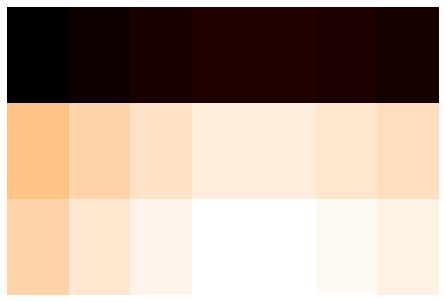

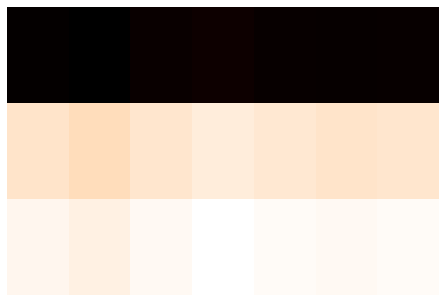

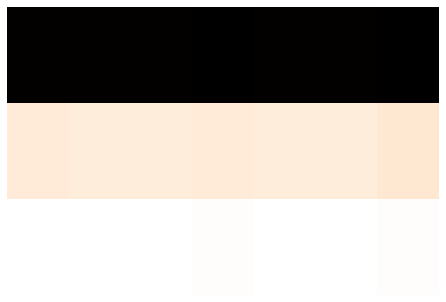

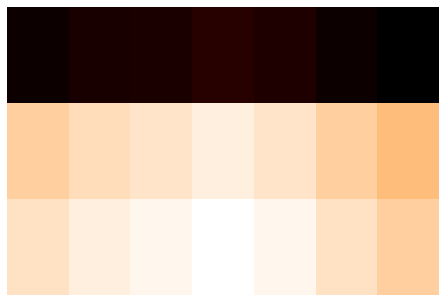

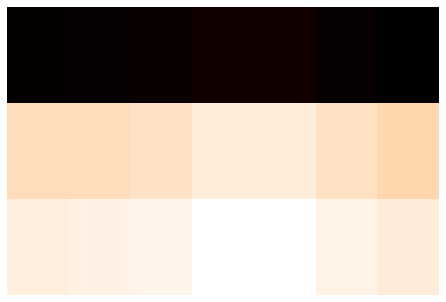

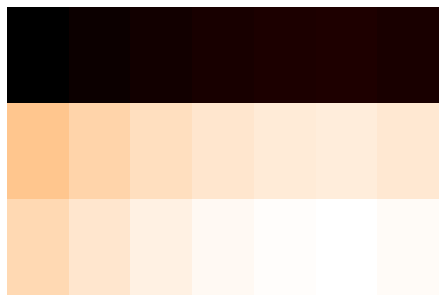

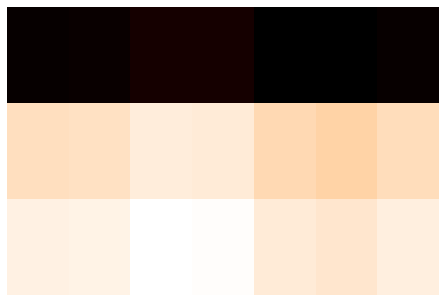

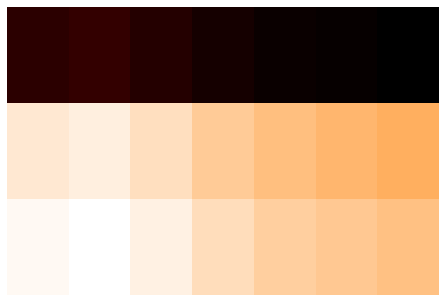

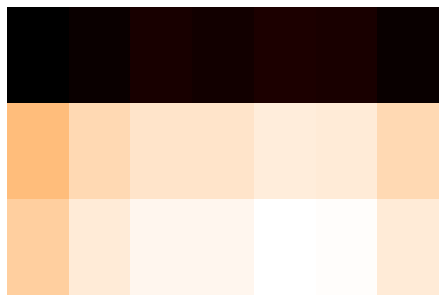

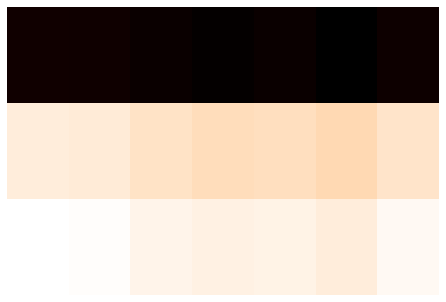

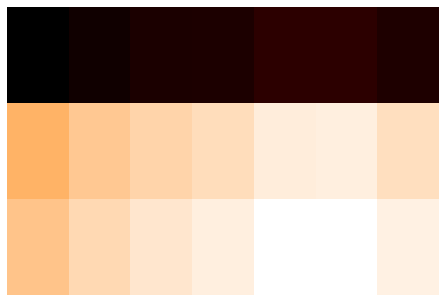

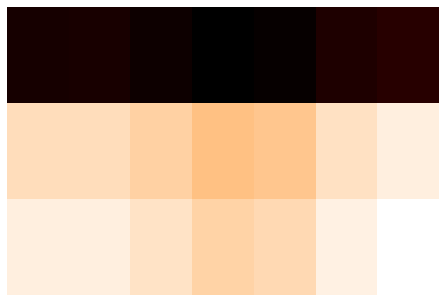

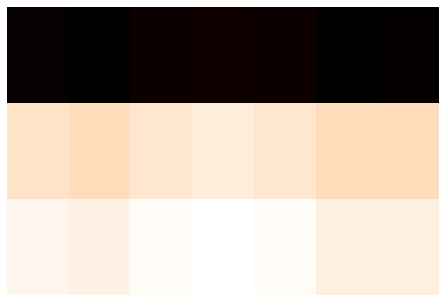

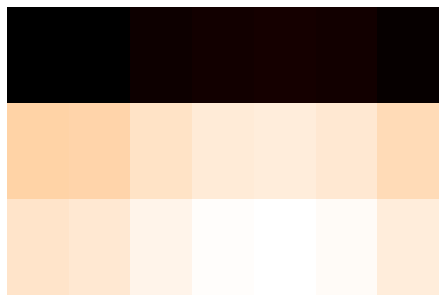

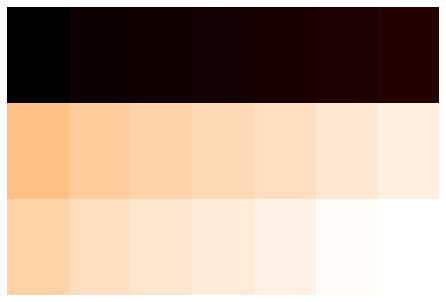

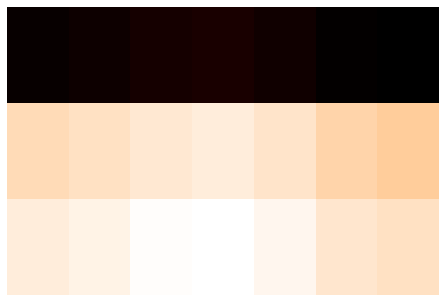

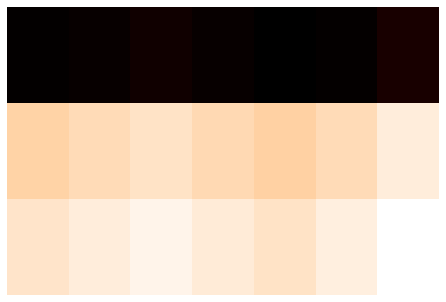

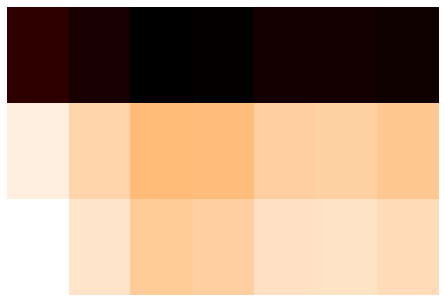

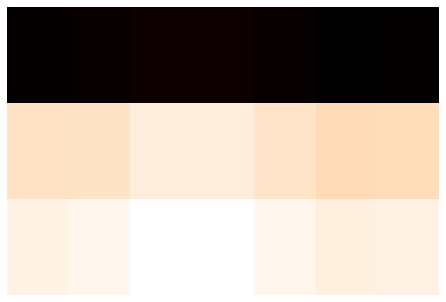

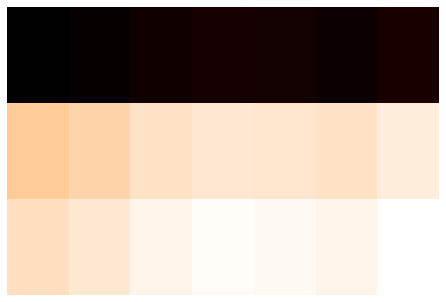

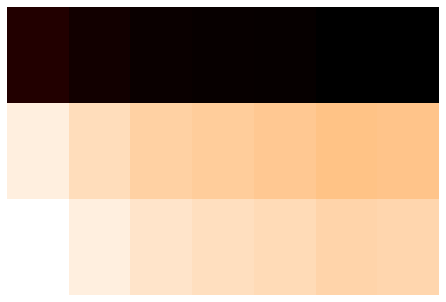

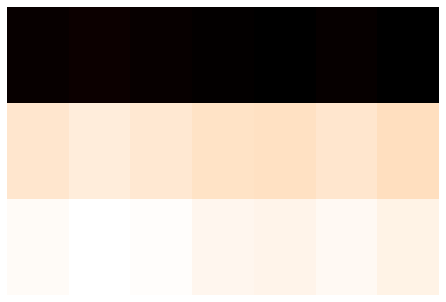

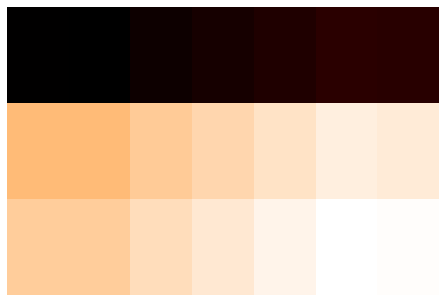

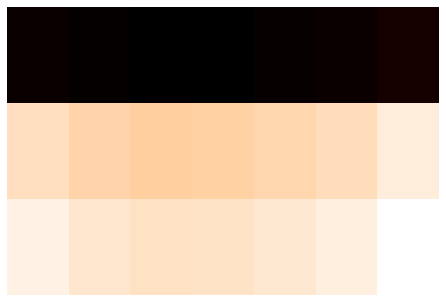

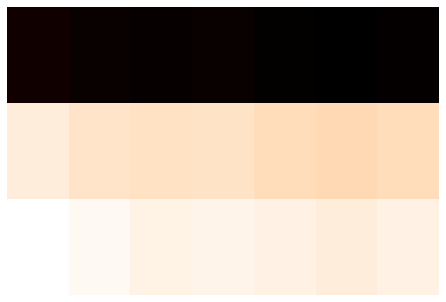

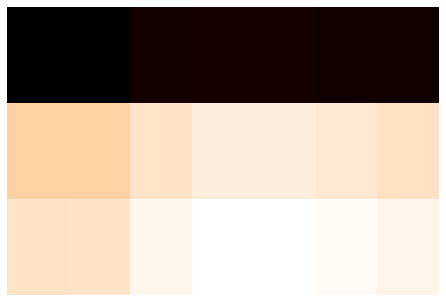

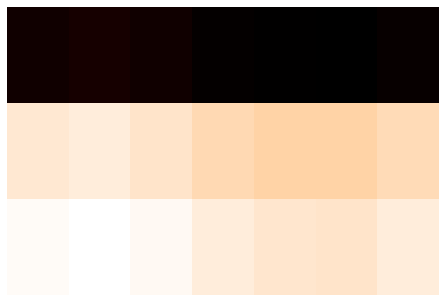

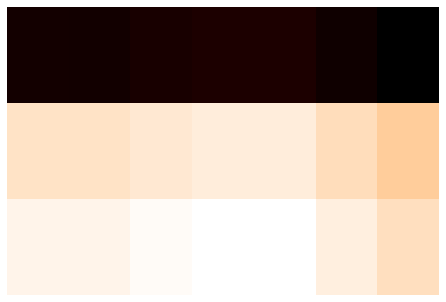

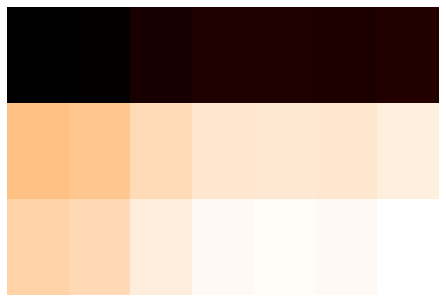

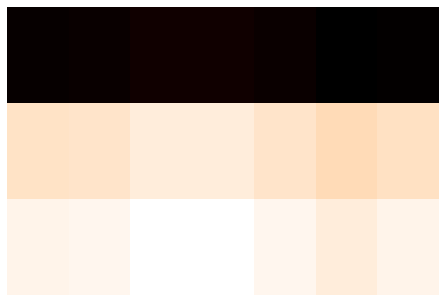

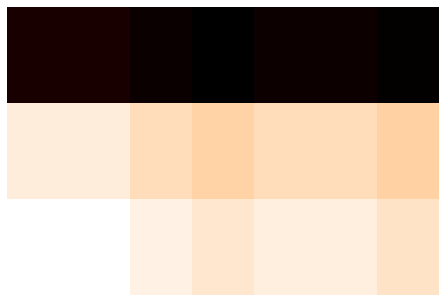

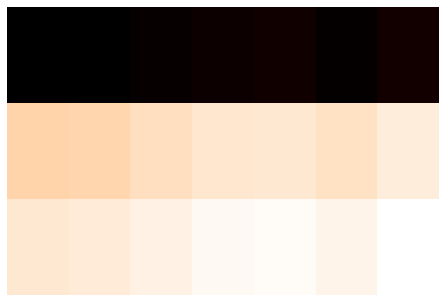

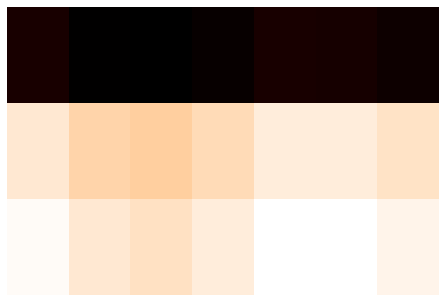

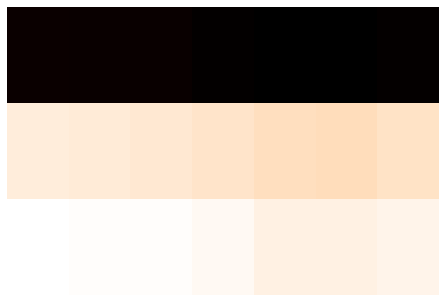

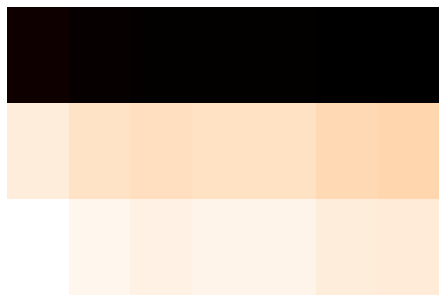

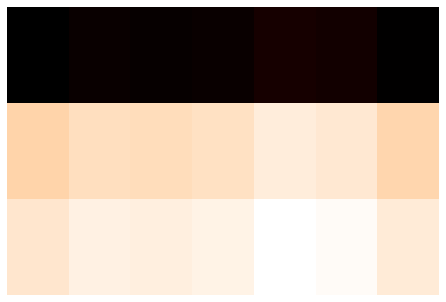

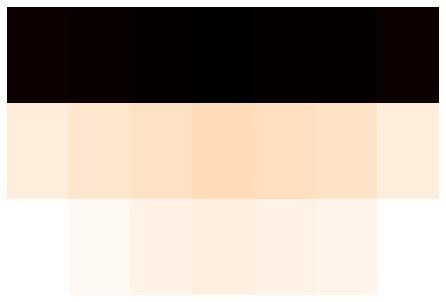

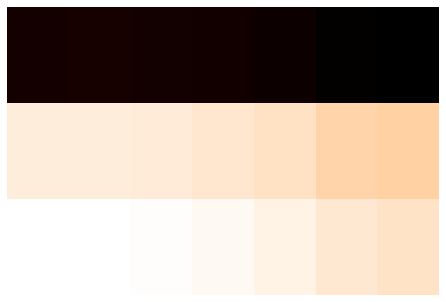

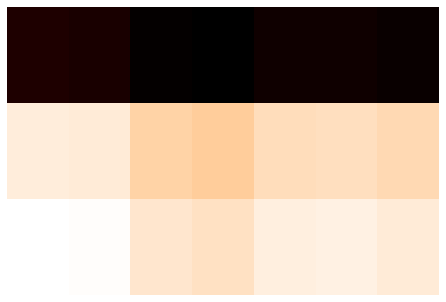

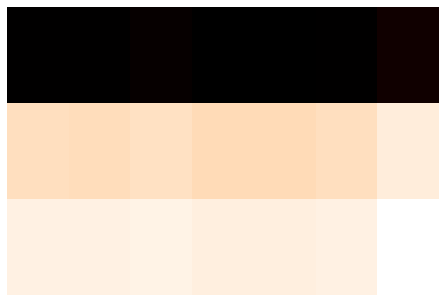

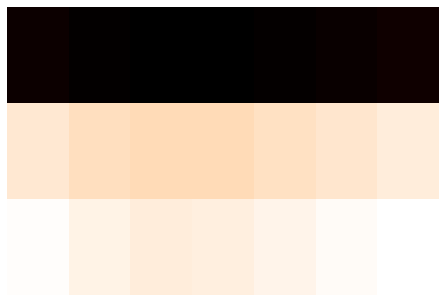

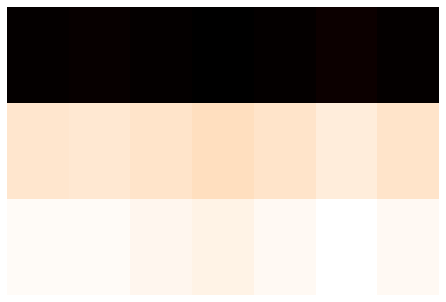

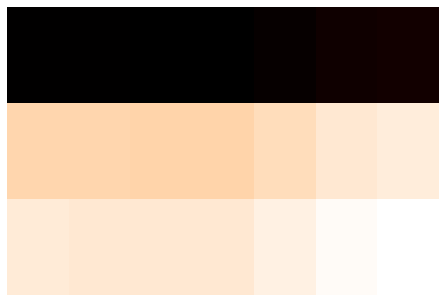

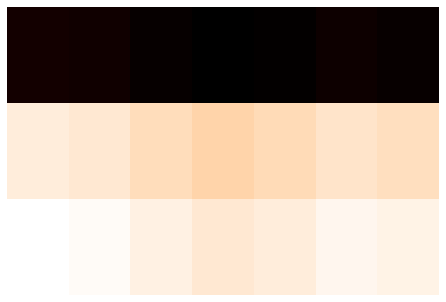

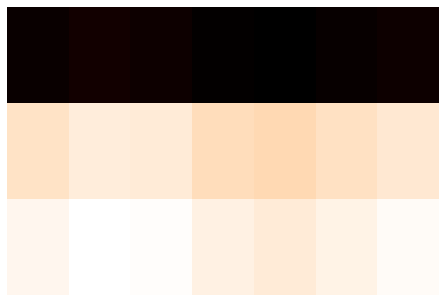

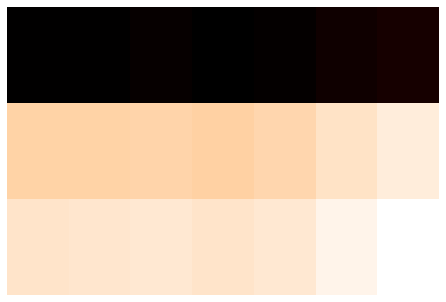

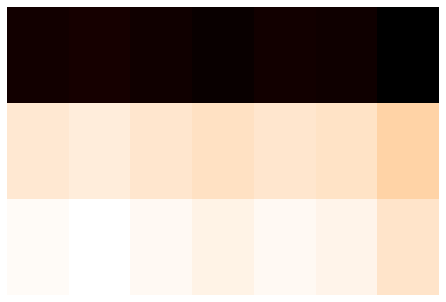

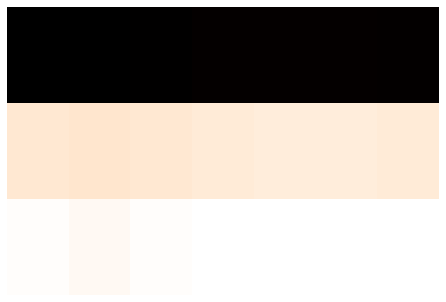

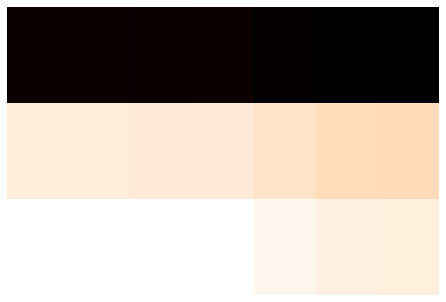

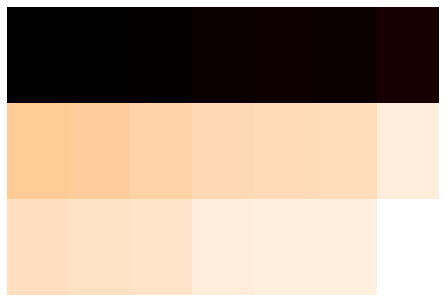

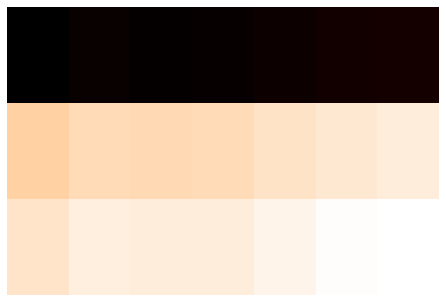

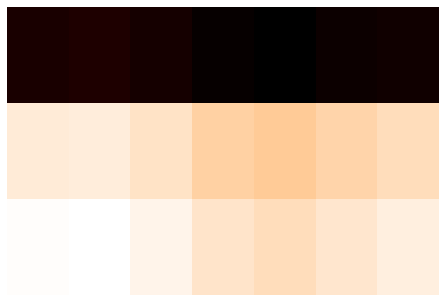

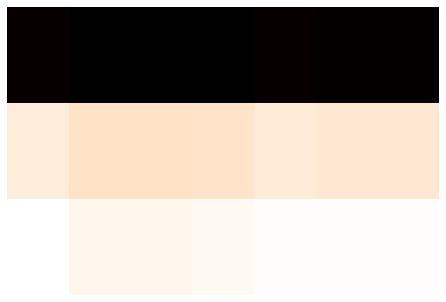

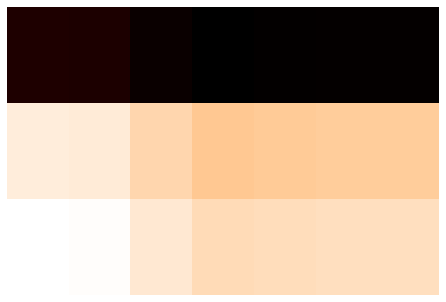

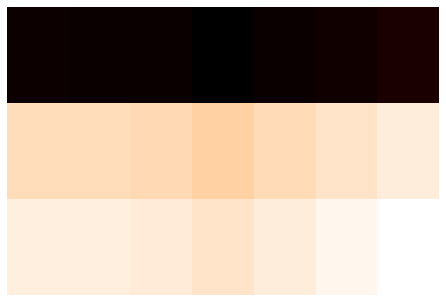

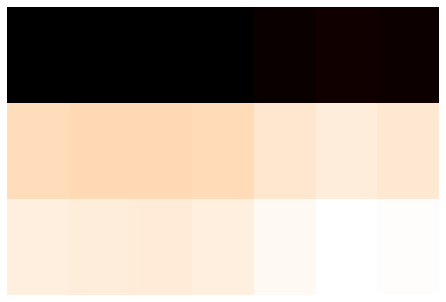

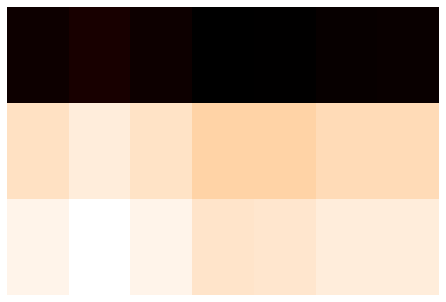

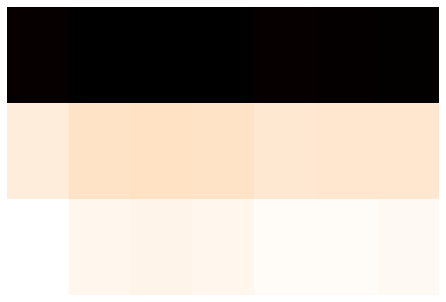

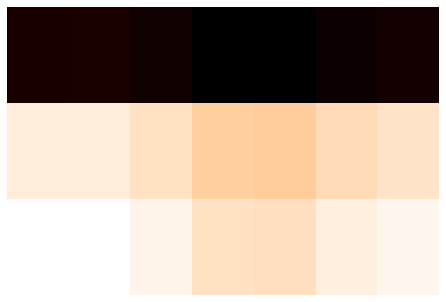

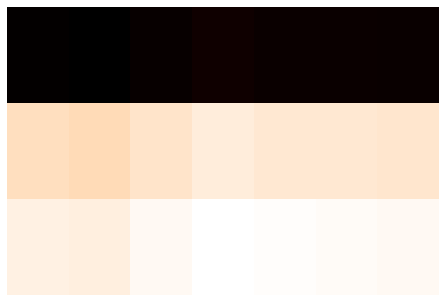

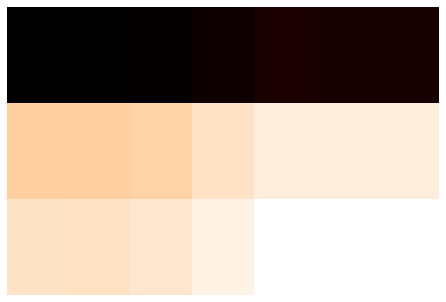

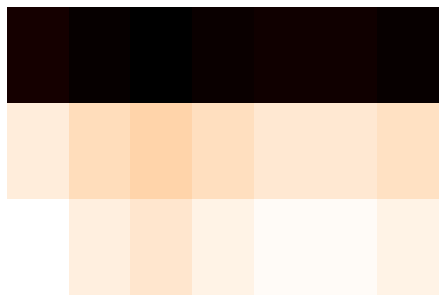

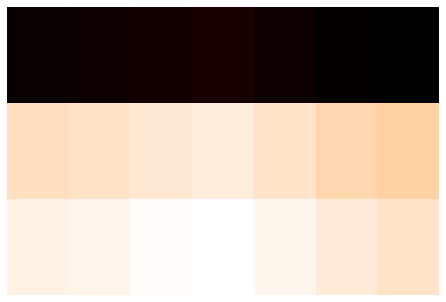

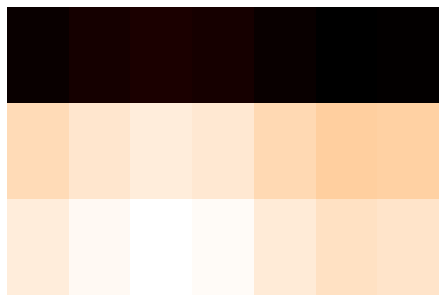

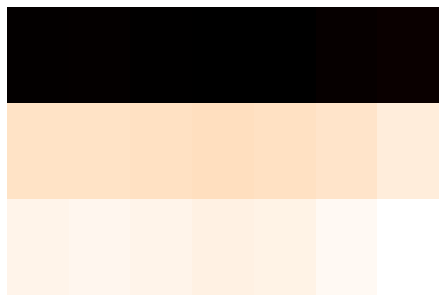

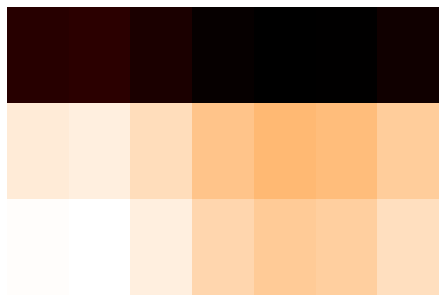

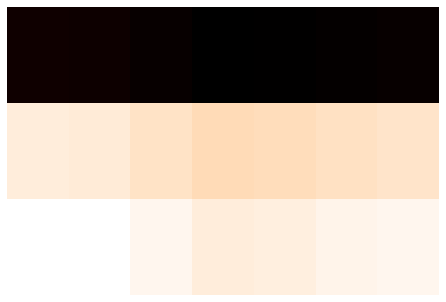

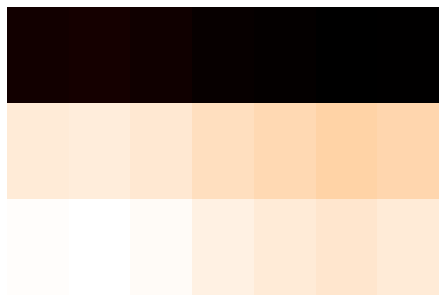

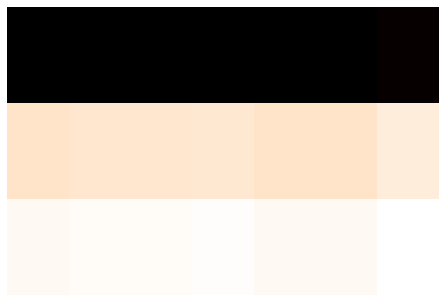

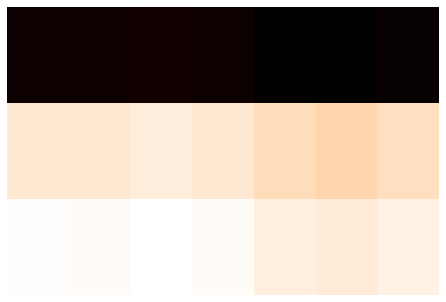

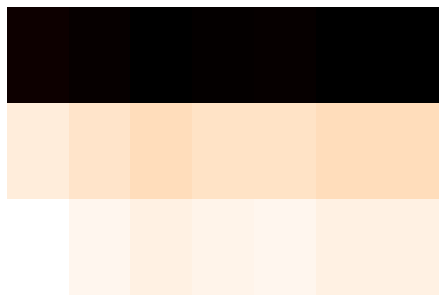

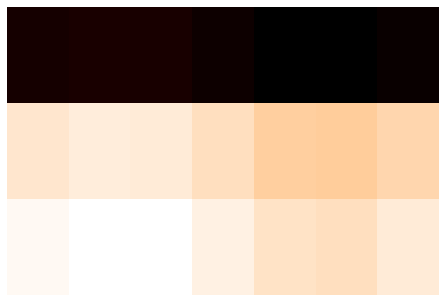

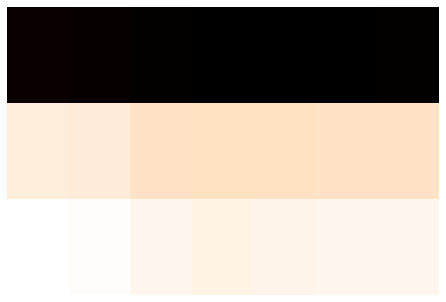

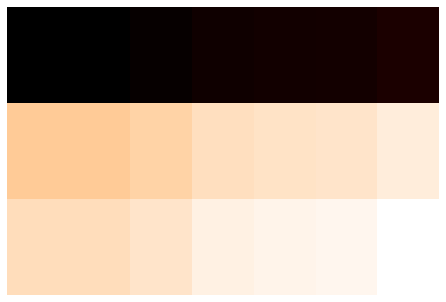

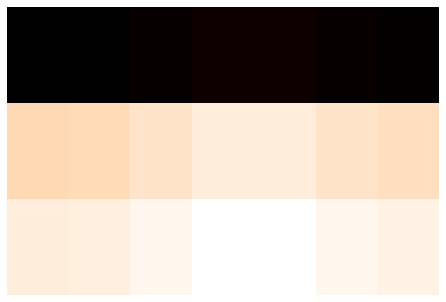

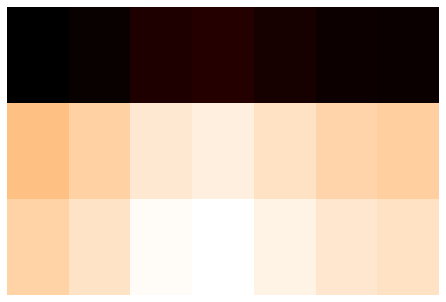

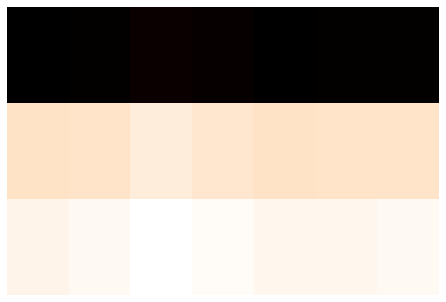

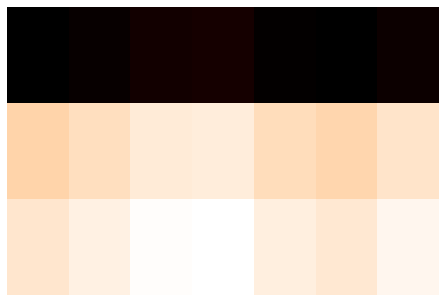

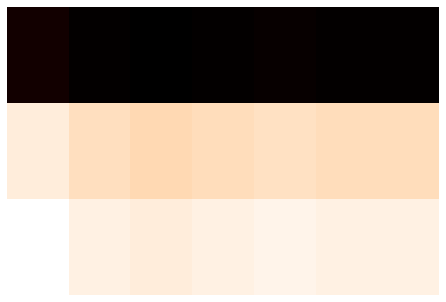

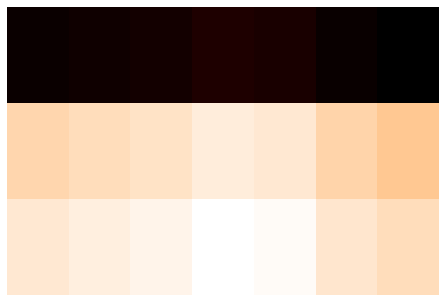

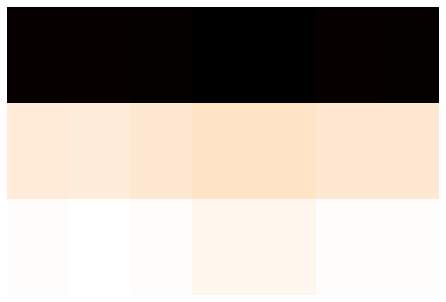

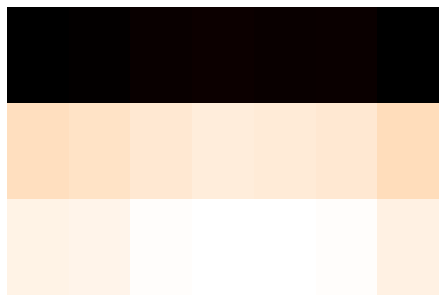

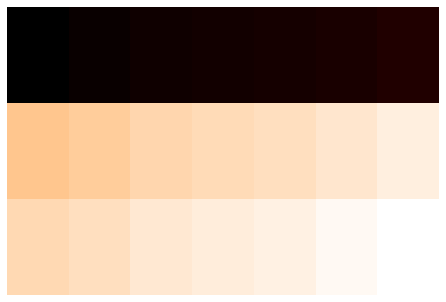

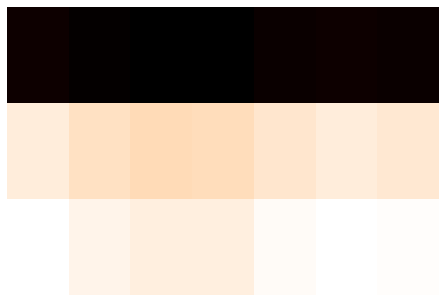

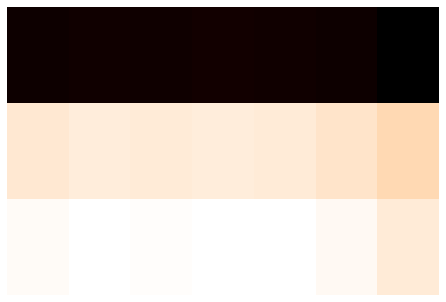

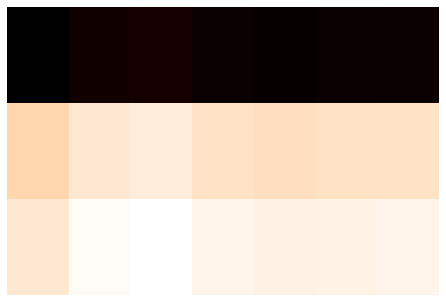

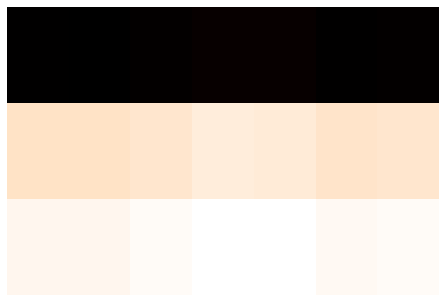

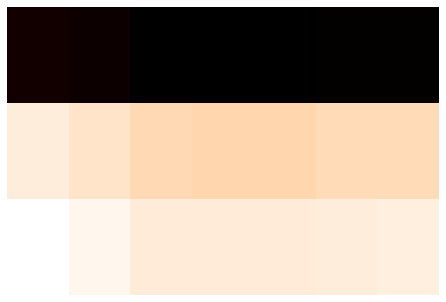

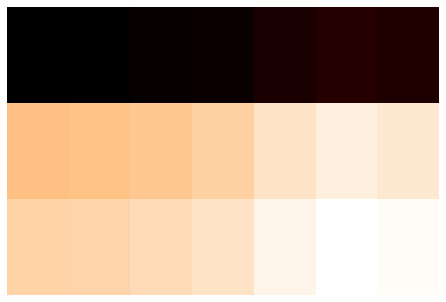

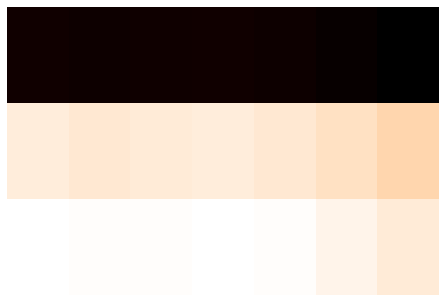

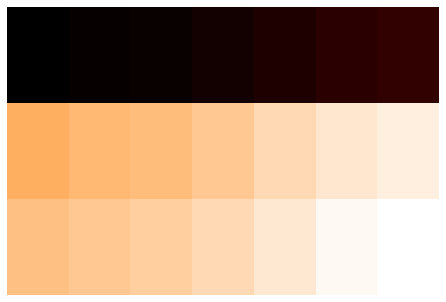

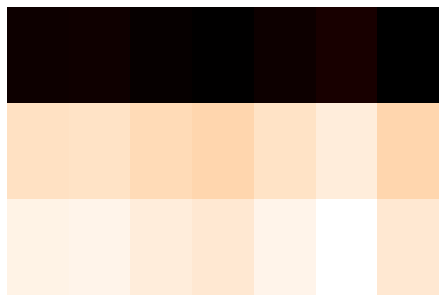

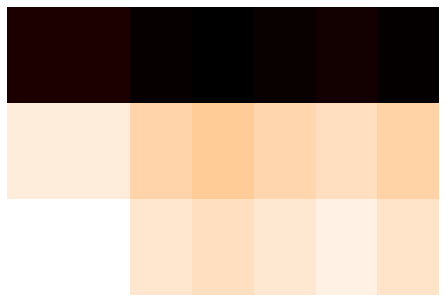

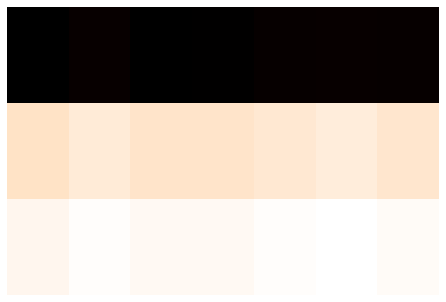

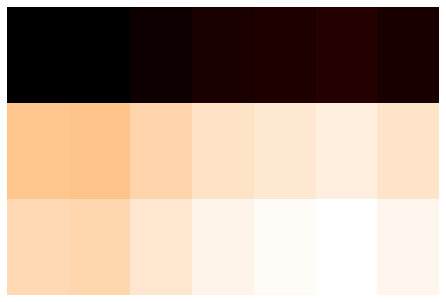

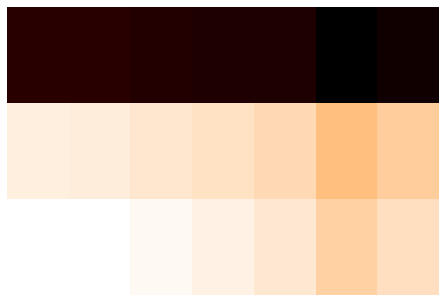

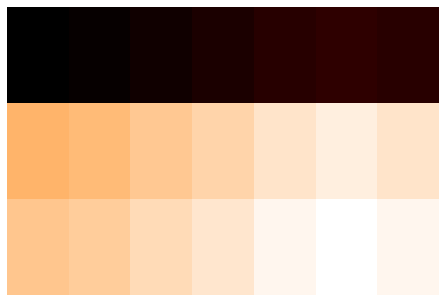

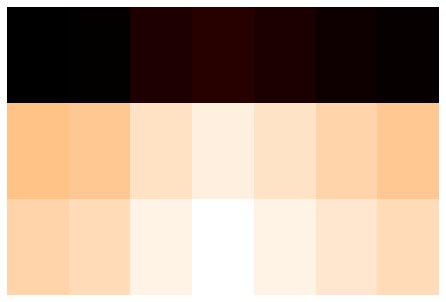

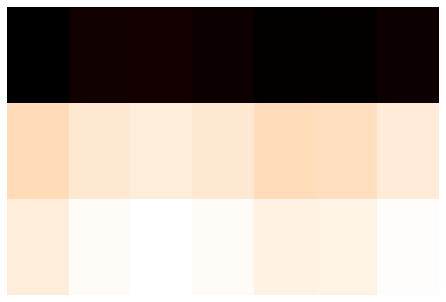

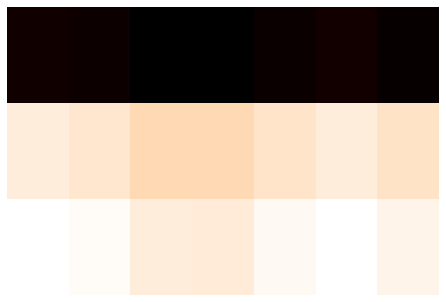

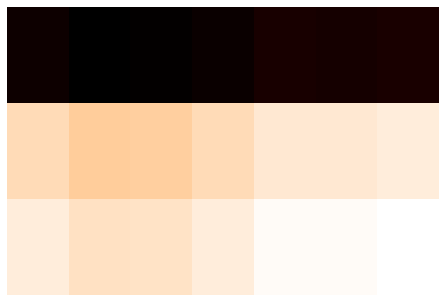

In [38]:
for item in range(0, len(allData)):

    data = np.array(allData[item])

    fig = plt.figure()

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    Pxx, freqs, bins, im = plt.specgram(data, NFFT=5, Fs=1, noverlap=1, cmap=plt.cm.gist_heat)
    fig.savefig('./images/' + str(item).zfill(4) + '.png')